In [11]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from pprint import pprint
from tqdm import tqdm
import datetime

sns.set_style('whitegrid')

In [12]:
# Function utils

def get_dataset_from_config_txt(config_txt):
    return config_txt.iloc[8][0]

def get_num_words_from_tsv(record_tsv):
    return int(record_tsv.iloc[-1][0].split(" ")[0])

def get_num_sentences_from_tsv(record_tsv):
    return int(record_tsv.iloc[-1][0].split(" ")[3])

def get_best_F1_from_tsv(record_tsv):
    train_max = max([float(a) for a in record_tsv['T_F1']])
    val_max = float([a for a in record_tsv['V_F1']][-6])
    assert all(np.isnan(float(a)) for a in record_tsv['V_F1'][-3:])
    
    # THIS IS TEST F1
    test_F1 = float(record_tsv["T_RECL"].iloc[-2])
    val_F1 = float(record_tsv["V_F1"].iloc[-6])
    train_F1 = float(record_tsv["V_F1"].iloc[-4])
    
    return {"train": train_max, "test": test_F1, "val": val_F1}
    # return {"train": max(train_curve), "val": max(val_curve)} # Might be worth checking how long they train for too?

def get_acquisition_from_root(root):
    
    with open(os.path.join(root, "config.txt")) as f:
        config_txt = f.read()
    
    ac = config_txt.split("Acquisition strategy: ")[1].split(" ")[0]
    
    if "BEFORE" in config_txt.split("Acquisition strategy: ")[1].split(" "):
        print("woah")
        return False
    else:
        return ac
    

def verify_root(verification_dict):
    for k, v in verification_dict.items():
        for hint in v:
            if hint in k:
                break
        else:
            return False
    return True

def diff_size_mean(method, arrays, show = False):
    
    lens = [len(a) for a in arrays]
    max_len = max(lens)
    if show: print(lens)
    element_or_zero = lambda x, i: (x[i],1) if len(x) > i else False
    out_array = np.zeros(max_len)

    for i in range(max_len):
        
        e_and_c = [element_or_zero(arr, i) for arr in arrays]
        e_and_c = [a for a in e_and_c if a]
                   
        if method == "mean":
            next_element = sum([a[0] for a in e_and_c])/sum([a[1] for a in e_and_c])
        elif method == "max":
            next_element = max([a[0] for a in e_and_c])
        elif method == "min":
            next_element = min([a[0] for a in e_and_c])
        
        out_array[i] = next_element

    return out_array

  6%|▌         | 4/72 [00:13<03:14,  2.85s/it]

-W-1--A-lc--T-1--alpha-0---beta-0--R-10000--B-1--I-0.01--2021-01-18-22:08:00/round-65


100%|██████████| 72/72 [03:57<00:00,  3.30s/it]
No handles with labels found to put in legend.


(0.0, 40.0)

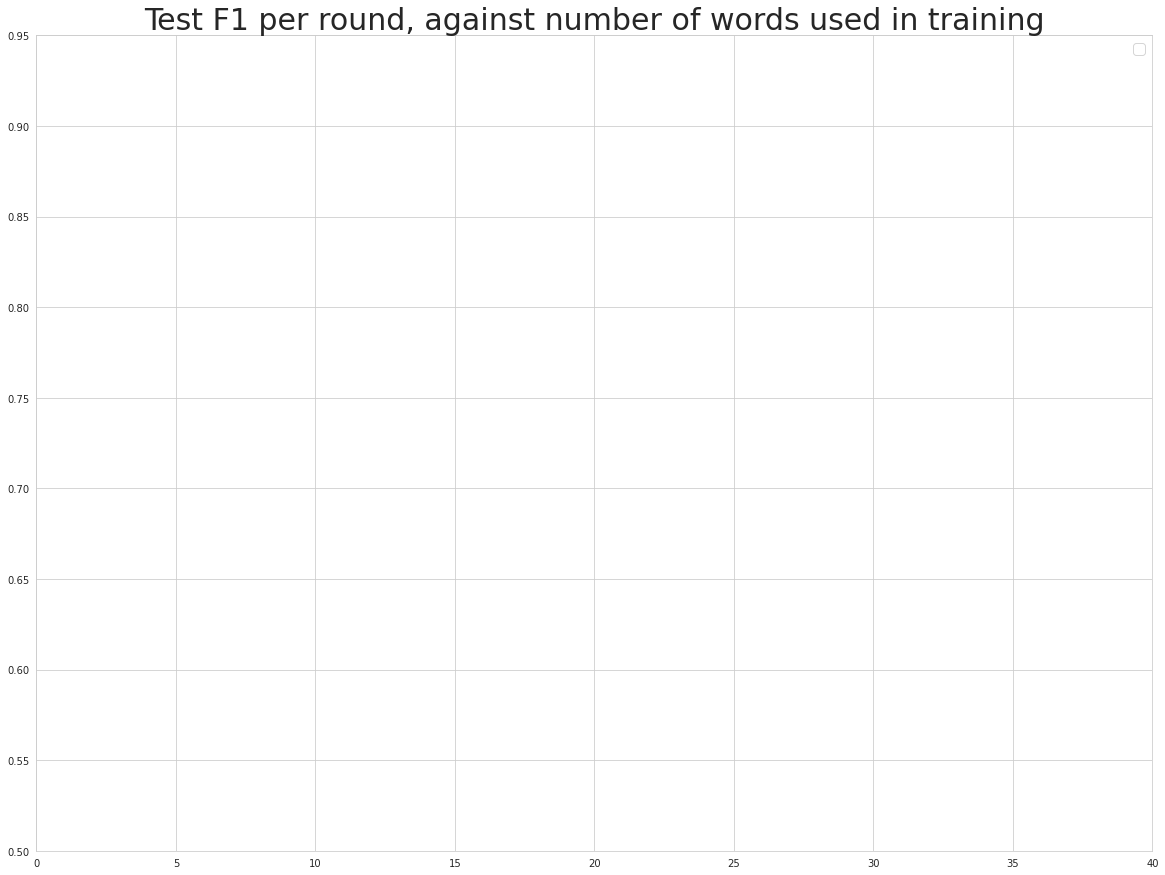

In [23]:
# Data collection & AL curves

acquisitions = ['rand', 'lc'] #, 'maxent']#, 'mnlp'] 
dataset_hint = "OntoNotes-5.0/NER"; window_hint = ['5', '-1']
all_results = {}; roots = []; all_roots = glob(f"*--202*:*")
fig, axs = plt.subplots(1, figsize = (20, 15)); axs = [None, axs]

for root in tqdm(all_roots):
    config_txt = pd.read_csv(os.path.join(root, "config.txt"), sep = "\t")
    base_idx = 0

    _dataset = config_txt.iloc[12][0]
    if "beam_search" in _dataset:
        _beam_search = _dataset
        _dataset = config_txt.iloc[13][0]
    elif "temperature" in _dataset:
        _beam_search = config_txt.iloc[13][0]
        _dataset = config_txt.iloc[14][0]
        base_idx+=1
    else:
        _beam_search = "beam_search 1"
        
    _window_size = config_txt.iloc[base_idx+5][0]
    _acquisition = config_txt.iloc[base_idx+6][0]
    _beta = config_txt.iloc[base_idx+9][0]
    _T = config_txt.iloc[base_idx+11][0]
    _norm = config_txt.iloc[base_idx+10][0]
    _roundsize = config_txt.iloc[base_idx+8][0] 
    _initprop = config_txt.iloc[base_idx+7][0]
    
    if "50000" in _roundsize and "5" in _beam_search:
        print(config_txt)
    
    # name = f"{_roundsize}, {_acquisition}, {_window_size}, {_beta}, {_T}, {_norm}, {_beam_search}"
    name = f"{_dataset.strip('/')} {_acquisition}, {_window_size}, {_beta}, {_norm}, {_beam_search}, {_roundsize}"
    if not all_results.get(name):
        all_results[name] = {
            "roots": [root],
            "num_sentences": [],
            "num_words": [],
            "F1": {"train": [], "val": [], "test": []},
            "times": []
        }
    else:
        all_results[name]["roots"].append(root)

        
for name, results in tqdm(all_results.items()):
    
    roots = results["roots"]

    for root in roots:

        time_made = datetime.datetime.strptime(root.split("--")[-1], "%Y-%m-%d-%H:%M:%S").timestamp()
        records = sorted(glob(os.path.join(root, "round-*")), key = lambda x: int(x.split("-")[-1]))

        all_num_words = []
        all_num_sentences = []
        all_F1s = []
        all_times = []

        acquisition_function = get_acquisition_from_root(root)
        if not acquisition_function:
            continue

        for r_idx, record in enumerate(records):
            try:
                record_tsv = pd.read_csv(os.path.join(record, "record.tsv"), sep = "\t")
            except:
                print(record)
                break
        
            num_words = get_num_words_from_tsv(record_tsv)
            num_sentences = get_num_sentences_from_tsv(record_tsv)
            F1 = get_best_F1_from_tsv(record_tsv)
            
            sentence_prop_path = os.path.join(record, f"sentence_prop-{r_idx}.tsv")
            time_of_record = os.path.getmtime(sentence_prop_path) - time_made

            if num_words in all_num_words:
                break

            all_num_words.append(num_words)
            all_num_sentences.append(num_sentences)
            all_F1s.append(F1)
            all_times.append(time_of_record)
        
        results["times"].append(np.array(all_times))
        results["num_sentences"].append(np.array(all_num_sentences))
        results["num_words"].append(np.array(all_num_words))
        results["F1"]["val"].append(
            np.array([a['val'] for a in all_F1s])
        )
        results["F1"]["train"].append(
            np.array([a['train'] for a in all_F1s])
        )
        results["F1"]["test"].append(
            np.array([a['test'] for a in all_F1s])
        )
        
for ac in all_results.keys():
    continue
    
    line_alpha = 1
    
    if "window ['-1']" and 'acquisition rand' in ac:
        ls = 'dotted'
        alpha = 0
    elif "window ['-1']" in ac and ('acquisition lc' in ac or 'acquisition maxent' in ac):
        ls = 'dashdot'
        alpha = 0
    elif "window ['5']" in ac and 'acquisition rand' in ac:
        ls = 'dashed'
        alpha = 0
    elif "window ['5']" in ac and ('acquisition lc' in ac or 'acquisition maxent' in ac):
        ls = 'solid'
        alpha = 0
    elif "window ['3', '7']" in ac:
        ls = 'solid'
        alpha = 0
    elif "window ['1']" in ac:
        ls = 'dashed'
        alpha = 0
        line_alpha = 0.5
    else:
        assert "baseline" in ac
        perf = diff_size_mean("mean", all_results[ac]["F1"]["val"])
        axs[1].plot([0, 100], [perf,perf], linewidth = 5, alpha = 0.5)
        continue
        
    if "beta 0.0," not in ac:
        continue
    if "10000" not in ac:
        continue
    if "beam_search 1" not in ac:
        continue
    
    print(ac)
    
    num_words = diff_size_mean("mean", all_results[ac]["num_words"], True)[:100]
    val_F1 = diff_size_mean("mean", all_results[ac]["F1"]["val"])[:100]
    
    sns.lineplot(
        x=num_words/17669.55,
        y=val_F1,
        label = ac, linewidth = 5, linestyle=ls, ax = axs[1],
        alpha = line_alpha
    )
    #axs[1].fill_between(
    #    num_words,
    #    diff_size_mean("max", all_results[ac]["F1"]["val"]),
    #    diff_size_mean("min", all_results[ac]["F1"]["val"]),
    #    alpha=alpha
    #)
    del alpha
    del ls

axs[1].set_title("Test F1 per round, against number of words used in training", fontsize = 30)

# axs[0].legend()
axs[1].legend(fontsize = 15)#bbox_to_anchor=(0.7, 0), fontsize=25)
axs[1].set_ylim(0.5, 0.95)
axs[1].set_xlim(0, 40)
# fig.suptitle(f"F1 scores per round for dataset {dataset_hint}")

Single tokens 	 0.938
Full sentences, random 	 0.9369999999999999
Sub-sequence, random 	 0.9283333333333333
Full sentences, LC 	 0.9413333333333332
Full sentences, MNLP 	 0.941
Full sentences, $\alpha = 0.7$ 	 0.9386666666666666
Sub-sequence, LC 	 0.9369999999999999
Sub-sequence, MNLP 	 0.935
Sub-sequence, $\alpha = 0.3$ 	 0.9369999999999999
data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition baseline, window ['-1'], beta 0.0, alpha 0.7, beam_search 1, roundsize 1


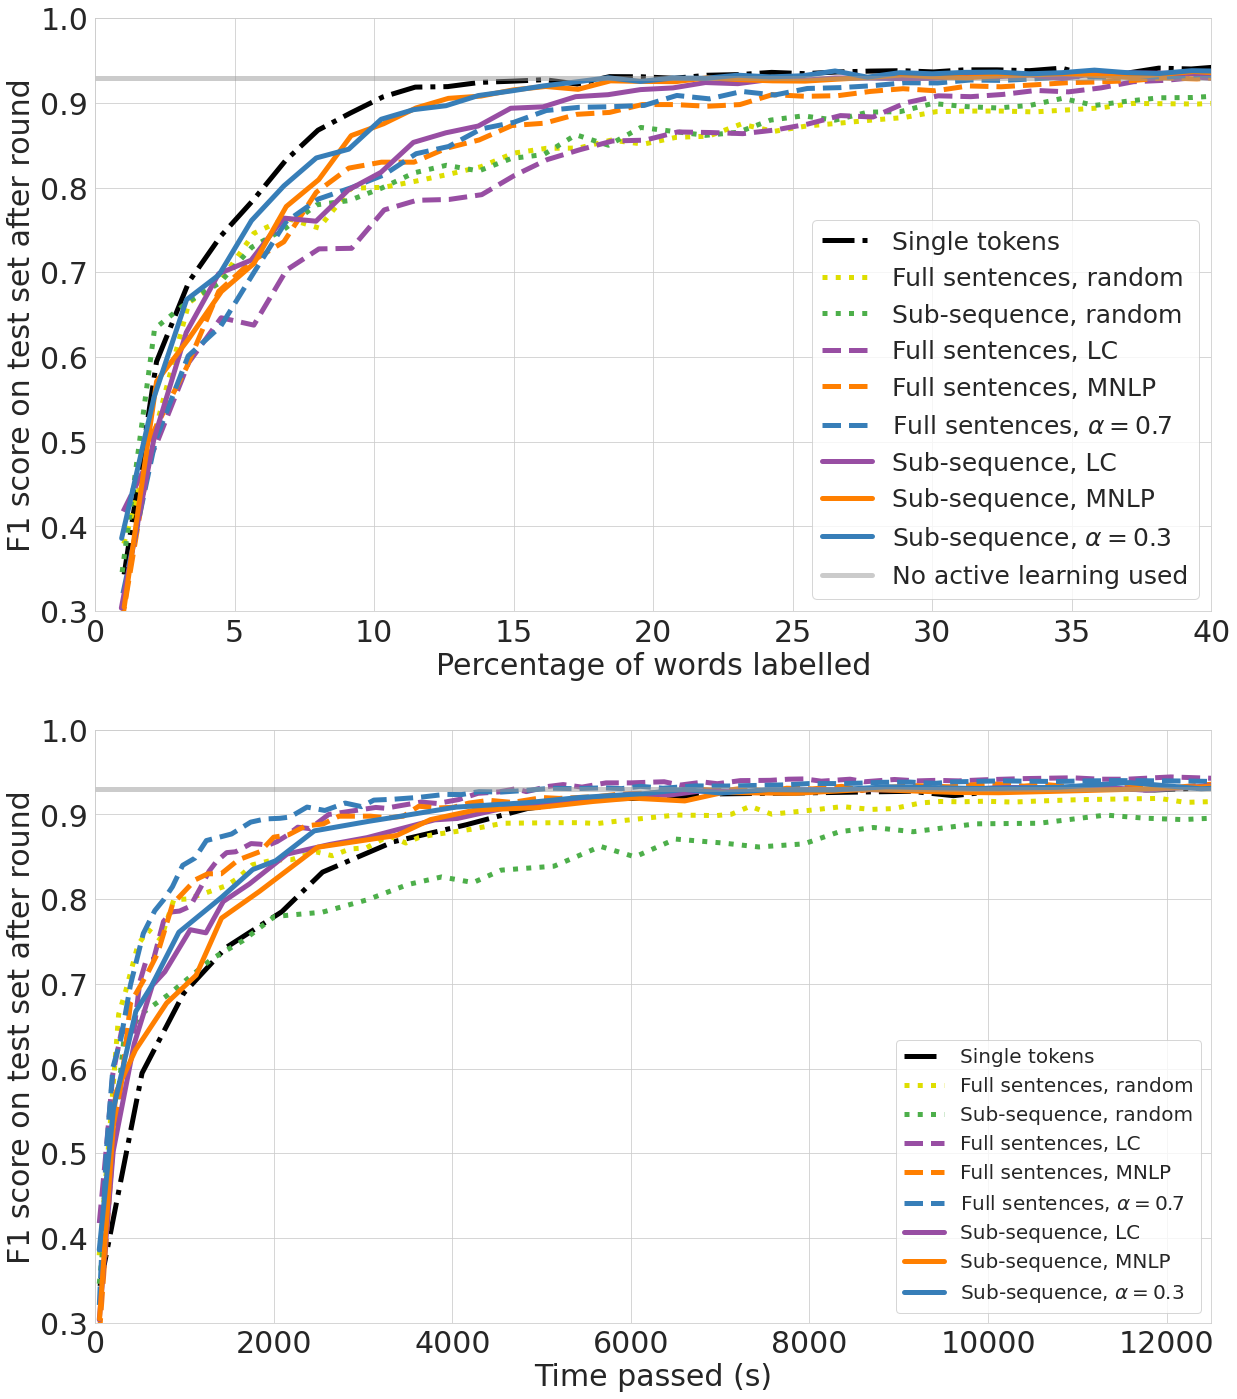

In [562]:
# CONLL LC
from typing import OrderedDict

legend_dict = OrderedDict({
    #"data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['3', '7'], beta 0.0, alpha 0.7, beam_search 1, roundsize 2000": "Sub-sequence, $\\alpha = 0.7$",
    "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['3', '7'], beta 0.0, alpha 0.3, beam_search 1, roundsize 2000": "Sub-sequence, $\\alpha = 0.3$",
    #"data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['3', '7'], beta 0.0, alpha 0.5, beam_search 1, roundsize 2000": "Sub-sequence, $\\alpha = 0.5$",
    "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['3', '7'], beta 0.0, alpha 1.0, beam_search 1, roundsize 2000": "Sub-sequence, MNLP",
    "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['3', '7'], beta 0.0, alpha 0.0, beam_search 1, roundsize 2000": "Sub-sequence, LC",
    "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['-1'], beta 0.0, alpha 0.7, beam_search 1, roundsize 2000": "Full sentences, $\\alpha = 0.7$",
    "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['-1'], beta 0.0, alpha 1.0, beam_search 1, roundsize 2000": "Full sentences, MNLP",
    "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['-1'], beta 0.0, alpha 0.0, beam_search 1, roundsize 2000": "Full sentences, LC",
    "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition rand, window ['3', '7'], beta 0.0, alpha 1.0, beam_search 1, roundsize 2000": "Sub-sequence, random",
    "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition rand, window ['-1'], beta 0.0, alpha 1.0, beam_search 1, roundsize 2000": "Full sentences, random",
    "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['1'], beta 0.0, alpha 0.0, beam_search 1, roundsize 2000": "Single tokens",
    #"data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['1', '100'], beta 0.0, alpha 0.3, beam_search 1, roundsize 2000": "Unbounded, $\\alpha = 0.3$"
    
})

fig, axs = plt.subplots(2, figsize = (20, 24))

styles = 3*["solid"] + 3*["dashed"] +  2*["dotted"] + ["dashdot"]#*2
colors =['#377eb8', '#ff7f00', '#984ea3', '#377eb8', '#ff7f00', '#984ea3','#4daf4a','#dede00', 'black']#, "brown"]

styles = styles[::-1]
colors = colors[::-1]

for i, (ac, label) in enumerate(list(legend_dict.items())[::-1]):
      
    num_words = diff_size_mean("mean", all_results[ac]["num_words"])
    time = diff_size_mean("mean", all_results[ac]["times"])
    val_F1 = diff_size_mean("mean", all_results[ac]["F1"]["val"])
    
    sns.lineplot(
        x=num_words/1722.10,
        y=val_F1,
        label = label,
        linewidth = 5, 
        linestyle = styles[i],
        color = colors[i],
        ax = axs[0]
    )
    sns.lineplot(
        x=time,
        y=val_F1,
        label = label,
        linewidth = 5, 
        linestyle = styles[i],
        color = colors[i],
        ax = axs[1]
    )
    
    print(label, '\t', val_F1[-1])
    

baselines = [] 

for ac in all_results.keys():
    if "baseline" in ac and "conll" in ac:
        print(ac)
        baselines.extend([float(a) for a in all_results[ac]["F1"]["val"]])
        
perf = sum(baselines)/len(baselines)

axs[0].set_ylim(0.3, 1)
axs[0].set_xlim(0, 40)
axs[0].plot([0, 40], [perf,perf], linewidth = 5, alpha = 0.5, label = "No active learning used", color = '#999999')
axs[0].legend(fontsize = 25)
        
axs[1].legend(fontsize = 20)#bbox_to_anchor=(0.7, 0), fontsize=25)
axs[1].set_ylim(0.3, 1)
axs[1].set_xlim(0, 12500)
axs[1].plot([0, 12500], [perf,perf], linewidth = 5, alpha = 0.5, label = "No active learning used", color = '#999999')

ax = axs[0]
ax.set_xlabel("Percentage of words labelled")
ax.set_ylabel("F1 score on test set after round")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)
    
ax = axs[1]
ax.set_xlabel("Time passed (s)")
ax.set_ylabel("F1 score on test set after round")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)

In [572]:
all_results[[k for k in all_results if 'baseline' in k and 'conll2003' in k][0]]

{'roots': ['-W--1--A-baseline--T-1--alpha-0.7---beta-0--R-1--B-1--I-1---epochs-50---earlystopping-100---data_path-homepradmardreposdataCONLLconll2003--2021-01-01-19:21:57',
  '-W--1--A-baseline--T-1--alpha-0.7---beta-0--R-1--B-1--I-1---epochs-100---earlystopping-20---data_path-homepradmardreposdataCONLLconll2003--2021-01-07-10:58:52',
  '-W--1--A-baseline--T-1--alpha-0.7---beta-0--R-1--B-1--I-1---epochs-50---earlystopping-100---data_path-homepradmardreposdataCONLLconll2003--2021-01-01-22:35:17'],
 'num_sentences': [array([13553]), array([13553]), array([13553])],
 'num_words': [array([170475]), array([170475]), array([170475])],
 'F1': {'train': [array([0.99]), array([0.997]), array([0.989])],
  'val': [array([0.929]), array([0.933]), array([0.927])]},
 'times': [array([3672.79576826]),
  array([8189.49020195]),
  array([3591.84019804])]}

Single tokens 	 0.938
Full sentences, random 	 0.9369999999999999
Sub-sequence, random 	 0.9283333333333333
Full sentences, $\alpha = 0$ 	 0.9413333333333332
Full sentences, $\alpha = 0.7$ 	 0.9386666666666666
Full sentences, $\alpha = 1$ 	 0.941
Sub-sequence, $\alpha = 0$ 	 0.9369999999999999
Sub-sequence, $\alpha = 0.5$ 	 0.9375
Sub-sequence, $\alpha = 1$ 	 0.935
data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition baseline, window ['-1'], beta 0.0, alpha 0.7, beam_search 1, roundsize 1


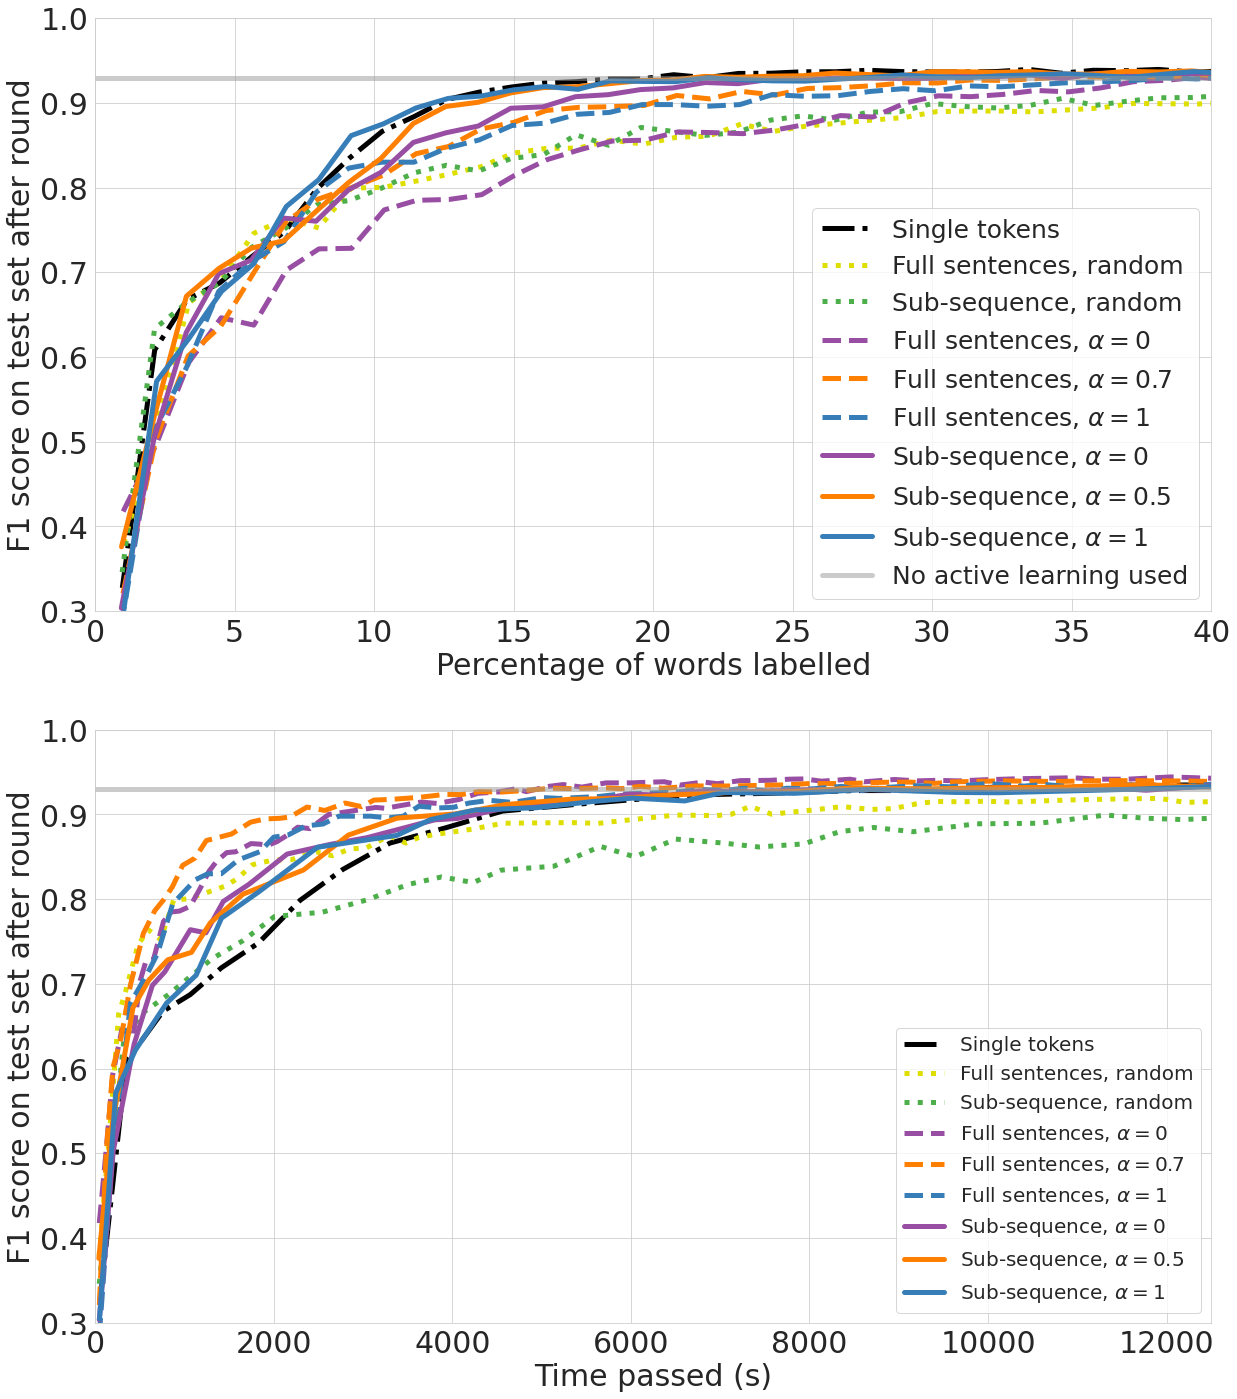

In [561]:
# CONLL MaxEnt
from typing import OrderedDict

legend_dict = OrderedDict({
    "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['3', '7'], beta 0.0, alpha 1.0, beam_search 1, roundsize 2000": "Sub-sequence, $\\alpha = 1$",
    "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['3', '7'], beta 0.0, alpha 0.5, beam_search 1, roundsize 2000": "Sub-sequence, $\\alpha = 0.5$",
    "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['3', '7'], beta 0.0, alpha 0.0, beam_search 1, roundsize 2000": "Sub-sequence, $\\alpha = 0$",
    "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['-1'], beta 0.0, alpha 1.0, beam_search 1, roundsize 2000": "Full sentences, $\\alpha = 1$",
    "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['-1'], beta 0.0, alpha 0.7, beam_search 1, roundsize 2000": "Full sentences, $\\alpha = 0.7$",
    "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['-1'], beta 0.0, alpha 0.0, beam_search 1, roundsize 2000": "Full sentences, $\\alpha = 0$",
    "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition rand, window ['3', '7'], beta 0.0, alpha 1.0, beam_search 1, roundsize 2000": "Sub-sequence, random",
    "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition rand, window ['-1'], beta 0.0, alpha 1.0, beam_search 1, roundsize 2000": "Full sentences, random",
    "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition maxent, window ['1'], beta 0.0, alpha 0.0, beam_search 1, roundsize 2000": "Single tokens",
    #"data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition maxent, window ['1', '100'], beta 0.0, alpha 0.5, beam_search 1, roundsize 2000": "Unbounded, $\\alpha = 0.5$"
})

fig, axs = plt.subplots(2, figsize = (20, 24))

styles = 3*["solid"] + 3*["dashed"] +  2*["dotted"] + ["dashdot"]#*2
colors =['#377eb8', '#ff7f00', '#984ea3', '#377eb8', '#ff7f00', '#984ea3','#4daf4a','#dede00', 'black']#, "brown"]

styles = styles[::-1]
colors = colors[::-1]

for i, (ac, label) in enumerate(list(legend_dict.items())[::-1]):
    
    num_words = diff_size_mean("mean", all_results[ac]["num_words"])
    time = diff_size_mean("mean", all_results[ac]["times"])
    val_F1 = diff_size_mean("mean", all_results[ac]["F1"]["val"])
    
    sns.lineplot(
        x=num_words/1722.10,
        y=val_F1,
        label = label,
        linewidth = 5, 
        linestyle = styles[i],
        color = colors[i],
        ax = axs[0]
    )
    sns.lineplot(
        x=time,
        y=val_F1,
        label = label,
        linewidth = 5, 
        linestyle = styles[i],
        color = colors[i],
        ax = axs[1]
    )
    
    print(label, '\t', val_F1[-1])
    

baselines = [] 

for ac in all_results.keys():
    if "baseline" in ac and "conll" in ac:
        print(ac)
        baselines.extend([float(a) for a in all_results[ac]["F1"]["val"]])
        continue
        
perf = sum(baselines)/len(baselines)

axs[0].set_ylim(0.3, 1)
axs[0].set_xlim(0, 40)
axs[0].plot([0, 40], [perf,perf], linewidth = 5, alpha = 0.5, label = "No active learning used", color = '#999999')
axs[0].legend(fontsize = 25)
        
axs[1].legend(fontsize = 20)#bbox_to_anchor=(0.7, 0), fontsize=25)
axs[1].set_ylim(0.3, 1)
axs[1].set_xlim(0, 12500)
axs[1].plot([0, 12500], [perf,perf], linewidth = 5, alpha = 0.5, label = "No active learning used", color = '#999999')

ax = axs[0]
ax.set_xlabel("Percentage of words labelled")
ax.set_ylabel("F1 score on test set after round")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)
    
ax = axs[1]
ax.set_xlabel("Time passed (s)")
ax.set_ylabel("F1 score on test set after round")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)

Single tokens 	 0.843
Full sentences, random 	 0.83
Sub-sequence, random 	 0.8245
Full sentences, LC 	 0.845
Full sentences, MNLP 	 0.843
Full sentences, $\alpha = 0.7$ 	 0.842
Sub-sequence, LC 	 0.845
Sub-sequence, MNLP 	 0.849
Sub-sequence, $\alpha = 0.7$ 	 0.84
data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition baseline, window ['-1'], beta 0.0, alpha 0.3, beam_search 1, roundsize 50000


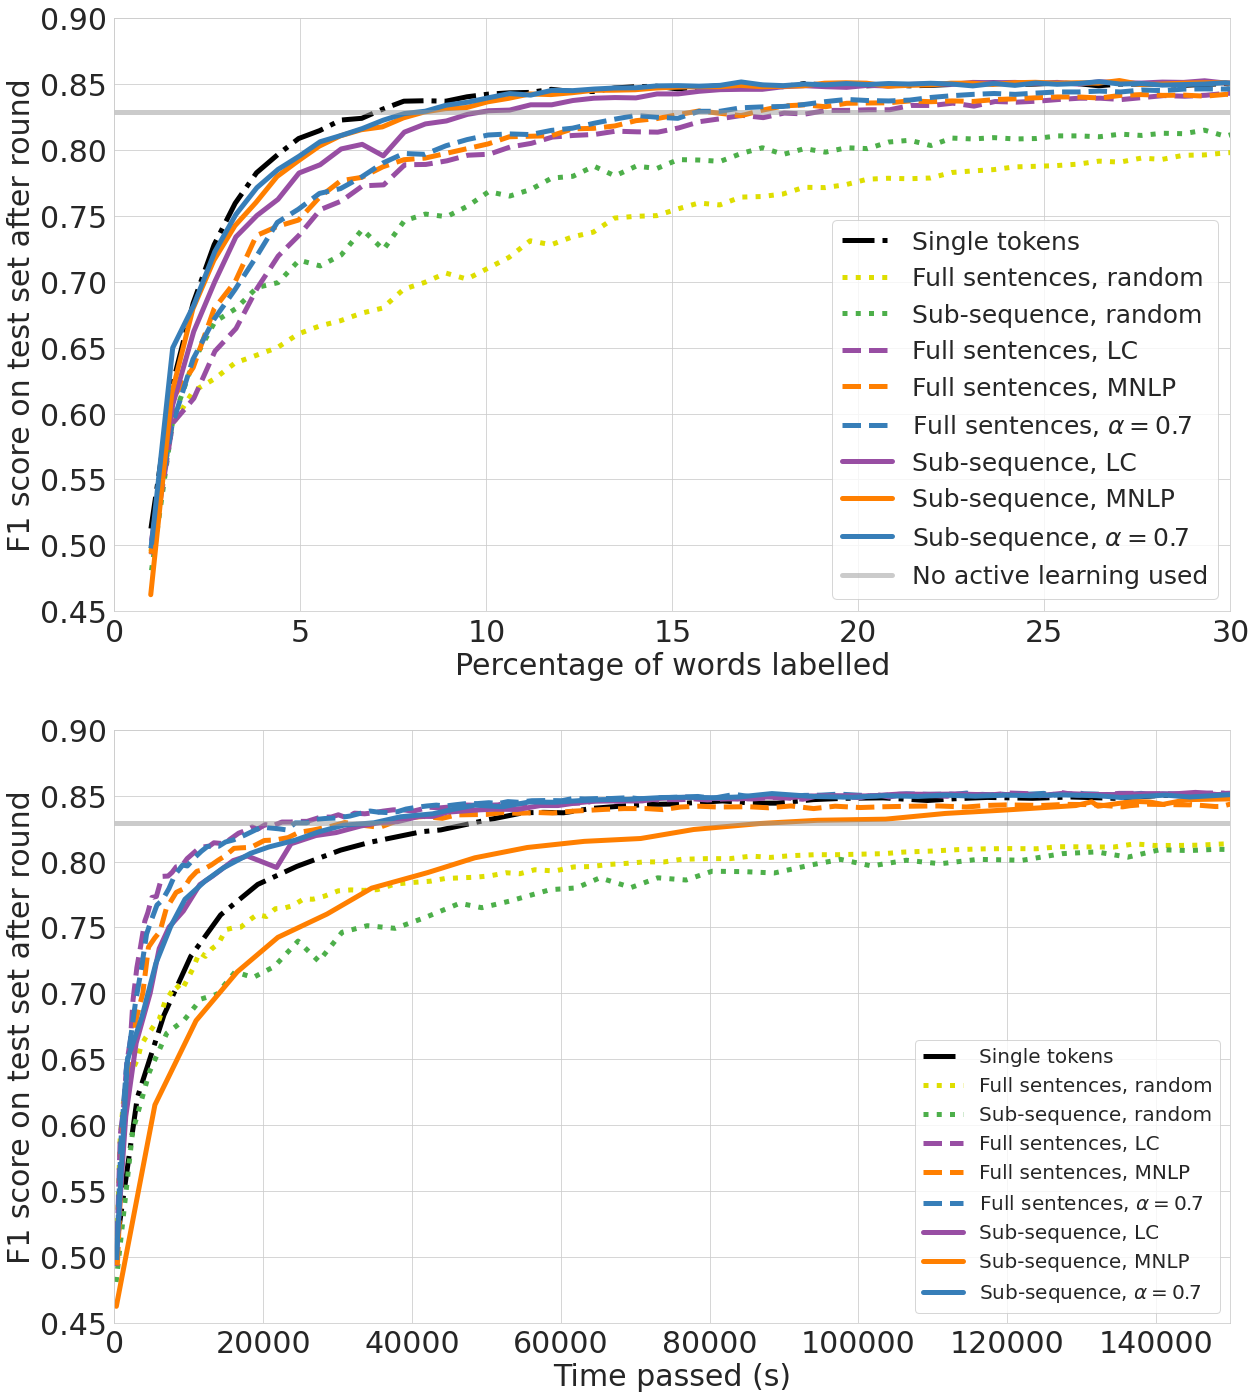

In [557]:
# ONTONOTES LC
from typing import OrderedDict

legend_dict = OrderedDict({
    "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition lc, window ['3', '7'], beta 0.0, alpha 0.7, beam_search 1, roundsize 10000": "Sub-sequence, $\\alpha = 0.7$",
    "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition lc, window ['3', '7'], beta 0.0, alpha 1.0, beam_search 1, roundsize 10000": "Sub-sequence, MNLP",
    "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition lc, window ['3', '7'], beta 0.0, alpha 0.0, beam_search 1, roundsize 10000": "Sub-sequence, LC",
    "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition lc, window ['-1'], beta 0.0, alpha 0.7, beam_search 1, roundsize 10000": "Full sentences, $\\alpha = 0.7$",
    "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition lc, window ['-1'], beta 0.0, alpha 1.0, beam_search 1, roundsize 10000": "Full sentences, MNLP",
    "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition lc, window ['-1'], beta 0.0, alpha 0.0, beam_search 1, roundsize 10000": "Full sentences, LC",
    "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition rand, window ['3', '7'], beta 0.0, alpha 1.0, beam_search 1, roundsize 10000": "Sub-sequence, random",
    "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition rand, window ['-1'], beta 0.0, alpha 1.0, beam_search 1, roundsize 10000": "Full sentences, random",
    "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition lc, window ['1'], beta 0.0, alpha 0.0, beam_search 1, roundsize 10000": "Single tokens",
    # "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition lc, window ['1', '100'], beta 0.0, alpha 0.7, beam_search 1, roundsize 10000": "Unbounded, $\\alpha = 0.7$"
})

fig, axs = plt.subplots(2, figsize = (20, 24))

styles = 3*["solid"] + 3*["dashed"] +  2*["dotted"] + ["dashdot"]#*2
colors =['#377eb8', '#ff7f00', '#984ea3', '#377eb8', '#ff7f00', '#984ea3','#4daf4a','#dede00', 'black']#, "brown"]

styles = styles[::-1]
colors = colors[::-1]

for i, (ac, label) in enumerate(list(legend_dict.items())[::-1]):
    
    num_words = diff_size_mean("mean", all_results[ac]["num_words"])
    time = diff_size_mean("mean", all_results[ac]["times"])
    val_F1 = diff_size_mean("mean", all_results[ac]["F1"]["val"])
    
    sns.lineplot(
        x=num_words/17669.55,
        y=val_F1,
        label = label,
        linewidth = 5, 
        linestyle = styles[i],
        color = colors[i],
        ax = axs[0]
    )
    sns.lineplot(
        x=time,
        y=val_F1,
        label = label,
        linewidth = 5, 
        linestyle = styles[i],
        color = colors[i],
        ax = axs[1]
    )
    
    print(label, '\t', val_F1[-1])

baselines = [] 

for ac in all_results.keys():
    if "baseline" in ac and "conll" not in ac:
        print(ac)
        baselines.extend([float(a) for a in all_results[ac]["F1"]["val"]])
        continue
        
perf = sum(baselines)/len(baselines)

axs[0].set_ylim(0.45, 0.9)
axs[0].set_xlim(0, 30)
axs[0].plot([0, 30], [perf,perf], linewidth = 5, alpha = 0.5, label = "No active learning used", color = '#999999')
axs[0].legend(fontsize = 25)
        
axs[1].legend(fontsize = 20)#bbox_to_anchor=(0.7, 0), fontsize=25)
axs[1].set_ylim(0.45, 0.9)
axs[1].set_xlim(0, 150000)
axs[1].plot([0, 150000], [perf,perf], linewidth = 5, alpha = 0.5, label = "No active learning used", color = '#999999')

ax = axs[0]
ax.set_xlabel("Percentage of words labelled")
ax.set_ylabel("F1 score on test set after round")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)
    
ax = axs[1]
ax.set_xlabel("Time passed (s)")
ax.set_ylabel("F1 score on test set after round")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)


Single tokens 	 0.844
Full sentences, random 	 0.83
Sub-sequence, random 	 0.8245
Full sentences, $\alpha = 0$ 	 0.85
Full sentences, $\alpha = 1$ 	 0.85
Sub-sequence, $\alpha = 0$ 	 0.849
Sub-sequence, $\alpha = 1$ 	 0.845
data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition baseline, window ['-1'], beta 0.0, alpha 0.3, beam_search 1, roundsize 50000


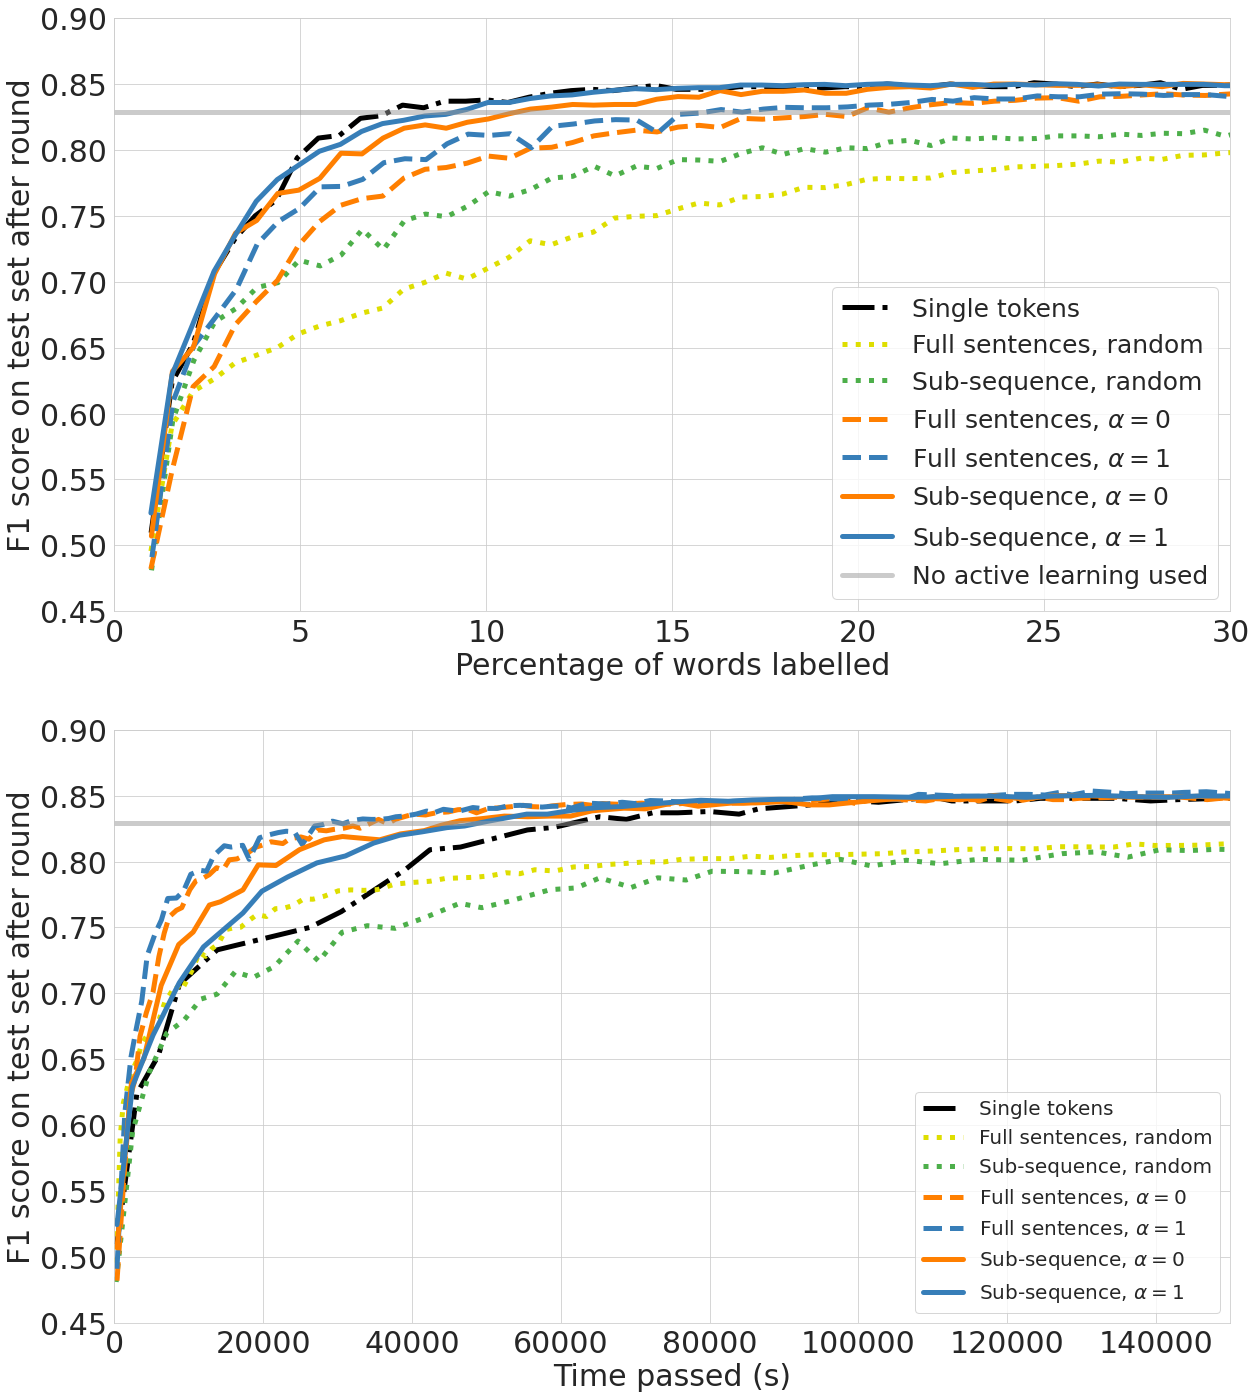

In [656]:
# ONTONOTES MAXENT
from typing import OrderedDict

legend_dict = OrderedDict({
    #"data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition maxent, window ['3', '7'], beta 0.0, alpha 0.7, beam_search 1, roundsize 10000": "Sub-sequence, $\\alpha = 0.7$",
    #"data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition maxent, window ['3', '7'], beta 0.0, alpha 0.3, beam_search 1, roundsize 10000": "Sub-sequence, $\\alpha = 0.3$",
    #"data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition maxent, window ['3', '7'], beta 0.0, alpha 0.5, beam_search 1, roundsize 10000": "Sub-sequence, $\\alpha = 0.5$",
    "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition maxent, window ['3', '7'], beta 0.0, alpha 1.0, beam_search 1, roundsize 10000": "Sub-sequence, $\\alpha = 1$",
    "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition maxent, window ['3', '7'], beta 0.0, alpha 0.0, beam_search 1, roundsize 10000": "Sub-sequence, $\\alpha = 0$",
    #"data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition maxent, window ['-1'], beta 0.0, alpha 0.7, beam_search 1, roundsize 10000": "Full sentences, $\\alpha = 0.7$",
    #"data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition maxent, window ['-1'], beta 0.0, alpha 0.3, beam_search 1, roundsize 10000": "Full sentences, $\\alpha = 0.3$",
    #"data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition maxent, window ['-1'], beta 0.0, alpha 0.5, beam_search 1, roundsize 10000": "Full sentences, $\\alpha = 0.5$",
    "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition maxent, window ['-1'], beta 0.0, alpha 1.0, beam_search 1, roundsize 10000": "Full sentences, $\\alpha = 1$",
    "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition maxent, window ['-1'], beta 0.0, alpha 0.0, beam_search 1, roundsize 10000": "Full sentences, $\\alpha = 0$",
    "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition rand, window ['3', '7'], beta 0.0, alpha 1.0, beam_search 1, roundsize 10000": "Sub-sequence, random",
    "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition rand, window ['-1'], beta 0.0, alpha 1.0, beam_search 1, roundsize 10000": "Full sentences, random",
    "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition maxent, window ['1'], beta 0.0, alpha 0.0, beam_search 1, roundsize 10000": "Single tokens",
    #"data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition maxent, window ['1', '100'], beta 0.0, alpha 0.9, beam_search 1, roundsize 10000": "Unbounded, $\\alpha = 0.9$"
})

fig, axs = plt.subplots(2, figsize = (20, 24))

styles = 2*["solid"] + 2*["dashed"] +  2*["dotted"] + ["dashdot"]#*2
colors =['#377eb8', '#ff7f00', '#377eb8', '#ff7f00', '#4daf4a', '#dede00', 'black']#, "brown"]

styles = styles[::-1]
colors = colors[::-1]

for i, (ac, label) in enumerate(list(legend_dict.items())[::-1]):
    
    num_words = diff_size_mean("mean", all_results[ac]["num_words"])
    time = diff_size_mean("mean", all_results[ac]["times"])
    val_F1 = diff_size_mean("mean", all_results[ac]["F1"]["val"])
    
    sns.lineplot(
        x=num_words/17669.55,
        y=val_F1,
        label = label,
        linewidth = 5, 
        linestyle = styles[i],
        color = colors[i],
        ax = axs[0]
    )
    sns.lineplot(
        x=time,
        y=val_F1,
        label = label,
        linewidth = 5, 
        linestyle = styles[i],
        color = colors[i],
        ax = axs[1]
    )
    print(label, '\t', val_F1[-1])
    
baselines = [] 

for ac in all_results.keys():
    if "baseline" in ac and "conll" not in ac:
        print(ac)
        baselines.extend([float(a) for a in all_results[ac]["F1"]["val"]])
        continue
        
perf = sum(baselines)/len(baselines)

axs[0].set_ylim(0.45, 0.9)
axs[0].set_xlim(0, 30)
axs[0].plot([0, 30], [perf,perf], linewidth = 5, alpha = 0.5, label = "No active learning used", color = '#999999')
axs[0].legend(fontsize = 25)
        
axs[1].legend(fontsize = 20)#bbox_to_anchor=(0.7, 0), fontsize=25)
axs[1].set_ylim(0.45, 0.9)
axs[1].set_xlim(0, 150000)
axs[1].plot([0, 150000], [perf,perf], linewidth = 5, alpha = 0.5, label = "No active learning used", color = '#999999')

ax = axs[0]
ax.set_xlabel("Percentage of words labelled")
ax.set_ylabel("F1 score on test set after round")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)
    
ax = axs[1]
ax.set_xlabel("Time passed (s)")
ax.set_ylabel("F1 score on test set after round")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)

In [24]:
import pandas as pd
from sklearn.metrics import auc

norm_auc = lambda x, y: auc(x, y)/(max(x)-min(x))

def norm_auc_auto(result, all_words, end_words_prop, min_words_prop):
    end_words = all_words*end_words_prop
    min_words = all_words*min_words_prop
    scores = []
    print(result["F1"].keys())
    for i in range(len(result['F1']['test'])):
        extended_curve = list(result['F1']['test'][i])
        extended_base = list(result['num_words'][i])
        if not len(extended_curve) or extended_base[-1] < min_words:
            continue
        if extended_base[-1] >= end_words:
            extended_base = [e for e in extended_base if e <= end_words]
            extended_curve = extended_curve[:len(extended_base)]
        extended_curve.append(extended_curve[-1])
        extended_base.append(end_words)
        score = norm_auc(extended_base, extended_curve).round(4)
        scores.append(score)
    return scores

def get_score_range(scores):
    if len(scores) == 0:
        return "N/A"
    elif len(scores) == 1:
        return str(scores)
    else:
        mean = sum(scores)/len(scores)
        rng = max([max(scores)-mean,mean-min(scores)])
        return f"{mean.round(4)} \u00B1 {rng.round(4)}"
    
def ranker(l):
    if l:
        return sum(l)/len(l)
    else:
        return 0
    
results_df_onto = pd.DataFrame(columns = ["Acquisition Function", "Window sized", "alpha", "Normalised AUC", "All scores", ])

for ac in all_results:
    acq_func = ac.split("acquisition ")[-1].split(",")[0]
    if "Onto" not in ac or "baseline" in acq_func:
        continue
    if "rand" in acq_func:
        print(ac)
    win_size = ac.split("window [")[-1].split("]")[0]
    beta = ac.split("beta ")[-1].split(",")[0]
    alpha = ac.split("alpha ")[-1].split(",")[0]
    B = ac.split("beam_search ")[-1].split(",")[0]
    roundsize = ac.split("roundsize ")[-1].split(",")[0]
    try:
        all_scores = norm_auc_auto(all_results[ac], 1766955, 0.3, 0.2)
    except Exception as e:
        print("asf")
        continue
    score_range = get_score_range(all_scores)
    if win_size == '1':
        alpha = 0.0
    
    if "5" in roundsize or "1" in beta or "5" in B:
        continue
    
    results_df_onto.loc[len(results_df_onto)] = [acq_func, win_size, alpha, score_range, all_scores]
results_df_onto["ranker"] = results_df_onto["All scores"].map(ranker)
results_df_onto = results_df_onto.sort_values("ranker", ascending=False)
results_df_onto

dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition rand, window ['3', '7'], beta 0.0, alpha 1.0, beam_search 1, roundsize 10000
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition rand, window ['-1'], beta 0.0, alpha 1.0, beam_search 1, roundsize 10000
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test']

Acquisition Function Window sized alpha   Normalised AUC  \
19                   lc   '1', '100'   0.7  0.8274 ± 0.0021   
3                    lc          '1'   0.0   0.826 ± 0.0023   
1                    lc     '3', '7'   0.7  0.8259 ± 0.0025   
28                   lc     '3', '7'   1.0   0.8236 ± 0.001   
18               maxent   '1', '100'   0.9  0.8234 ± 0.0028   
4                    lc     '3', '7'   0.3   0.823 ± 0.0032   
21               maxent     '3', '7'   1.0  0.8227 ± 0.0011   
9                    lc     '3', '7'   0.2   0.822 ± 0.0009   
7                    lc     '3', '7'   0.5  0.8214 ± 0.0013   
24               maxent     '3', '7'   0.7  0.8213 ± 0.0012   
6                maxent          '1'   0.0  0.8212 ± 0.0027   
5                maxent     '3', '7'   0.5  0.8208 ± 0.0005   
22               maxent     '3', '7'   0.3  0.8197 ± 0.0018   
12                   lc     '3', '7'   0.0  0.8188 ± 0.0007   
23               maxent     '3', '7'   0.0  0.8168 ± 0.0002   
17                   lc         '-1'   0.7  0.8036 ± 0.0031   
25               maxent         '-1'   1.0  0.8026 ± 0.0016   
20                   lc         '-1'   1.0  0.8017 ± 0.0029   
27                   lc         '-1'   0.5  0.8011 ± 0.0016   
10               maxent         '-1'   0.5  0.8006 ± 0.0031   
15               maxent         '-1'   0.7     0.8 ± 0.0059   
16                   lc         '-1'   0.3  0.7971 ± 0.0063   
8                maxent         '-1'   0.3  0.7949 ± 0.0031   
2                    lc         '-1'   0.0   0.7941 ± 0.001   
13               maxent         '-1'   0.0  0.7907 ± 0.0005   
11                 rand     '3', '7'   1.0  0.7683 ± 0.0032   
14                 rand         '-1'   1.0  0.7344 ± 0.0074   
0                maxent   '1', '100'   1.0              N/A   
26                   lc          '1'   0.0              N/A   
29               maxent          '1'   0.0              N/A   

                                           All scores    ranker  
19                   [0.8276, 0.8253, 0.8294, 0.8273]  0.827400  
3   [0.8271, 0.8278, 0.8257, 0.8274, 0.8278, 0.823...  0.826038  
1             [0.8268, 0.8283, 0.826, 0.8252, 0.8234]  0.825940  
28                           [0.8241, 0.8226, 0.8242]  0.823633  
18                   [0.8255, 0.8254, 0.8206, 0.8222]  0.823425  
4                     [0.823, 0.8216, 0.8213, 0.8263]  0.823050  
21                   [0.8219, 0.8238, 0.8219, 0.8233]  0.822725  
9                            [0.8215, 0.8217, 0.8229]  0.822033  
7                    [0.8217, 0.8201, 0.8217, 0.8222]  0.821425  
24                            [0.8225, 0.8204, 0.821]  0.821300  
6   [0.8223, 0.8213, 0.8198, 0.8239, 0.8189, 0.822...  0.821229  
5                            [0.8207, 0.8203, 0.8213]  0.820767  
22                   [0.8179, 0.8203, 0.8212, 0.8194]  0.819700  
12                    [0.8183, 0.8195, 0.8185, 0.819]  0.818825  
23                                    [0.8166, 0.817]  0.816800  
17   [0.8043, 0.8028, 0.8065, 0.8005, 0.8032, 0.8043]  0.803600  
25                            [0.8042, 0.8027, 0.801]  0.802633  
20           [0.8008, 0.8006, 0.8034, 0.7993, 0.8046]  0.801740  
27                           [0.8027, 0.8009, 0.7997]  0.801100  
10  [0.8027, 0.8009, 0.799, 0.8015, 0.8005, 0.7993...  0.800644  
15                   [0.7998, 0.7967, 0.7977, 0.8059]  0.800025  
16  [0.7988, 0.7967, 0.7952, 0.7908, 0.8001, 0.8, ...  0.797086  
8   [0.7922, 0.7975, 0.7918, 0.798, 0.7941, 0.7969...  0.794886  
2                    [0.7941, 0.7932, 0.7951, 0.7941]  0.794125  
13                           [0.7905, 0.7905, 0.7912]  0.790733  
11                           [0.7676, 0.7658, 0.7715]  0.768300  
14  [0.7415, 0.7367, 0.7361, 0.7326, 0.7281, 0.739...  0.734421  
0                                                  []  0.000000  
26                                                 []  0.000000  
29                                                 []  0.000000

In [25]:
results_df_conll = pd.DataFrame(columns = ["Acquisition Function", "Window sized", "alpha", "Normalised AUC", "All scores"])

for ac in all_results:
    if "CONLL" not in ac:
        continue
    acq_func = ac.split("acquisition ")[-1].split(",")[0]
    if "baseline" in acq_func:
        continue
    win_size = ac.split("window [")[-1].split("]")[0]
    beta = ac.split("beta ")[-1].split(",")[0]
    alpha = ac.split("alpha ")[-1].split(",")[0]
    B = ac.split("beam_search ")[-1].split(",")[0]
    roundsize = ac.split("roundsize ")[-1].split(",")[0]
    all_scores = norm_auc_auto(all_results[ac], 172210, 0.6, 0.4)
    score_range = get_score_range(all_scores)
    if win_size == "'1'":
        alpha = float(0.0)
        print("asdf")
    
    if "5" in roundsize or "1" in beta or "5" in B:
        continue
    
    results_df_conll.loc[len(results_df_conll)] = [acq_func, win_size, alpha, score_range, all_scores]
results_df_conll["ranker"] = results_df_conll["All scores"].map(ranker)
results_df_conll = results_df_conll.sort_values("ranker", ascending=False)
results_df_conll

dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
asdf
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
asdf
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
asdf
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['train', 'val', 'test'])
dict_keys(['t

Acquisition Function Window sized alpha   Normalised AUC  \
23                   lc          '1'     0  0.9062 ± 0.0059   
10                   lc          '1'     0  0.9055 ± 0.0017   
3                maxent          '1'     0  0.8984 ± 0.0054   
2                    lc     '3', '7'   0.3   0.898 ± 0.0044   
17               maxent     '3', '7'   0.5  0.8941 ± 0.0031   
11                   lc     '3', '7'   1.0  0.8926 ± 0.0025   
19                   lc     '3', '7'   0.5  0.8925 ± 0.0025   
5                maxent     '3', '7'   0.7  0.8914 ± 0.0048   
1                maxent     '3', '7'   1.0     0.89 ± 0.005   
25                   lc     '3', '7'   0.7    0.89 ± 0.0039   
20               maxent     '3', '7'   0.3   0.8898 ± 0.001   
9                maxent     '3', '7'   0.0  0.8862 ± 0.0044   
28               maxent          '1'     0         [0.8859]   
6                    lc     '3', '7'   0.0  0.8843 ± 0.0027   
26               maxent         '-1'   1.0  0.8819 ± 0.0031   
21                   lc         '-1'   0.7  0.8788 ± 0.0074   
12                   lc         '-1'   1.0  0.8749 ± 0.0085   
15                   lc   '1', '100'   0.3   0.874 ± 0.0071   
14               maxent         '-1'   0.7  0.8732 ± 0.0036   
22                   lc         '-1'   0.5  0.8691 ± 0.0119   
13               maxent         '-1'   0.5  0.8633 ± 0.0108   
4                maxent   '1', '100'   0.5   0.863 ± 0.0217   
8                    lc         '-1'   0.3  0.8625 ± 0.0048   
7                  rand     '3', '7'   1.0  0.8601 ± 0.0062   
24                   lc         '-1'   0.0  0.8568 ± 0.0081   
27                 rand         '-1'   1.0   0.8541 ± 0.007   
16               maxent         '-1'   0.3    0.85 ± 0.0083   
0                maxent         '-1'   0.0  0.8414 ± 0.0158   
29                 rand         '-1'   1.0         [0.8239]   
18                 rand     '3', '7'   1.0         [0.8096]   

                                           All scores    ranker  
23           [0.9055, 0.9069, 0.9121, 0.9062, 0.9005]  0.906240  
10                                   [0.9038, 0.9072]  0.905500  
3   [0.8938, 0.9018, 0.8945, 0.8991, 0.893, 0.9018...  0.898438  
2                            [0.9024, 0.8975, 0.8942]  0.898033  
17                           [0.8972, 0.8919, 0.8931]  0.894067  
11                           [0.8934, 0.8901, 0.8943]  0.892600  
19                    [0.8911, 0.8904, 0.8936, 0.895]  0.892525  
5                            [0.8907, 0.8872, 0.8962]  0.891367  
1                             [0.8891, 0.895, 0.8859]  0.890000  
25                           [0.8861, 0.8927, 0.8911]  0.889967  
20                           [0.8889, 0.8898, 0.8908]  0.889833  
9                             [0.889, 0.8818, 0.8877]  0.886167  
28                                           [0.8859]  0.885900  
6                             [0.8843, 0.887, 0.8817]  0.884333  
26                            [0.8829, 0.884, 0.8788]  0.881900  
21                   [0.8714, 0.8799, 0.8839, 0.8798]  0.878750  
12                   [0.8693, 0.8785, 0.8834, 0.8685]  0.874925  
15           [0.8754, 0.8682, 0.8811, 0.8756, 0.8697]  0.874000  
14                           [0.8712, 0.8716, 0.8768]  0.873200  
22                    [0.8572, 0.8775, 0.8658, 0.876]  0.869125  
13                   [0.8525, 0.8692, 0.8663, 0.8653]  0.863325  
4    [0.8413, 0.8559, 0.8736, 0.8733, 0.8728, 0.8611]  0.863000  
8                    [0.8588, 0.8595, 0.8644, 0.8673]  0.862500  
7                            [0.8541, 0.8663, 0.8598]  0.860067  
24                           [0.8649, 0.8525, 0.8531]  0.856833  
27                           [0.8522, 0.8611, 0.8491]  0.854133  
16                           [0.8488, 0.8583, 0.8429]  0.850000  
0                            [0.8265, 0.8405, 0.8572]  0.841400  
29                                           [0.8239]  0.823900  
18                                           [0.8096]  0.809600

In [703]:
get_firsts = lambda x: [y[0] if len(y) else np.nan for y in x]

conll_f0s = []
onto_f0s = []

for k, v in all_results.items():
    if "baseline" in k:
        continue
    
    f0s = get_firsts(v["F1"]["val"])
    f0s = [f for f in f0s if not np.isnan(f)]
    
    if "conll" in k:
        conll_f0s.extend(f0s)
    elif "Onto" in k:
        onto_f0s.extend(f0s)
    else:
        print("ASDF")

conll_f0, onto_f0 = np.mean(conll_f0s), np.mean(onto_f0s)
conll_f0, onto_f0

(0.33325252525252524, 0.49425850340136057)

In [739]:
# Numbers are cells in keystats table

relevant_keys = {
    1: "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition baseline, window ['-1'], beta 0.0, alpha 0.3, beam_search 1, roundsize 50000",
    3: "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition lc, window ['1'], beta 0.0, alpha 0.0, beam_search 1, roundsize 10000",
    4: "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition lc, window ['-1'], beta 0.0, alpha 0.7, beam_search 1, roundsize 10000",
    "4 as in baseline": "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition lc, window ['-1'], beta 0.0, alpha 1.0, beam_search 1, roundsize 10000",
    5: "data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition lc, window ['3', '7'], beta 0.0, alpha 0.7, beam_search 1, roundsize 10000",
    6: "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition baseline, window ['-1'], beta 0.0, alpha 0.7, beam_search 1, roundsize 1",
    8: "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['1'], beta 0.0, alpha 0.0, beam_search 1, roundsize 2000",
    9: "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['-1'], beta 0.0, alpha 0.7, beam_search 1, roundsize 2000",
    "9 as in baseline": "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['-1'], beta 0.0, alpha 1.0, beam_search 1, roundsize 2000",
    10: "data_path /home/pradmard/repos/data/CONLL/conll2003 acquisition lc, window ['3', '7'], beta 0.0, alpha 0.3, beam_search 1, roundsize 2000",
}

In [740]:
for cell_num, ac in relevant_keys.items():
    if 'baseline' in ac:
        print(all_results[ac]["F1"]["val"])

[array([0.829]), array([0.83]), array([0.822]), array([0.835])]
[array([0.929]), array([0.933]), array([0.927])]


In [742]:
for cell_num, ac in relevant_keys.items():
    if 'baseline' in ac:
        continue
    if "conll" in ac:
        f0 = conll_f0
        total_words = 172210
        f_star = 0.938
    elif 'Onto' in ac:
        f0 = onto_f0
        total_words = 1766955
        f_star = 0.843
    history = diff_size_mean("mean", all_results[ac]["F1"]["val"])
    f_star_hat = f0 + 0.99*(f_star - f0)
    idx = sum(history < f_star_hat)
    crit = (diff_size_mean("mean", all_results[ac]["num_words"])/total_words)[idx]
    print(cell_num, '\t', crit*100, '\t', f_star)

3 	 9.4815280147674 	 0.843
4 	 21.950662769189556 	 0.843
4 as in baseline 	 25.353367799406325 	 0.843
5 	 10.059214863989178 	 0.843
8 	 23.0834446315545 	 0.938
9 	 40.73282620056907 	 0.938
9 as in baseline 	 50.0095813251263 	 0.938
10 	 25.35586396453942 	 0.938


In [689]:
history = diff_size_mean("mean", all_results["data_path /home/pradmard/repos/data/OntoNotes-5.0/NER acquisition lc, window ['1'], beta 0.0, alpha 0.0, beam_search 1, roundsize 10000"]["F1"]["val"])
f_star = history[-1]
history < 0.95*f_star

array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [508]:
from scipy.stats import ttest_ind

def get_list(dataset, acq, window, alpha):
    if dataset == "conll": _df = results_df_conll
    elif dataset == "onto": _df = results_df_onto
    if window: _w = "'3', '7'"
    else: _w = "'-1'"
    l = _df[_df["Acquisition Function"] == acq][_df["Window sized"] == _w][_df["alpha"] == str(alpha)]["All scores"].iloc[0]
    print(len(l))
    return l


print("conll lc windows 0.3 vs sentences 0.7\t",
      ttest_ind(
          get_list("conll", "lc", True, 0.3),
          get_list("conll", "lc", False, 0.7)
      ).pvalue)


print("conll maxent windows 0.5 vs sentences 1.0\t",
      ttest_ind(
          get_list("conll", "maxent", True, 0.5),
          get_list("conll", "maxent", False, 1.0)
      ).pvalue)

print("onto lc windows 0.7 vs sentences 0.7\t", 
      ttest_ind(
          get_list("onto", "lc", True, 0.7),
          get_list("onto", "lc", False, 0.7)
      ).pvalue)


print("onto maxent windows 1.0 vs sentences 1.0\t",
      ttest_ind(
          get_list("onto", "maxent", True, 1.0),
          get_list("onto", "maxent", False, 1.0)
      ).pvalue)

conll lc windows 0.3 vs sentences 0.7	 0.0034128081824279497
conll maxent windows 0.5 vs sentences 1.0	 0.005694987674552098
onto lc windows 0.7 vs sentences 0.7	 1.3516768929790812e-08
onto maxent windows 1.0 vs sentences 1.0	 4.722151157086154e-06


/home/pradmard/anaconda3/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [509]:
lc_window_03 = get_list("conll", "lc", True, 0.3)
lc_window_10 = get_list("conll", "lc", True, 1.0)
lc_window_00 = get_list("conll", "lc", True, 0.0)
print("conll lc windows 0.3 vs 1.0\t", ttest_ind(lc_window_03, lc_window_10).pvalue)
print("conll lc windows 0.3 vs 0.0\t", ttest_ind(lc_window_03, lc_window_00).pvalue)


maxent_window_05 = get_list("conll", "maxent", True, 0.5)
maxent_window_10 = get_list("conll", "maxent", True, 1.0)
maxent_window_00 = get_list("conll", "maxent", True, 0.0)
print("conll maxent windows 0.5 vs 1.0\t", ttest_ind(maxent_window_05, maxent_window_10).pvalue)
print("conll maxent windows 0.5 vs 0.0\t", ttest_ind(maxent_window_05, maxent_window_00).pvalue)


lc_window_07 = get_list("onto", "lc", True, 0.7)
lc_window_10 = get_list("onto", "lc", True, 1.0)
lc_window_00 = get_list("onto", "lc", True, 0.0)
print("onto lc windows 0.7 vs 1.0\t", ttest_ind(lc_window_07, lc_window_10).pvalue)
print("onto lc windows 0.7 vs 0.0\t", ttest_ind(lc_window_07, lc_window_00).pvalue)


maxent_window_10 = get_list("onto", "maxent", True, 1.0)
maxent_window_00 = get_list("onto", "maxent", True, 0.0)
print("onto maxent windows 1.0 vs 0.0\t", ttest_ind(maxent_window_10, maxent_window_00).pvalue)

conll lc windows 0.3 vs 1.0	 0.1147524783809401
conll lc windows 0.3 vs 0.0	 0.008406304207443255
conll maxent windows 0.5 vs 1.0	 0.2612151956405519
conll maxent windows 0.5 vs 0.0	 0.04464817394158184
onto lc windows 0.7 vs 1.0	 0.09042110877270655
onto lc windows 0.7 vs 0.0	 0.0001540830929554693
onto maxent windows 1.0 vs 0.0	 0.001325645529204214


/home/pradmard/anaconda3/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [124]:
def ngrams_from_list(ls, n):
    assert all(len(l) == len(ls[0]) for l in ls)
    if len(ls[0]) <= n:
        return [tuple(tuple(l) for l in ls)]
    return [tuple(tuple(l[i:i+n]) for l in ls) for i in range(len(ls[0])-n+1)]

In [51]:
onto_tokens = [t[0] for t in train_data]
all_trigrams = []
for sent in onto_tokens:
    all_trigrams.extend(ngrams_from_list(sent, 3))

In [52]:
unique_trigrams = np.unique(all_trigrams, return_counts = True)

In [59]:
trigram_and_counts = list(zip(*unique_trigrams))
repeated_trigrams = [a for a in trigram_and_counts if a[1] > 1]

In [79]:
repeated_trigrams.sort(key = lambda x: -x[1])
repeated_trigrams_dict = {rt[0]:rt[1] for rt in repeated_trigrams}

In [177]:
import ujson as json

root = '-W-3-7--A-lc--T-1--alpha-0.7---beta-0--R-10000--B-1--I-0.01--2020-12-20-16:19:32'

def get_selected_round_windows(main_root, round_num):
    with open(os.path.join(main_root, f"round-{round_num}", "round_selection.pk")) as jfile:
        round_selection = json.load(jfile)       
    selected_windows = round_selection['round_selection_windows']
    return selected_windows

round_selection = {}
for i in tqdm(range(15)):
    round_selection[i] = get_selected_round_windows(main_root = root, round_num = i)

100%|██████████| 15/15 [07:28<00:00, 29.92s/it]


In [183]:
index_converter = get_index_converter(root, train_data)
selected_repeated_trigrams = {}

for k, rs in tqdm(round_selection.items()):

    selected_trigrams = []

    for s_idx, [i, j], _ in rs:
        real_sidx = index_converter[s_idx]
        sent = [train_data[real_sidx][0][i:j], train_data[real_sidx][-1][i:j]]
        selected_trigrams.extend(ngrams_from_list(sent, 3))
        
    selected_unique_trigrams = {}
    for t in selected_trigrams:
        if t in selected_unique_trigrams:
            selected_unique_trigrams[t] += 1
        else:
            selected_unique_trigrams[t] = 1

    selected_trigram_and_counts = list(selected_unique_trigrams.items())
    selected_repeated_trigrams[k] = selected_trigram_and_counts

100%|██████████| 15/15 [00:00<00:00, 16.83it/s]


In [187]:
[np.mean([s[-1] for s in v]) for v in selected_repeated_trigrams.values()]

/home/pradmard/anaconda3/envs/experiments/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/pradmard/anaconda3/envs/experiments/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[nan,
 1.1497395833333333,
 1.1463897131552918,
 1.1074692719823511,
 1.1325378910029023,
 1.1228183581124758,
 1.1016949152542372,
 1.1667216903268405,
 1.124397299903568,
 1.0970996216897857,
 1.0994665829934107,
 1.0677655677655677,
 1.1428571428571428,
 1.0598710469757446,
 1.0528393562101428]

(4, 94283606270816)

In [202]:
lasdf = [1, 2, 3,46, 3, 4, 5, 6]
asdf = groupby(enumerate(lasdf), lambda i, x: i-x)

TypeError: <lambda>() missing 1 required positional argument: 'x'

In [198]:
from itertools import groupby
from operator import itemgetter


def get_labelled_set_before_acquisition(main_root, round_num, idx_conv = index_converter):
    with open(os.path.join(main_root, f"round-{round_num-1}/agent_index.pk"), "r") as jfile:
            raw = json.load(jfile)['labelled_idx']
    return {idx_conv[int(k)]: v for k, v in raw.items()}

In [195]:
# i.e. get_labelled_set_before_acquisition(root, 1) would be initial set

cumulative_labelled_set = {}

for i in range(1, len(round_selection)):
    cumulative_labelled_set[i] = get_labelled_set_before_acquisition(root, i)
    

KeyboardInterrupt: 

In [204]:
round_selection[1][0]

[93550, [1, 4], 2.377769629160563]

In [205]:
def tokens_from_window(_window, _train_set):
    s_idx, [i, j], _ = _window
    return tuple(_train_set[s_idx][0][i:j])

tokens_from_window(round_selection[1][0], train_data)

(199, 289, 118)

In [206]:
train_data[93550][0]

[18, 199, 289, 118, 3]

In [85]:
# Class compositions. Requires dataset_indices.json
index_roots = [l.split("/")[0] for l in glob("-W*-R-10000*0.01--202*/*.json") if "W-1-100" not in l]
conll_sentence_roots = [l.split("/")[0] for l in glob("-W*-R-2000*0.01--*conll*202*/*.json") if "W-1-100" not in l]

In [26]:
# Dataset analysis
from train import load_dataset

helper, word_embeddings, train_data, test_data, tag_set = load_dataset("/home/pradmard/repos/data/OntoNotes-5.0/NER")

In [88]:
import json

def difference_in_indices(first_round, second_round):
    diff = {}
    for k in first_round["labelled_idx"].keys():
        diff[k] = set(second_round["labelled_idx"][k]) - set(first_round["labelled_idx"][k])
    return diff

def get_token_class(sidx, tidx, train_set, index_conv):
    true_index = index_conv[int(sidx)]
    return train_set[true_index][-1][tidx]

def get_acquisition_composition(first_round, second_round, train_set, index_conv):
    acquisition = difference_in_indices(first_round, second_round)
    classes = []
    for sidx, tidxs in acquisition.items():
        for tidx in tidxs:
            classes.append(
                get_token_class(sidx, tidx, train_set, index_conv)
            )
    return classes

def read_round_acquisition(root, round_num, train_set, index_conv):
    if round_num < 1:
        raise ValueError("Need round_num > 0")
    with open(os.path.join(root, f"round-{round_num-1}/agent_index.pk"), "r") as jfile:
        round1 = json.load(jfile)
    with open(os.path.join(root, f"round-{round_num}/agent_index.pk"), "r") as jfile:
        round2 = json.load(jfile)
    round_composition = get_acquisition_composition(
        first_round=round1, second_round=round2, train_set=train_set, index_conv=index_conv
    )
    return round_composition

def get_index_converter(root, train_set):
    with open(os.path.join(root, "dataset_indices.json"), "r") as jfile:
        indices = json.load(jfile)
    val_size = int(0.01 * len(train_set))
    return indices[:len(train_set)-val_size]

def get_full_class_evolution(_root, train_set, _tag_set = tag_set):
    index_converter = get_index_converter(_root, train_set)
    num_rounds = len(glob(os.path.join(_root, "round-*")))
    class_compositions = []
    for round_num in tqdm(range(1, num_rounds)):
        class_compositions.append(read_round_acquisition(_root, round_num, train_set, index_converter))
    return class_compositions

In [620]:
from collections import Counter

def cumulative_class_labelled(ccs, tag_idx):
    acqs = [ce.get(tag_idx, 0) for ce in ccs]
    cumulative_acqs = [sum(acqs[:i]) for i in range(len(acqs))]
    return cumulative_acqs

def get_cumulative_dict(root, train_data, num_classes):
    class_evolution = get_full_class_evolution(root, train_data)
    composition_counters = [Counter(ce) for ce in class_evolution]
    counters = {}
    for idx in range(num_classes):
        counters[idx] = cumulative_class_labelled(composition_counters, idx)
    return counters


#all_counts = {}
for root in tqdm(index_roots):
    continue
    all_counts[root] = get_cumulative_dict(root, train_data=train_data, num_classes=37)

with open("OntoNotes5_full_class_evolution6.json", "w") as jfile:
    json.dump(all_counts, jfile)

  4%|▍         | 3/71 [00:04<01:35,  1.40s/it]


 73%|███████▎  | 101/138 [05:52<03:13,  5.23s/it]


 48%|████▊     | 47/97 [02:39<02:50,  3.40s/it]


 19%|█▉        | 14/74 [00:40<01:56,  1.95s/it]


 24%|██▍       | 17/70 [00:44<01:36,  1.82s/it]


 55%|█████▌    | 36/65 [02:02<01:37,  3.35s/it]


 34%|███▍      | 33/96 [01:41<02:23,  2.28s/it]


 27%|██▋       | 27/100 [2:05:28<4:13:44, 208.56s/it]
0it [00:00, ?it/s]

 45%|████▍     | 45/101 [02:11<01:47,  1.93s/it]


 16%|█▋        | 13/79 [00:53<07:07,  6.48s/it]


 86%|████████▌ | 98/114 [05:12<00:48,  3.03s/it]


 40%|███▉      | 35/88 [01:42<03:02,  3.45s/it]


 44%|████▍     | 35/80 [01:40<01:26,  1.92s/it]


 78%|███████▊  | 62/80 [02:57<00:33,  1.89s/it]


 44%|████▎     | 38/87 [02:06<02:44,  3.37s/it]


 84%|████████▎ | 81/97 [04:23<00:48,  3.03s/it]


 73%|███████▎  | 61/84 [03:02<00:45,  2.00s/it]


 77%|███████▋  | 109/141 [06:21<03:40,  6.89s/it]


 47%|████▋     | 41/87 [02:10<03:05,  4.02s/it]


 58%|█████▊    | 83/143 [04:32<03:35,  3.59s/it]


 75%|███████▌  | 75/100 [5:31:01<1:40:09, 240.38s/it]
0it [00:00, ?it/s]

 33%|███▎      | 32/98 [01:38<07:13,  6.56s/it]


 43%|████▎     | 42/98 [02:18<03:56,  4.23s/it]


 19%|█▉        | 11/58 [00:32<01:51,  2.36s/it]


 30%|███       | 26/86 [01:13<01:56,  1.95s/it]


 91%|█████████ | 91/100 [6:26:36<30:27, 203.03s/it]
0it [00:00, ?it/s]

  4%|▍         | 3/75 [00:04<01:49,  1.52s/it]


 97%|█████████▋| 97/100 [6:41:55<09:19, 186.45s/it]
0it [00:00, ?it/s]

100%|██████████| 100/100 [6:46:39<00:00, 243.99s/it]


In [632]:
def get_full_class_composition(root, train_data):
    index_converter = get_index_converter(root, train_data)
    classes = []
    for sidx in index_converter:
        classes.extend(train_data[sidx][-1])
    return Counter(classes)

def turn_cumulative_into_pmf(cumulative, full_composition):
    pmf_dict = {}
    for k, nks in cumulative.items():
        pmf_dict[k] = np.array(nks[1:])
    norm_factors = []
    for t in range(len(list(pmf_dict.values())[0])):
        norm_factors.append(sum(v[t] for v in pmf_dict.values()))
    norm_factors = np.array(norm_factors)
    for k in pmf_dict.keys():
        pmf_dict[k] = pmf_dict[k]/norm_factors
    return pmf_dict

def turn_cumulative_into_props(cumulative, full_composition):
    props = {}
    for k, v in cumulative.items():
        props[k] = [a/full_composition[k] for a in v]
    return props

def surprise(p):
    if p == 0:
        return 0
    return -p*log2(p)

def turn_pmf_to_entropy(pmf_prog):
    entropy_line = []
    for t in pmf_prog:
        entropy_line.append(sum([surprise(v) for v in t.values()]))
    return entropy_line

def key_sorter(ac):
    if "-W--1" in ac:
        method = "Sentence"
        alpha = "$\\alpha=$" + str(float(ac.split("alpha-")[-1].split("--")[0]))
    elif "-W-1--" in ac:
        method = "Single token"
        alpha = " "
    else:
        method = "Sub-sequence"
        alpha = "$\\alpha=$" + str(float(ac.split("alpha-")[-1].split("--")[0]))
                
    if "maxent" in ac:
        af = "MaxEnt$_\\alpha$"
    elif "lc" in ac:
        af = "LC$_\\alpha$"
    else:
        af = "Random"
        alpha = " "
    
    return f"{method} {af} {alpha}"

def combine_class_dict_classes(class_dict, _tag_set = tag_set):
    
    out_class_dict = {}
    class_types = []
    class_counts = []

    for (idx1, tag1), (idx2, tag2) in itertools.product(enumerate(_tag_set.idx2key), repeat=2):
        if get_class(tag1) in class_types or get_class(tag2) in class_types:
            continue
        if same_key_type(tag1, tag2) or tag1 == 'I-PER' and tag2 == 'I-PER':
            class_types.append(get_class(tag1))
            out_class_dict[get_class(tag1)] = np.array(class_dict[idx1]) + np.array(class_dict[idx2])
    out_class_dict['O'] = class_dict[0]
    
            
    return out_class_dict

In [633]:
def normalise_dict(d):
    return {k: v/sum(d.values()) for k, v in d.items()}

def dict_of_lists_to_list_of_dicts(d):
    return [{k: v[t] for k, v in d.items()} for t in range(len(exp['O']))]

def mutliply_dicts(d1, d2):
    assert sorted(d1.keys()) == sorted(d2.keys())
    outd = {}
    for k in d1.keys():
        outd[k] = d1[k] * d2[k]
    return outd

def KL_single(p, q):
    if p == 0:
        return 0
    else:
        return p*log2(p/q)

def KL_dicts(d1, d2):
    assert sorted(d1.keys()) == sorted(d2.keys())
    return sum([KL_single(d1[k], d2[k]) for k in d2.keys()])

def turn_pmf_to_KL(_pmf_prog, _final_pmf):
    KL_line = []
    for t in _pmf_prog:
        KL_line.append(KL_dicts(_final_pmf, t))
    return KL_line

  0%|          | 0/100 [00:00<?, ?it/s]/home/pradmard/anaconda3/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/pradmard/anaconda3/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


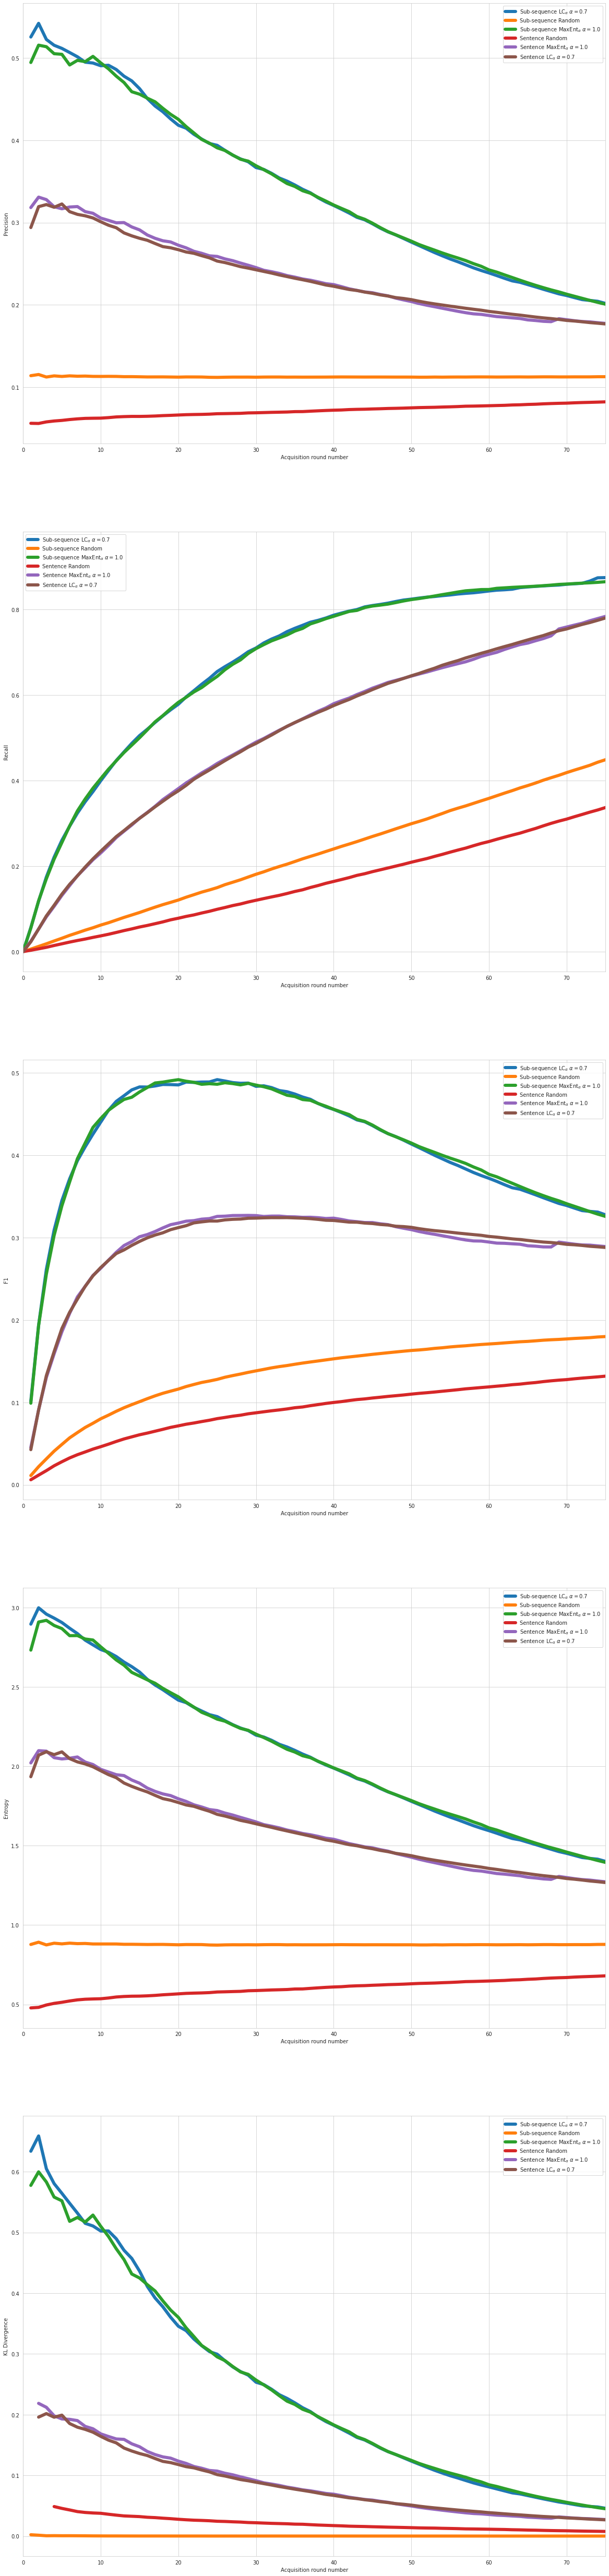

In [634]:
import itertools
from math import log2

if True:
    precision_groupings = {}
    recall_groupings = {}
    f1_groupings = {}
    entropy_groupings = {}
    KL_groupings = {}

for key, cumulative_data in tqdm(all_counts.items()):
    
    name = key_sorter(key)
    
    if not len(cumulative_data[0]):
        continue

    exp = combine_class_dict_classes(cumulative_data)
    full_class_composition = get_full_class_composition(key, train_data)
    full_class_composition = combine_class_dict_classes(full_class_composition)

    props = turn_cumulative_into_props(exp, full_class_composition)
    entity_props = [np.array(v) for k, v in props.items() if k is not 'O']
    recall_line = sum(entity_props)/len(entity_props)
    if name in recall_groupings:
        recall_groupings[name].append(list(recall_line))
    else:
        recall_groupings[name] = [list(recall_line)]
    
    entity_counts = sum([np.array(v) for k, v in exp.items() if k is not 'O'])
    total = sum([np.array(v) for k, v in exp.items()])
    precision_line = entity_counts/total
    if name in precision_groupings:
        precision_groupings[name].append(list(precision_line))
    else:
        precision_groupings[name] = [list(precision_line)]

    f1_line = (2*recall_line*precision_line)/(recall_line+precision_line)
    if name in f1_groupings:
        f1_groupings[name].append(list(f1_line))
    else:
        f1_groupings[name] = [list(f1_line)]
        
    freqs_prog = dict_of_lists_to_list_of_dicts(exp)
    #freqs_prog = [{k: v for k, v in f.items() if k is not 'O'} for f in freqs_prog]
    final_pmf = normalise_dict(full_class_composition)
    #final_pmf = normalise_dict({k: v for k, v in full_class_composition.items() if k is not 'O'})
    
    pmf_prog = [normalise_dict(f) for f in freqs_prog][1:]
    
    entropy_line = [np.nan] + turn_pmf_to_entropy(pmf_prog)
    if name in entropy_groupings:
        entropy_groupings[name].append(list(entropy_line))
    else:
        entropy_groupings[name] = [list(entropy_line)]
        
    KL_line = [np.nan] + turn_pmf_to_KL(pmf_prog, final_pmf)
    if name in KL_groupings:
        KL_groupings[name].append(list(KL_line))
    else:
        KL_groupings[name] = [list(KL_line)]
        
            
precision_groupings = {k: v for k, v in precision_groupings.items() if v}


fig, axs = plt.subplots(5, figsize = (20, 90))

def do_plot(name, lines, ax, crit):
    if any([a in name for a in crit]):
        mean_line = diff_size_mean("mean", lines)
        ax.plot(mean_line, label = name)

        
for name, lines in precision_groupings.items():
    do_plot(name, lines, axs[0], ["Random", "LC$_\\alpha$ $\\alpha=$0.7", "MaxEnt$_\\alpha$ $\\alpha=$1"])

for name, lines in recall_groupings.items():
    do_plot(name, lines, axs[1], ["Random", "LC$_\\alpha$ $\\alpha=$0.7", "MaxEnt$_\\alpha$ $\\alpha=$1"])

for name, lines in f1_groupings.items():
    do_plot(name, lines, axs[2], ["Random", "LC$_\\alpha$ $\\alpha=$0.7", "MaxEnt$_\\alpha$ $\\alpha=$1"])
    
for name, lines in entropy_groupings.items():
    do_plot(name, lines, axs[3], ["Random", "LC$_\\alpha$ $\\alpha=$0.7", "MaxEnt$_\\alpha$ $\\alpha=$1"])

for name, lines in KL_groupings.items():
    do_plot(name, lines, axs[4], ["Random", "LC$_\\alpha$ $\\alpha=$0.7", "MaxEnt$_\\alpha$ $\\alpha=$1"])
    
ylabs = ["Precision", "Recall", "F1", "Entropy", "KL Divergence"]
for i, ax in enumerate(axs):
    ax.set_ylabel(ylabs[i])
    ax.set_xlabel("Acquisition round number")
    ax.set_xlim(0, 75)
    ax.legend()

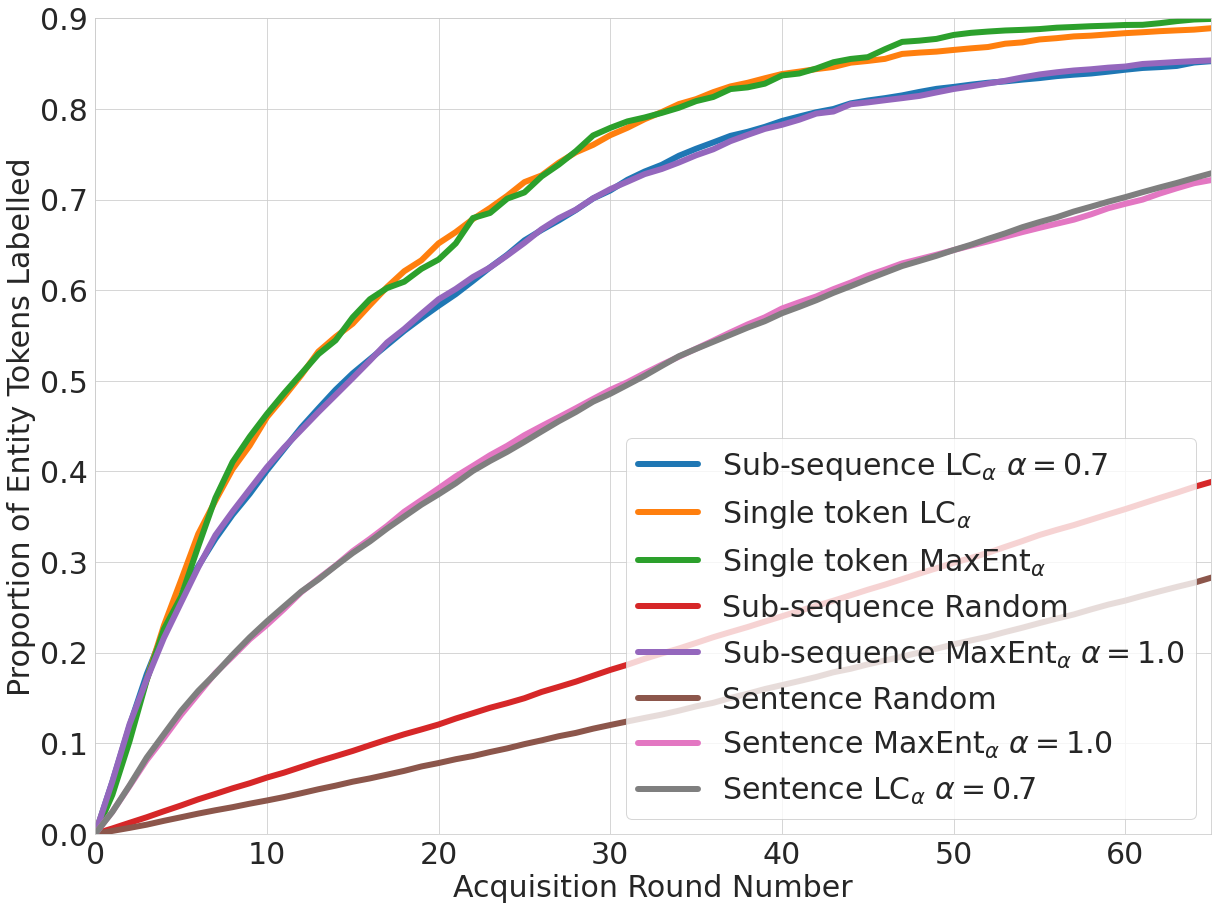

In [651]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 6

fig, ax = plt.subplots(1, figsize = (20, 15))

for name, _lines in recall_groupings.items():
    lines = [line for line in _lines if len(line) > 60]
    do_plot(name, lines, ax, ["Random", "LC$_\\alpha$ $\\alpha=$0.7", "MaxEnt$_\\alpha$ $\\alpha=$1", "Single"])

ax.set_xlim(0, 65)
ax.set_ylim(0, 0.9)
ax.set_xlabel("Acquisition Round Number")
ax.set_ylabel("Proportion of Entity Tokens Labelled")
ax.legend(fontsize = 30)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)

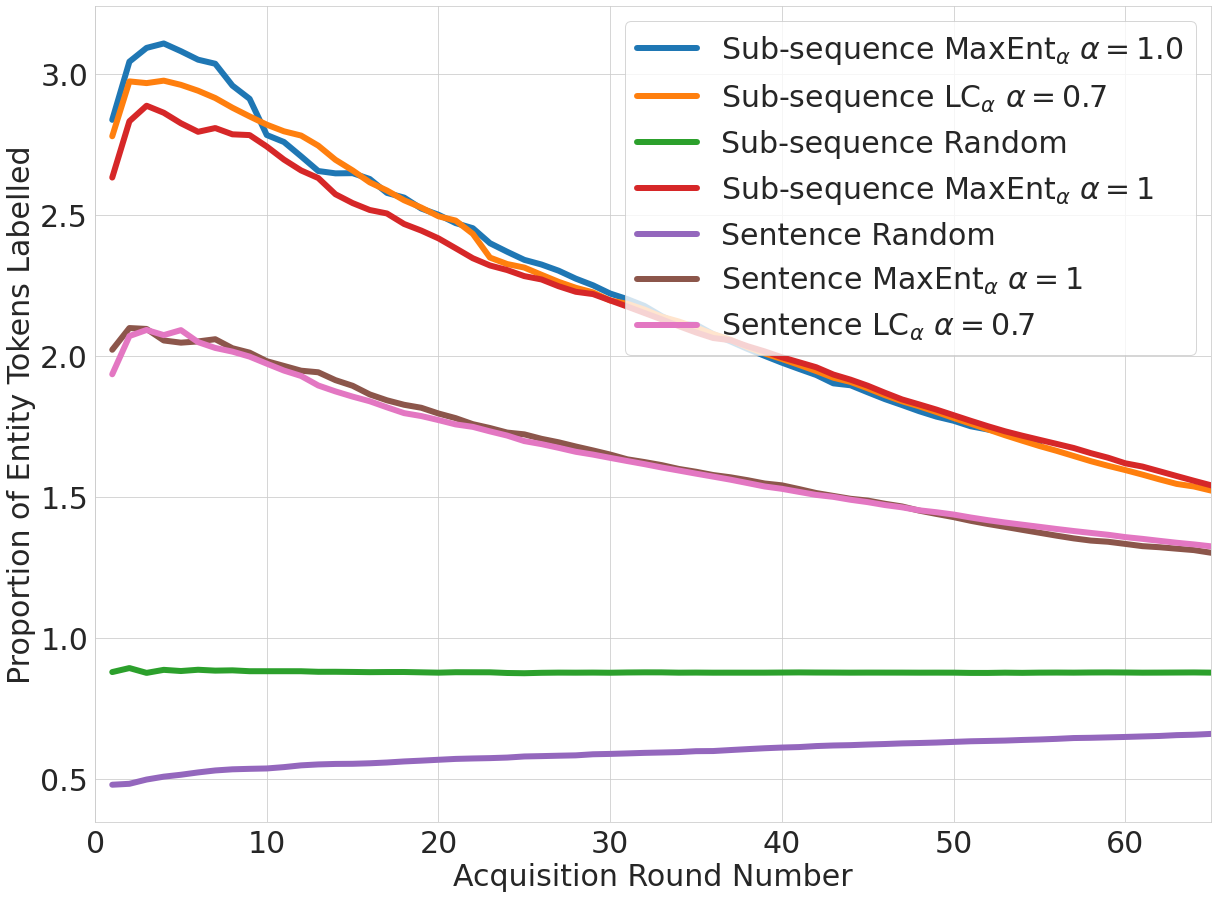

In [525]:
fig, ax = plt.subplots(1, figsize = (20, 15))

for name, lines in entropy_groupings.items():
    do_plot(name, lines, ax, ["Random", "LC$_\\alpha$ $\\alpha=$0.7", "MaxEnt$_\\alpha$ $\\alpha=$1"])

ax.set_xlim(0, 65)
ax.set_xlabel("Acquisition Round Number")
ax.set_ylabel("Proportion of Entity Tokens Labelled")
ax.legend(fontsize = 30)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)

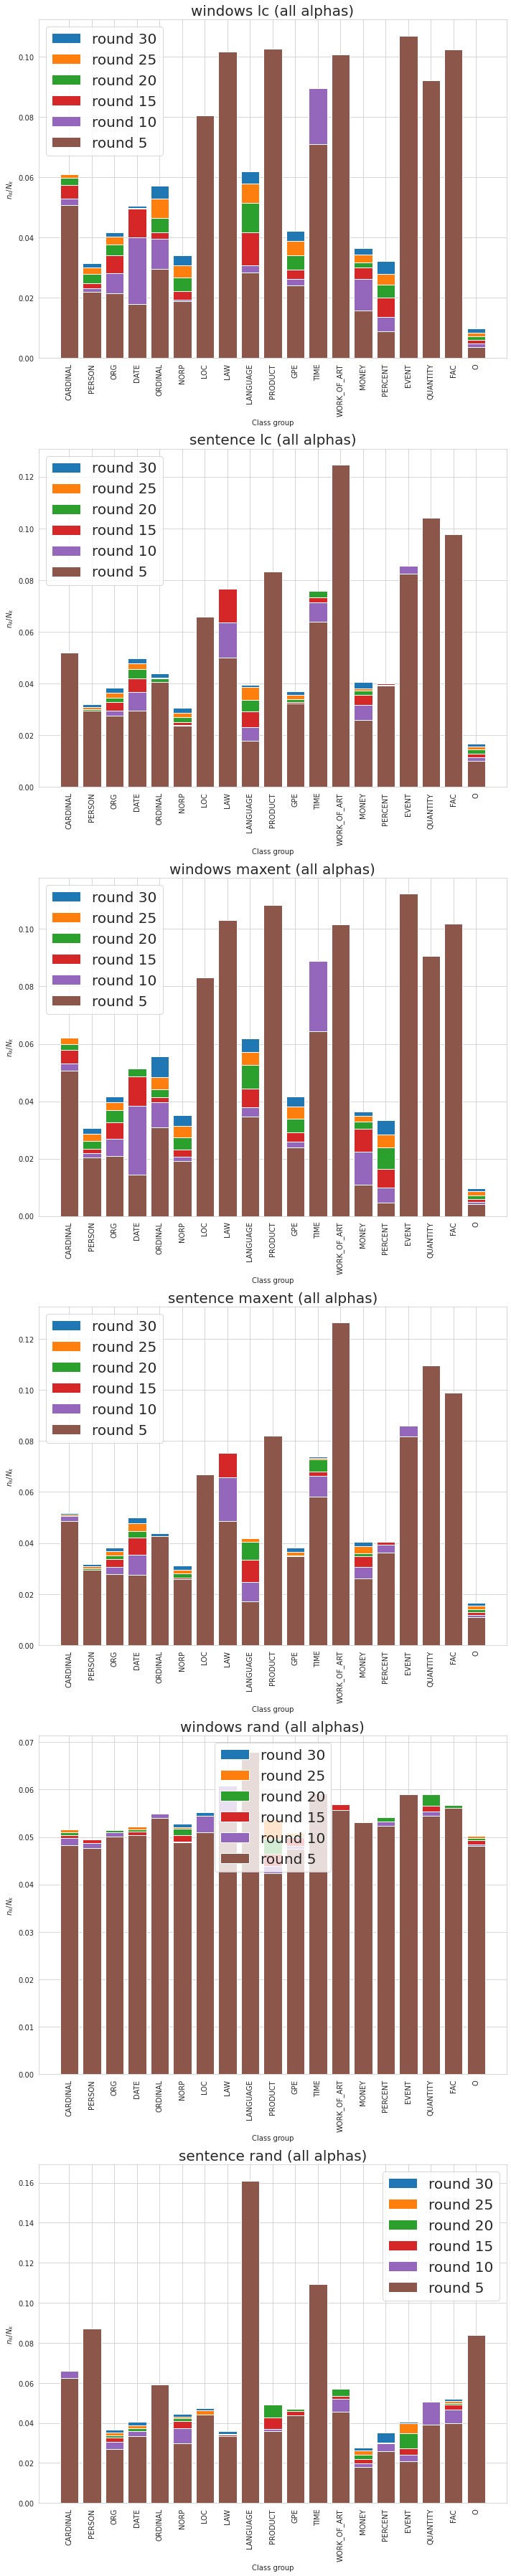

In [2356]:
def get_round_cumulative_props(histogram_dict, method, t):
    return {tag: evo[t] for tag, evo in histogram_dict[method].items()}

def mutliply_dicts(d1, d2):
    assert sorted(d1.keys()) == sorted(d2.keys())
    outd = {}
    for k in d1.keys():
        outd[k] = d1[k] * d2[k]
    return outd

def normalise_dict(d):
    norm = sum(d.values())
    out_d = {k: v/norm for k, v in d.items()}
    return out_d


class_histogram = {}

for method, props in props_plot_dict.items():
    class_histogram[method] = {
        tag: diff_size_mean("mean", [d[tag] for d in props_plot_dict[method]]) 
        for tag in props_plot_dict[method][0].keys()
    }
    

ts = [5, 10, 15, 20, 25, 30]
fig, axs = plt.subplots(len(props_plot_dict), figsize = (10, 50))

for i, method in enumerate(props_plot_dict.keys()):
    for p, t in enumerate(ts[::-1]):
        try:
            round_hist = get_round_cumulative_props(histogram_dict=class_histogram, method=method, t=t)
        except IndexError:
            continue
        plotter = round_hist
        # plotter = mutliply_dicts(plotter, combine_class_dict_classes(full_class_composition))
        plotter = normalise_dict(plotter)
        axs[i].bar(plotter.keys(), plotter.values(), label = f"round {t}")
        for tick in axs[i].get_xticklabels():
            tick.set_rotation(90)
    axs[i].set_title(method, fontsize = 20)
    axs[i].legend(fontsize = 20)
    axs[i].set_xlabel("Class group")
    axs[i].set_ylabel("$n_k/N_k$")
fig.tight_layout()

In [527]:
helper_conll, word_embeddings_conll, train_data_conll, test_data_conll, tag_set_conll = load_dataset("/home/pradmard/repos/data/CONLL/conll2003")
all_counts_conll = {}

for root in tqdm(conll_sentence_roots):
    all_counts_conll[root] = get_cumulative_dict(root, train_data=train_data_conll, num_classes=8)

with open("CONLL3_full_class_evolution2.json", "w") as jfile:
    json.dump(all_counts_conll, jfile)
    pass

  8%|▊         | 6/73 [00:01<00:17,  3.84it/s]


 28%|██▊       | 21/75 [00:05<00:14,  3.71it/s]


 10%|█         | 10/96 [06:36<56:34, 39.47s/it]
0it [00:00, ?it/s]

 44%|████▍     | 34/77 [00:09<00:12,  3.32it/s]


 44%|████▍     | 37/84 [00:26<00:13,  3.46it/s]


 28%|██▊       | 24/85 [00:06<00:16,  3.61it/s]


 22%|██▏       | 15/68 [00:21<00:19,  2.65it/s]


 35%|███▌      | 30/85 [00:25<03:28,  3.79s/it]


 16%|█▋        | 14/85 [00:20<00:41,  1.70it/s]


 27%|██▋       | 18/67 [00:05<00:14,  3.38it/s]


 43%|████▎     | 41/96 [25:42<37:42, 41.14s/it]
0it [00:00, ?it/s]

 31%|███       | 26/84 [00:07<00:18,  3.22it/s]


 49%|████▉     | 47/96 [29:18<33:38, 41.20s/it]
0it [00:00, ?it/s]

 18%|█▊        | 14/76 [00:04<00:18,  3.37it/s]


100%|██████████| 85/85 [00:44<00:00,  1.92it/s]


 14%|█▍        | 12/84 [00:03<00:22,  3.26it/s]


 15%|█▌        | 13/84 [00:04<00:20,  3.41it/s]


 17%|█▋        | 14/84 [00:04<00:21,  3.33it/s]


 21%|██▏       | 18/84 [00:23<00:27,  2.39it/s]


 96%|█████████▋| 82/85 [00:43<00:01,  2.90it/s]


 42%|████▏     | 36/85 [00:11<00:18,  2.70it/s]


 43%|████▎     | 36/84 [00:10<00:14,  3.22it/s]


 33%|███▎      | 28/85 [00:07<00:15,  3.71it/s]


  7%|▋         | 5/72 [00:01<00:19,  3.43it/s]


  7%|▋         | 6/82 [00:01<00:22,  3.32it/s]


100%|██████████| 96/96 [1:02:11<00:00, 38.87s/it]


In [528]:
props_plot_dict_conll = {}

for k, v in tqdm(all_counts_conll.items()):
    v = combine_class_dict_classes(v, tag_set_conll)
    full_class_composition_conll = get_full_class_composition(k, train_data_conll)
    full_class_composition_conll = combine_class_dict_classes(full_class_composition_conll, tag_set_conll)
    props = turn_cumulative_into_props(v, full_class_composition_conll)
    if "R-10000" in k:
        continue
    label = key_sorter(k)
    if label in props_plot_dict_conll:
        props_plot_dict_conll[label].append(props)
    else:
        props_plot_dict_conll[label] = [props]

100%|██████████| 96/96 [00:08<00:00, 11.25it/s]


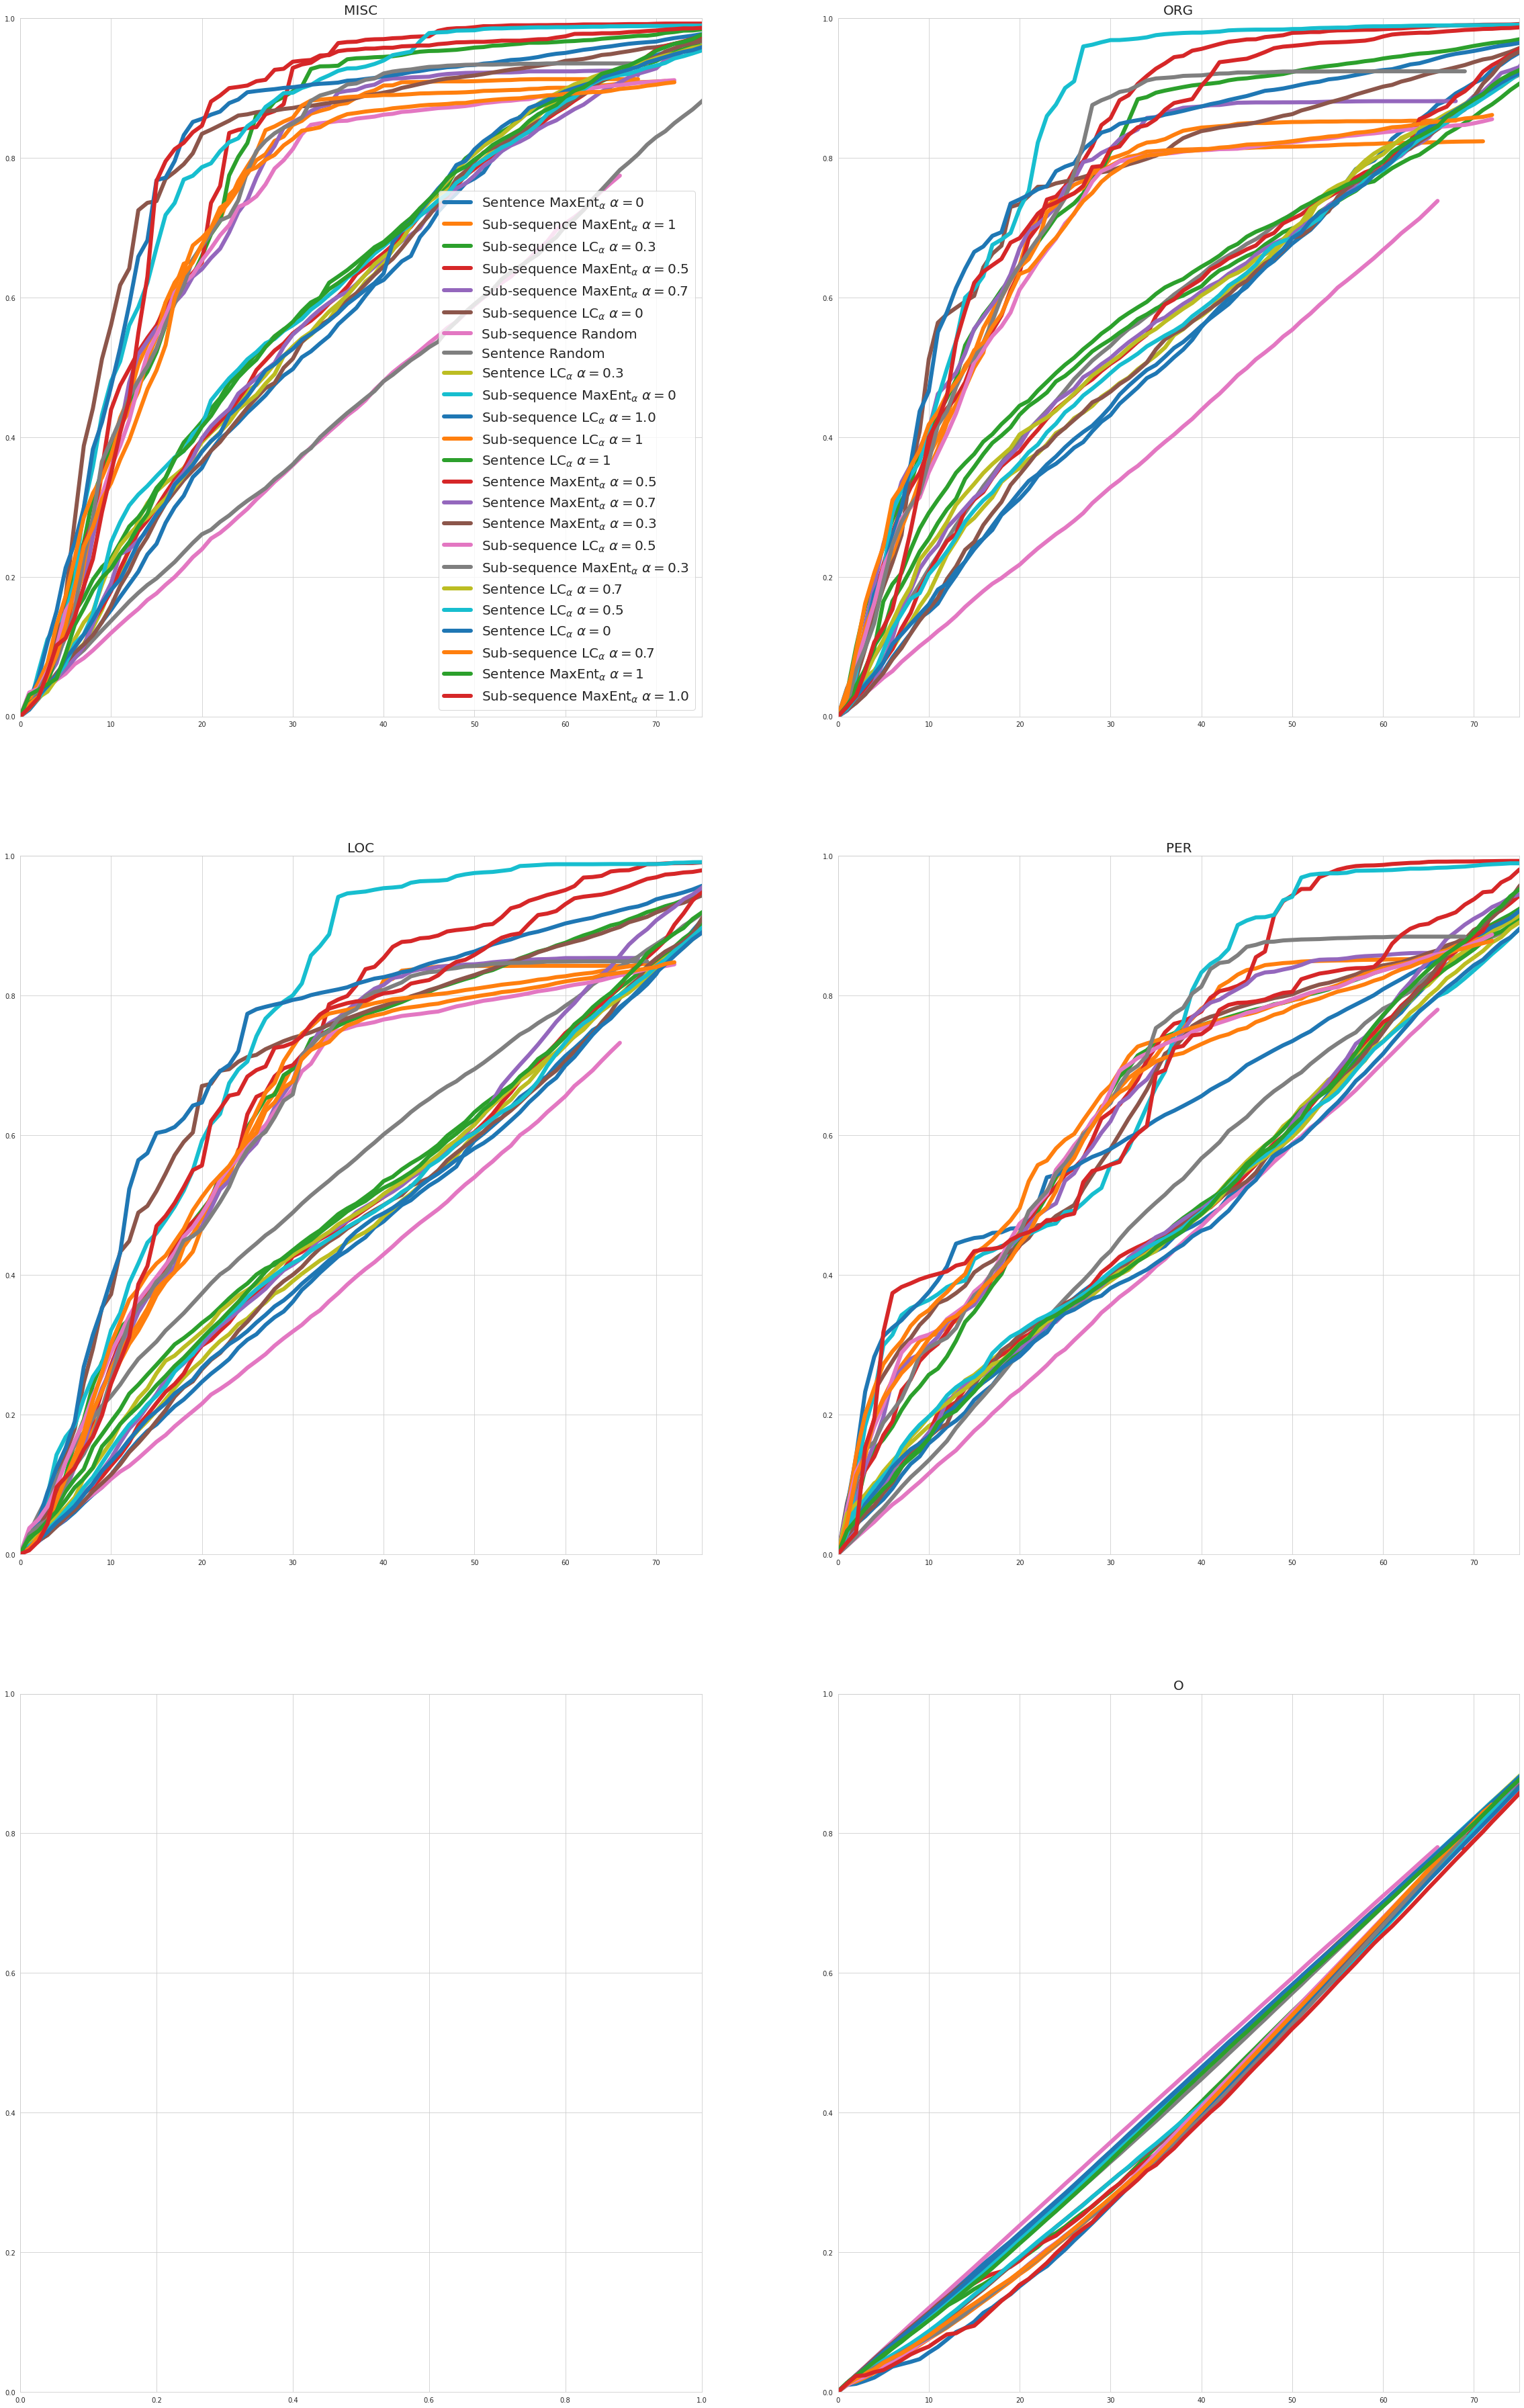

In [529]:
fig, axs = plt.subplots(3, 2, figsize = (40, 65))#len(tag_set.idx2key))

for i, t in enumerate(full_class_composition_conll.keys()):
    for k, v in props_plot_dict_conll.items():
        ax = axs[i//2,i-2*(i//2)-1]
        ax.plot(
            diff_size_mean("max", [a[t] for a in v]),
            label = k, linewidth = 6
        )
        ax.set_title(t, fontsize = 20)
        ax.set_xlim(0, 75)
        ax.set_ylim(0, 1)
axs[0,0].legend(fontsize = 20)

  0%|          | 0/96 [00:00<?, ?it/s]/home/pradmard/anaconda3/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/pradmard/anaconda3/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
100%|██████████| 96/96 [00:08<00:00, 11.36it/s]


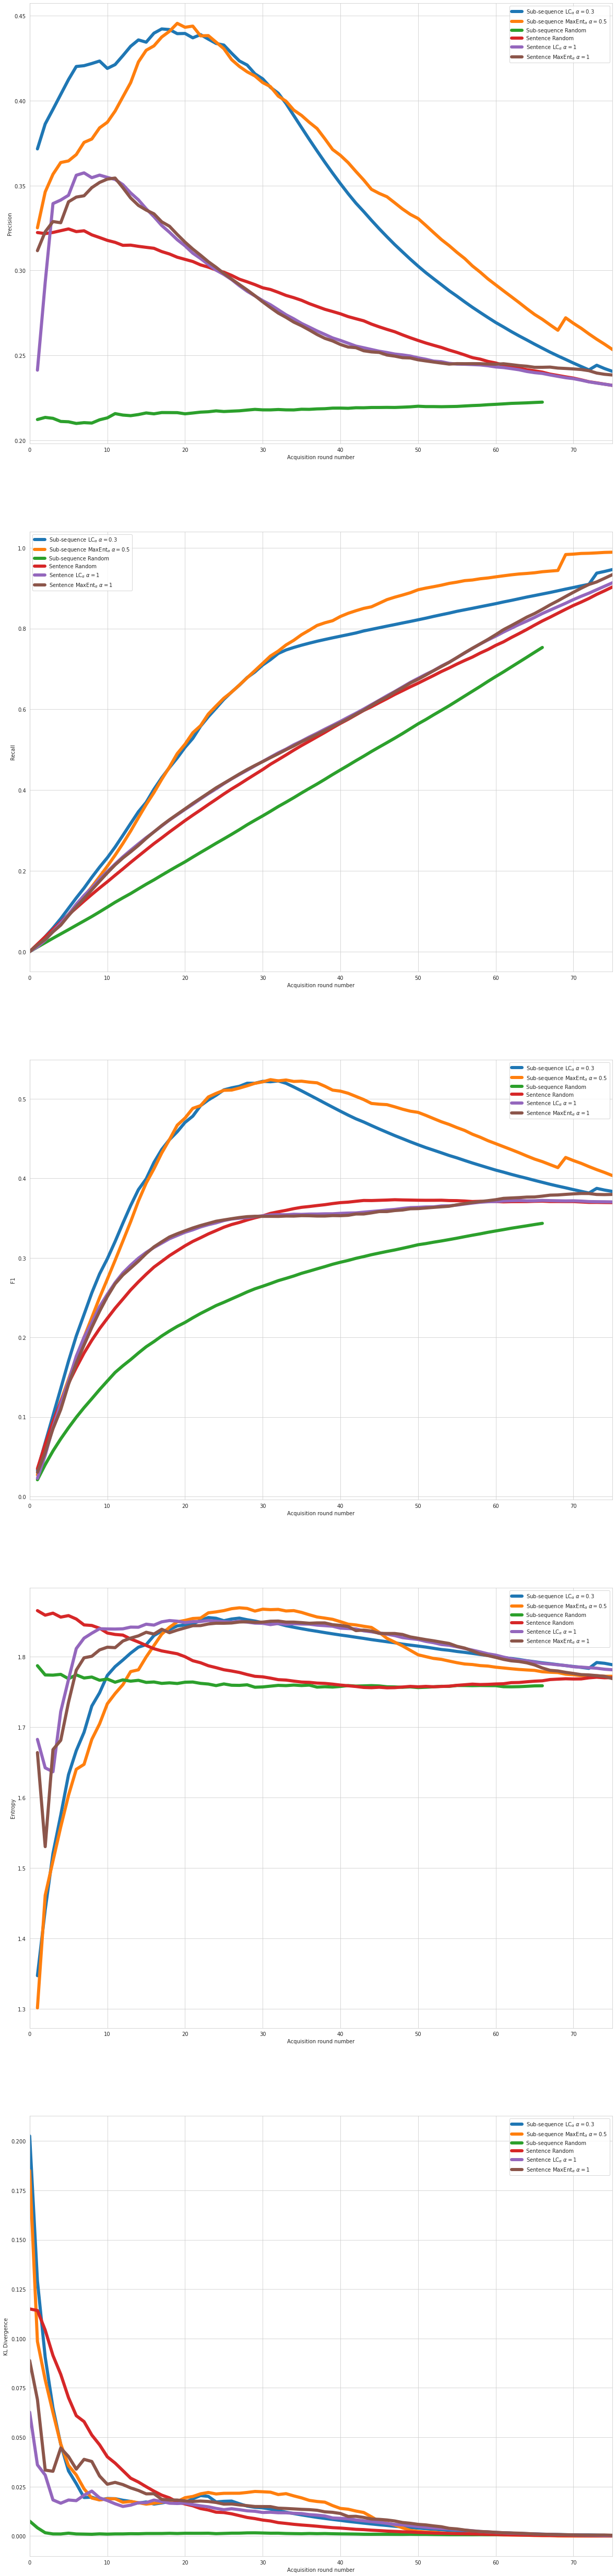

In [530]:
precision_groupings = {}
recall_groupings = {}
f1_groupings = {}
entropy_groupings = {}
KL_groupings = {}

for key, cumulative_data in tqdm(all_counts_conll.items()):
    
    if "R-10000" in key:
        continue
    
    name = key_sorter(key)
    exp = combine_class_dict_classes(cumulative_data, tag_set_conll)
    full_class_composition = get_full_class_composition(key, train_data_conll)
    full_class_composition = combine_class_dict_classes(full_class_composition, tag_set_conll)

    props = turn_cumulative_into_props(exp, full_class_composition)
    entity_props = [np.array(v) for k, v in props.items() if k is not 'O']
    recall_line = sum(entity_props)/len(entity_props)
    if name in recall_groupings:
        recall_groupings[name].append(list(recall_line))
    else:
        recall_groupings[name] = [list(recall_line)]
    
    entity_counts = sum([np.array(v) for k, v in exp.items() if k is not 'O'])
    total = sum([np.array(v) for k, v in exp.items()])
    precision_line = entity_counts/total
    if name in precision_groupings:
        precision_groupings[name].append(list(precision_line))
    else:
        precision_groupings[name] = [list(precision_line)]

    f1_line = (2*recall_line*precision_line)/(recall_line+precision_line)
    if name in f1_groupings:
        f1_groupings[name].append(list(f1_line))
    else:
        f1_groupings[name] = [list(f1_line)]
        
    freqs_prog = dict_of_lists_to_list_of_dicts(exp)
    freqs_prog = [{k: v for k, v in f.items() if k is not 'O'} for f in freqs_prog]
    final_pmf = normalise_dict({k: v for k, v in full_class_composition.items() if k is not 'O'})
    
    pmf_prog = [normalise_dict(f) for f in freqs_prog][1:]
    
    entropy_line = [np.nan] +  turn_pmf_to_entropy(pmf_prog)
    if name in entropy_groupings:
        entropy_groupings[name].append(list(entropy_line))
    else:
        entropy_groupings[name] = [list(entropy_line)]
        
    KL_line = turn_pmf_to_KL(pmf_prog, final_pmf)
    if name in KL_groupings:
        KL_groupings[name].append(list(KL_line))
    else:
        KL_groupings[name] = [list(KL_line)]
        
            
precision_groupings = {k: v for k, v in precision_groupings.items() if v}

crit = ["Random", "Sub-sequence LC$_\\alpha$ $\\alpha=$0.3", "Sub-sequence MaxEnt$_\\alpha$ $\\alpha=$0.5", "Sentence LC$_\\alpha$ $\\alpha=$1", "Sentence MaxEnt$_\\alpha$ $\\alpha=$1"]

fig, axs = plt.subplots(5, figsize = (20, 90))
        
for name, lines in precision_groupings.items():
    do_plot(name, lines, axs[0], crit)

for name, lines in recall_groupings.items():
    do_plot(name, lines, axs[1], crit)

for name, lines in f1_groupings.items():
    do_plot(name, lines, axs[2], crit)
    
for name, lines in entropy_groupings.items():
    do_plot(name, lines, axs[3], crit)

for name, lines in KL_groupings.items():
    do_plot(name, lines, axs[4], crit)
    
ylabs = ["Precision", "Recall", "F1", "Entropy", "KL Divergence"]
for i, ax in enumerate(axs):
    ax.set_ylabel(ylabs[i])
    ax.set_xlabel("Acquisition round number")
    ax.set_xlim(0, 75)
    ax.legend()

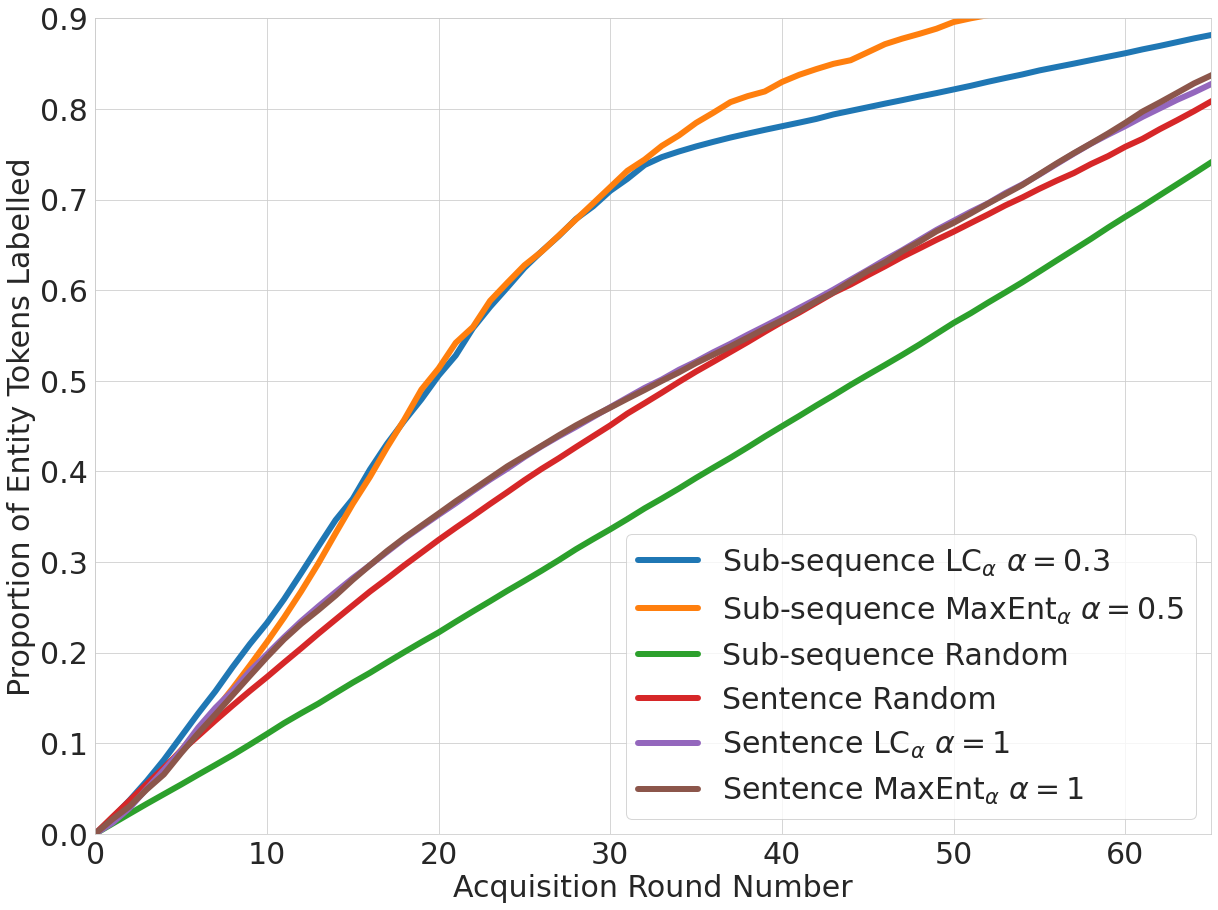

In [531]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 6

fig, ax = plt.subplots(1, figsize = (20, 15))

for name, lines in recall_groupings.items():
    
    do_plot(name, lines, ax, crit)

ax.set_xlim(0, 65)
ax.set_ylim(0, 0.9)
ax.set_xlabel("Acquisition Round Number")
ax.set_ylabel("Proportion of Entity Tokens Labelled")
ax.legend(fontsize = 30)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)

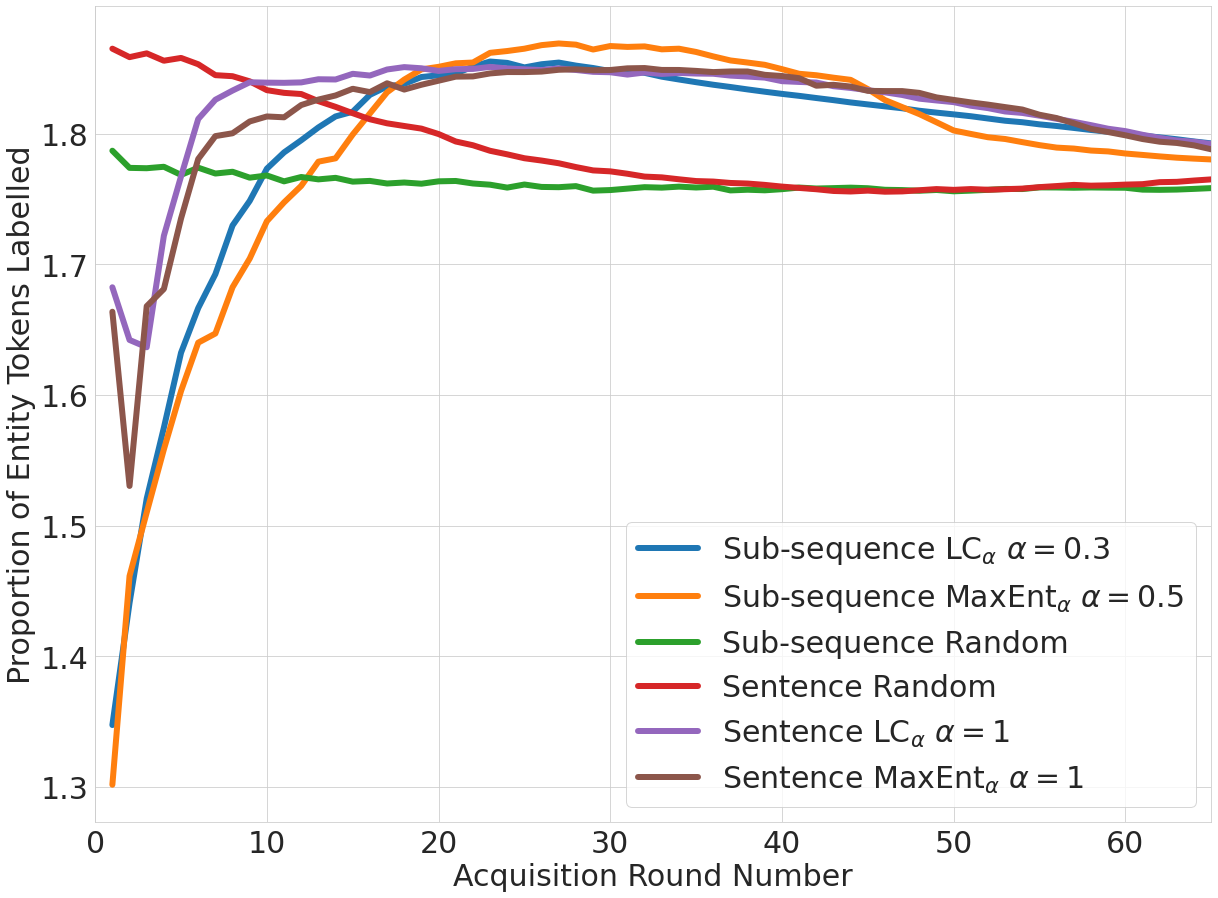

In [532]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 6

fig, ax = plt.subplots(1, figsize = (20, 15))

for name, lines in entropy_groupings.items():
    
    do_plot(name, lines, ax, crit)

ax.set_xlim(0, 65)
ax.set_xlabel("Acquisition Round Number")
ax.set_ylabel("Proportion of Entity Tokens Labelled")
ax.legend(fontsize = 30)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)

In [2362]:
class_histogram_conll = {}

for method, props in props_plot_dict_conll.items():
    class_histogram_conll[method] = {
        tag: diff_size_mean("mean", [d[tag] for d in props_plot_dict_conll[method]]) 
        for tag in props_plot_dict_conll[method][0].keys()
    }

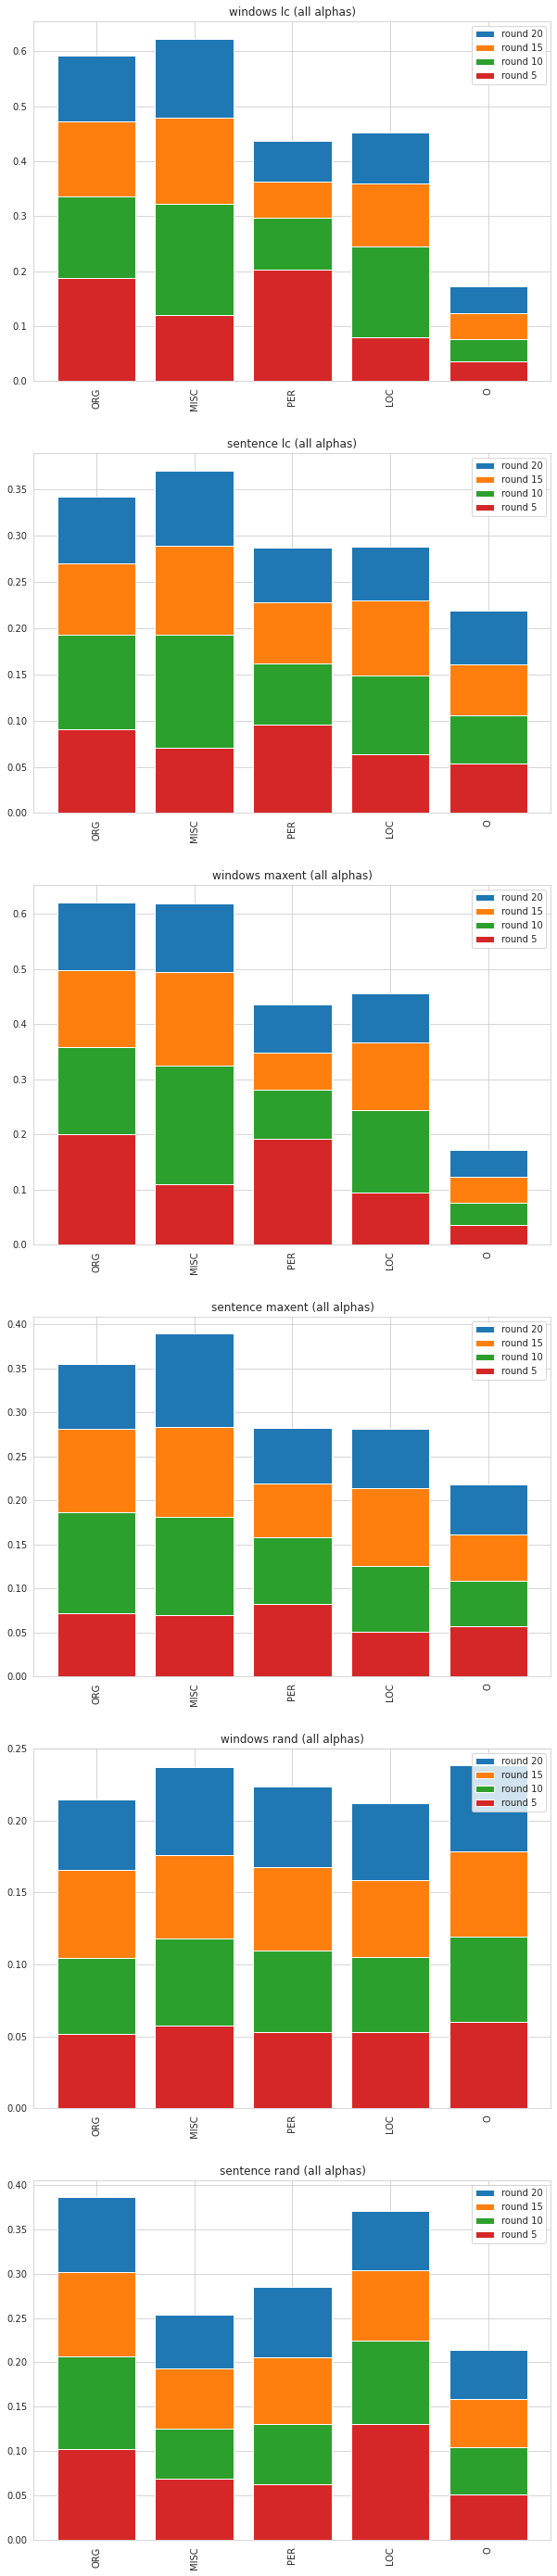

In [2363]:
def get_round_cumulative_props(histogram_dict, method, t):
    return {tag: evo[t] for tag, evo in class_histogram_conll[method].items()}

ts = [5, 10, 15, 20]
fig, axs = plt.subplots(len(props_plot_dict_conll), figsize = (10, 50))

for i, method in enumerate(props_plot_dict.keys()):
    for p, t in enumerate(ts[::-1]):
        try:
            round_hist = get_round_cumulative_props(histogram_dict=class_histogram, method=method, t=t)
        except IndexError:
            continue
        axs[i].bar(round_hist.keys(), round_hist.values(), label = f"round {t}")
        for tick in axs[i].get_xticklabels():
            tick.set_rotation(90)
    axs[i].set_title(method)
    axs[i].legend()

In [849]:
def window_to_scores(window, alpha):
    L = window[1][1] - window[1][0]
    total_score = window[-1] * (L**alpha)
    return [total_score/L for _ in range(L)]

def get_alpha_from_root(root):
    vals = pd.read_csv(glob(root+"/config.txt")[0], sep = "\t").values.reshape(-1)
    alpha_entry = [a for a in vals if "alpha" in a][0]
    return float(alpha_entry.split(" ")[-1])

def generate_score_curve(root_main):
    
    average_scores = []
    root_alpha = get_alpha_from_root(root_main)
    num_rounds = len(glob(os.path.join(root_main, "round-*")))
    num_rounds = min([num_rounds, 84])
    
    if num_rounds < 75:
        return None
    
    for i in tqdm(range(1, num_rounds-1)):
        
        root = f"{root_main}/round-{i}"

        with open(os.path.join(root, "round_selection.pk")) as jfile:
            round_selection = json.load(jfile)
            
        selected_windows = round_selection['round_selection_windows']
        round_selected_scores = []
        for w in selected_windows:
            round_selected_scores.extend(window_to_scores(w, root_alpha))
        average_scores.append(sum(round_selected_scores)/len(round_selected_scores))

    return average_scores


def display_score_curves(experiment_score_info, axs):
    
    axs[0].set_title("Total score sum")
    axs[1].set_title("Spread of scores")
    x = range(len(experiment_score_info["round_selected_scores_sum"]))
    
    axs[0].plot(experiment_score_info["round_selected_scores_sum"], label="Sum selected score")
    
    axs[1].plot(experiment_score_info["round_selected_scores_mean"], label="Mean selected score")
    axs[1].fill_between(
        x,
        experiment_score_info["round_selected_scores_mean"] + experiment_score_info["round_selected_scores_std"],
        experiment_score_info["round_selected_scores_mean"] - experiment_score_info["round_selected_scores_std"],
        alpha = 0.3
    )
    
    axs[1].plot(experiment_score_info["round_selected_scores_mean"], label="Mean score (all windows)")
    axs[1].fill_between(
        x,
        experiment_score_info["round_selected_scores_mean"] + experiment_score_info["round_selected_scores_std"],
        experiment_score_info["round_selected_scores_mean"] - experiment_score_info["round_selected_scores_std"],
        alpha = 0.3
    )

In [ ]:
get_root_from_round_selection = lambda x: x.split("/")[0]
all_round_selection_roots = glob("-W*/round-1/round_selection.pk")
onto_round_selection_roots = [get_root_from_round_selection(r) for r in all_round_selection_roots if "conll" not in r.lower()]
conll_round_selection_roots = [get_root_from_round_selection(r) for r in all_round_selection_roots if "conll" in r.lower()]

In [ ]:
onto_round_selection_roots = [
    '-W--1--A-lc--T-1--alpha-0---beta-0--R-10000--B-1--I-0.01--2020-12-16-00:36:56',
    '-W--1--A-lc--T-1--alpha-0---beta-0--R-10000--B-1--I-0.01--2020-12-26-12:18:53',
    '-W--1--A-lc--T-1--alpha-0.3---beta-0--R-10000--B-1--I-0.01--2021-01-05-21:45:02',
    '-W--1--A-lc--T-1--alpha-0.5---beta-0--R-10000--B-1--I-0.01--2021-01-05-21:45:43',
    '-W--1--A-lc--T-1--alpha-0.7---beta-0--R-10000--B-1--I-0.01--2020-12-16-09:49:56',    
    '-W--1--A-lc--T-1--alpha-0.7---beta-0--R-10000--B-1--I-0.01--2020-12-20-16:26:09',
    '-W--1--A-lc--T-1--alpha-0.7---beta-0--R-10000--B-1--I-0.01--2021-01-05-21:45:23',
    '-W--1--A-lc--T-1--alpha-0.7---beta-0--R-50000--B-1--I-0.01--2020-12-23-01:23:57',
    '-W--1--A-lc--T-1--alpha-1.0---beta-0--R-10000--B-1--I-0.01--2020-12-20-16:26:53',
    '-W--1--A-maxent--T-1--alpha-0---beta-0--R-10000--B-1--I-0.01--2020-12-29-23:40:00',
    '-W--1--A-maxent--T-1--alpha-0---beta-0--R-10000--B-1--I-0.01--2020-12-31-00:11:21',
    '-W--1--A-maxent--T-1--alpha-0---beta-0--R-10000--B-1--I-0.01--2021-01-01-21:01:11',
    '-W--1--A-maxent--T-1--alpha-0.3---beta-0--R-10000--B-1--I-0.01--2020-12-29-23:40:20',
    '-W--1--A-maxent--T-1--alpha-0.3---beta-0--R-10000--B-1--I-0.01--2020-12-31-00:11:39',
    '-W--1--A-maxent--T-1--alpha-0.3---beta-0--R-10000--B-1--I-0.01--2021-01-01-21:01:26',   
    '-W--1--A-maxent--T-1--alpha-0.5---beta-0--R-10000--B-1--I-0.01--2020-12-29-23:40:14',
    '-W--1--A-maxent--T-1--alpha-0.5---beta-0--R-10000--B-1--I-0.01--2020-12-31-00:11:33',
    '-W--1--A-maxent--T-1--alpha-0.5---beta-0--R-10000--B-1--I-0.01--2021-01-01-21:01:22',
    '-W--1--A-maxent--T-1--alpha-0.7---beta-0--R-10000--B-1--I-0.01--2020-12-31-00:11:17',
    '-W--1--A-maxent--T-1--alpha-0.7---beta-0--R-10000--B-1--I-0.01--2021-01-01-21:01:02',
    '-W--1--A-maxent--T-1--alpha-0.7---beta-0--R-10000--B-1--I-0.01--2021-01-05-21:51:44',
    '-W--1--A-maxent--T-1--alpha-1---beta-0--R-10000--B-1--I-0.01--2020-12-29-23:40:07',
    '-W--1--A-maxent--T-1--alpha-1---beta-0--R-10000--B-1--I-0.01--2020-12-31-00:11:26',
    '-W--1--A-maxent--T-1--alpha-1---beta-0--R-10000--B-1--I-0.01--2021-01-01-21:01:18',
 '-W-3-7--A-lc--T-1--alpha-0---beta-0--R-10000--B-1--I-0.01--2020-12-16-00:36:16',
 '-W-3-7--A-lc--T-1--alpha-0---beta-0--R-10000--B-1--I-0.01--2020-12-20-16:22:40',
 '-W-3-7--A-lc--T-1--alpha-0---beta-0--R-10000--B-1--I-0.01--2020-12-22-20:21:24',
 '-W-3-7--A-lc--T-1--alpha-0.2---beta-0--R-10000--B-1--I-0.01--2020-12-23-10:24:12',
 '-W-3-7--A-lc--T-1--alpha-0.2---beta-0--R-10000--B-1--I-0.01--2020-12-26-12:15:18',
 '-W-3-7--A-lc--T-1--alpha-0.2---beta-0--R-10000--B-1--I-0.01--2020-12-26-12:15:39',
 '-W-3-7--A-lc--T-1--alpha-0.3---beta-0--R-10000--B-1--I-0.01--2020-12-23-10:24:19',
 '-W-3-7--A-lc--T-1--alpha-0.3---beta-0--R-10000--B-1--I-0.01--2020-12-26-12:15:34',
 '-W-3-7--A-lc--T-1--alpha-0.3---beta-0--R-50000--B-1--I-0.01--2020-12-22-20:21:39',
 '-W-3-7--A-lc--T-1--alpha-0.5---beta-0--R-10000--B-1--I-0.01--2020-12-23-10:24:29',
 '-W-3-7--A-lc--T-1--alpha-0.5---beta-0--R-10000--B-1--I-0.01--2020-12-26-12:15:25',
 '-W-3-7--A-lc--T-1--alpha-0.5---beta-0--R-50000--B-1--I-0.01--2020-12-22-20:21:44',
 '-W-3-7--A-lc--T-1--alpha-0.7---beta-0--R-10000--B-1--I-0.01--2020-12-20-16:19:32',
 '-W-3-7--A-lc--T-1--alpha-0.7---beta-0--R-10000--B-1--I-0.01--2020-12-22-20:21:31',
 '-W-3-7--A-lc--T-1--alpha-0.7---beta-0--R-10000--B-1--I-0.01--2020-12-22-23:30:47',
 '-W-3-7--A-lc--T-1--alpha-1---beta-0--R-10000--B-1--I-0.01--2020-12-16-00:50:05',
 '-W-3-7--A-lc--T-1--alpha-1---beta-0--R-10000--B-1--I-0.01--2020-12-20-16:22:54',
    
 '-W-3-7--A-maxent--T-1--alpha-0---beta-0--R-10000--B-1--I-0.01--2020-12-29-23:39:31',
 '-W-3-7--A-maxent--T-1--alpha-0---beta-0--R-10000--B-1--I-0.01--2021-01-01-21:00:06',
 '-W-3-7--A-maxent--T-1--alpha-0.3---beta-0--R-10000--B-1--I-0.01--2020-12-29-23:39:49',
 '-W-3-7--A-maxent--T-1--alpha-0.3---beta-0--R-10000--B-1--I-0.01--2021-01-01-21:00:40',
 '-W-3-7--A-maxent--T-1--alpha-0.3---beta-0--R-10000--B-1--I-0.01--2021-01-05-21:39:35',
    
 '-W-3-7--A-maxent--T-1--alpha-0.5---beta-0--R-10000--B-1--I-0.01--2020-12-29-23:39:45',
 '-W-3-7--A-maxent--T-1--alpha-0.5---beta-0--R-10000--B-1--I-0.01--2021-01-01-21:00:34',
 '-W-3-7--A-maxent--T-1--alpha-0.5---beta-0--R-10000--B-1--I-0.01--2021-01-06-10:04:18',
 '-W-3-7--A-maxent--T-1--alpha-0.7---beta-0--R-10000--B-1--I-0.01--2020-12-29-23:39:27',
 '-W-3-7--A-maxent--T-1--alpha-0.7---beta-0--R-10000--B-1--I-0.01--2021-01-01-20:59:59',
 '-W-3-7--A-maxent--T-1--alpha-0.7---beta-0--R-10000--B-1--I-0.01--2021-01-06-10:05:40',
 '-W-3-7--A-maxent--T-1--alpha-1---beta-0--R-10000--B-1--I-0.01--2020-12-29-23:39:39',
 '-W-3-7--A-maxent--T-1--alpha-1---beta-0--R-10000--B-1--I-0.01--2021-01-01-21:00:17',
 '-W-3-7--A-maxent--T-1--alpha-1---beta-0--R-10000--B-1--I-0.01--2021-01-06-10:04:54'
]

In [843]:
single_root_onto = [a for a in index_roots if "-W-1--" in a]

In [853]:
import ujson as json

#onto_score_curves = {}
#conll_score_curves = {}

#for root in tqdm(onto_round_selection_roots):
for root in tqdm(single_root_onto):
    if root in onto_score_curves:
        continue
    curve = generate_score_curve(root)
    if curve:
        onto_score_curves[root] = curve
    
#for root in tqdm(conll_round_selection_roots):
#    conll_score_curves[root] = generate_score_curve(root)

100%|██████████| 11/11 [31:25<00:00, 171.45s/it]


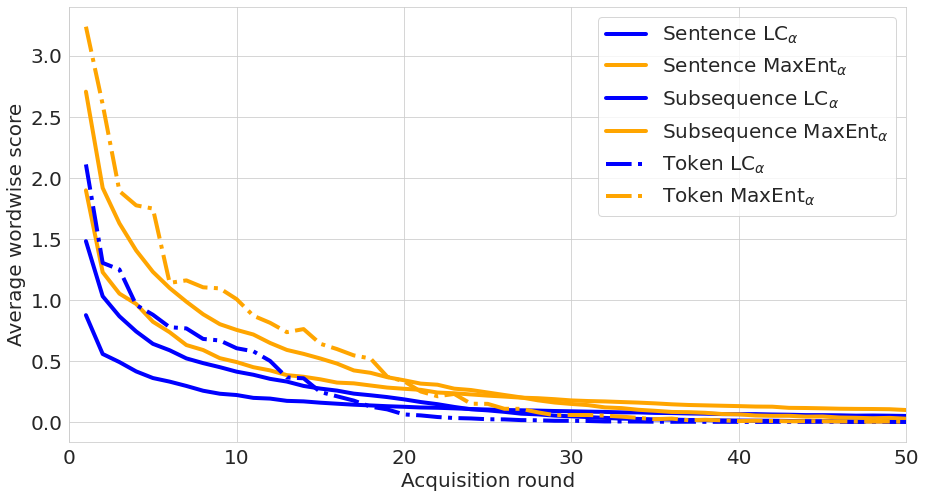

In [852]:
def key_sorter(ac):
    if "-W--1" in ac:
        method = "Sentence"
    elif "-W-1--" in ac:
        method = "Token"
    elif "-W-3-7--" in ac:
        method = "Subsequence"
        
    alpha = "$\\alpha=$" + ac.split("alpha-")[-1].split("--")[0]
        
    if "maxent" in ac:
        af = "MaxEnt$_\\alpha$"
    elif "lc" in ac:
        af = "LC$_\\alpha$"
    else:
        af = "Random"
        alpha = " "
    
    return f"{method} {af}"#" {alpha}"

curve_score_plotter = {}

for k, v in onto_score_curves.items():
    if len(v) < 24:
        continue
    name = key_sorter(k)
    if name in curve_score_plotter:
        curve_score_plotter[name].append(v)
    else:
        curve_score_plotter[name] = [v]

#fig, ax = plt.subplots(2, figsize = (15, 15))
fig, ax = plt.subplots(1, figsize = (15, 8)); ax = [ax, None]

for k, v in curve_score_plotter.items():
    
    line = diff_size_mean("mean", v)
    norm_line = line/max(line)
    x = range(1, len(line)+1)
    
    if "MaxEnt" in k:
        color = "orange"
    else:
        color = "blue"
    if "Sentence" in k:
        ls = "--"
    if "Token" in k:
        ls = "-."
    else:
        ls = "-"
    
    ax[0].plot(x, line, label = k, linewidth = 4, linestyle = ls, color = color)
    #ax[1].plot(x, norm_line, label = k, linewidth = 4, linestyle = ls, color = color)

    
ax[0].set_xlim(0, 50)
#ax[1].set_xlim(0, 50)
ax[0].legend(fontsize = 20)

ax[0].set_xlabel("Acquisition round", fontsize = 20)
#ax[1].set_xlabel("Acquisition round")
ax[0].set_ylabel("Average wordwise score", fontsize = 20)
#ax[1].set_ylabel("Average wordwise score, divided by initial round")

ax = ax[0]
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

In [828]:
# Distribution of tokens within sentence

import time

trial_root = '-W--1--A-lc--T-1--alpha-0---beta-0--R-10000--B-1--I-0.01--2020-12-26-12:18:53'

def get_unlabelled_scores_json_full_sentence(root, round_num):
    if "-W--1" not in root:
        raise ValueError("Root must be a full sentence selector")
    with open(os.path.join(root, f"round-{round_num}", "all_word_scores_no_nan.json"), "r") as jfile:
        all_scores = json.load(jfile)
    with open(os.path.join(root, f"round-{round_num-1}", "agent_index.pk"), "r") as jfile:
        agent_index = json.load(jfile)
        
    all_scores_out = {}
    
    # Shouldn't be needed, just a formality
    for sidx in all_scores.keys():
        if len(agent_index["labelled_idx"][sidx]) == 0:
            all_scores_out[int(sidx)] = all_scores[sidx]
        elif len(agent_index["unlabelled_idx"][sidx]) == 0:
            pass
        else:
            raise ValueError("messed up")
    
    return all_scores_out


def generate_windows_scores_from_json(unlabelled_scores, L_min=3, L_max_plus_one=7, alpha=1, purify = True, windows = True):
    sentence_scores = []
    window_scores = []
    
    for k, v in unlabelled_scores.items():
        sentence_scores.append([k, [0, len(v)], sum(v)*(len(v)**-alpha)])
        
    for l in range(L_min, L_max_plus_one):
        for k, v in unlabelled_scores.items():
            unpure_window_scores = [[k, [j, j+l], sum(v[j:j+l])*(l**-alpha)] for j in range(len(v) - l + 1)]
            if purify:
                window_scores.extend(purify_entries(unpure_window_scores))
            else:
                window_scores.extend(unpure_window_scores)
    
    return sentence_scores, window_scores


  2%|▏         | 1/50 [00:00<00:06,  7.91it/s]

2.2238967418670654


100%|██████████| 50/50 [00:00<00:00, 201.84it/s]


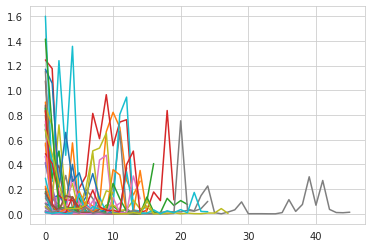

In [183]:
start_time = time.time()
trial_unlabelled_scores = get_unlabelled_scores_json_full_sentence(root=trial_root, round_num=6)
end_time = time.time()
print(end_time - start_time)

for score_list in tqdm(list(trial_unlabelled_scores.values())[:50]):
    distances_and_scores = [(abs(i - np.argmax(score_list)), score) for i, score in enumerate(score_list)]
    zipped = sorted(distances_and_scores, key = lambda x: x[0])
    dictionary = {}
    for dist, score in zipped:
        norm_dist = dist#/(len(distances_and_scores))
        if dist not in dictionary:
            dictionary[norm_dist] = score
        elif score > dictionary[norm_dist]:
            dictionary[norm_dist] = score
    plt.plot(*zip(*dictionary.items()))

In [176]:
def greedy_window_acquisition_without_word_checker(all_windows, round_size=10000):
    greedy_windows, total_size = [], 0
    all_windows = sorted(all_windows, key = lambda x: x[-1], reverse = True)
    for w in tqdm(all_windows):
        greedy_windows.append(w)
        total_size += w[1][1]-w[1][0]
        if total_size > round_size:
            break
    return greedy_windows

{0.0: 0.1414288431406021,
 0.07142857142857142: 0.012553836219012737,
 0.14285714285714285: 0.0017076447838917375,
 0.21428571428571427: 0.021406440064311028,
 0.2857142857142857: 0.014618667773902416,
 0.35714285714285715: 0.02460838295519352,
 0.42857142857142855: 0.025643717497587204,
 0.5: 0.017163434997200966,
 0.5714285714285714: 0.01689271070063114,
 0.6428571428571429: 0.0004924515378661454,
 0.7142857142857143: 0.01983930543065071,
 0.7857142857142857: 0.0010080024367198348,
 0.8571428571428571: 0.001725019421428442}

In [197]:
# windows = generate_windows_scores_from_json(trial_unlabelled_scores)

#sentence_scores, window_scores = windows
#sentence_acquisition = greedy_window_acquisition_without_word_checker(sentence_scores)
#window_acquisition = greedy_window_acquisition_without_word_checker(window_scores)

sentences_with_windows_selected = set(np.unique(sorted([w[0] for w in window_acquisition])))
sentence_selected = set(np.unique(sorted([w[0] for w in sentence_acquisition])))
len(sentences_with_windows_selected), len(sentence_acquisition)

(1825, 1908)

In [ ]:
words_selected_from_sentence = {}

for window in window_acquisition:
    word_idx = set(range(window[1][0], window[1][1]))
    if window[0] in words_selected_from_sentence:
        words_selected_from_sentence[]

1

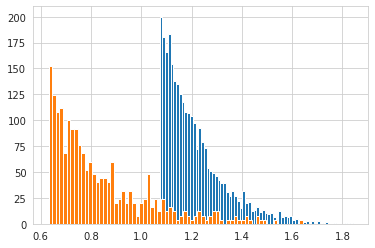

In [105]:
# Score distribution evolution for sentence vs. window.
# This requires full sentences with all scores ==> only a few roots e.g.:
# -W--1--A-lc--T-1--alpha-0.7---beta-0--R-50000--B-1--I-0.01--2020-12-22-20:21:51 

In [776]:
def purify_entries(entries):
    start_entries = sorted(entries, key=lambda x: x[-1], reverse=True)
    final_entries = []
    highest_idx = set()
    for entry in start_entries:
        if np.isnan(entry[-1]):
            continue
        span = set(range(*entry[1]))
        if highest_idx.intersection(span):
            pass
        else:
            highest_idx = highest_idx.union(span)
            final_entries.append(entry)
    return final_entries


def get_score_distribution_from_windows(selected_windows, all_scores):
    score_dist = []
    for sidx, r, _ in selected_windows:
        score_dist.extend(
            all_scores[sidx][r[0]: r[1]]
        )
    return score_dist

In [827]:
sentence_scores

[]

In [831]:
root1 = "-W--1--A-lc--T-1--alpha-0.7---beta-0--R-50000--B-1--I-0.01--2020-12-22-20:21:51"   
root2 = '-W-3-7--A-lc--T-1--alpha-0---beta-0--R-10000--B-1--I-0.01--2020-12-23-01:14:30'
alpha = 0.7
round_nums = [1, 5, 10, 15]

score_dist_sentence_df = pd.DataFrame(columns = ["ac_type", "round_num", "alpha", "score"])

for round_num in tqdm(round_nums):
    
    all_sentence_scores = get_unlabelled_scores_json_full_sentence(root=root1, round_num=round_num)
    all_windows_scores = get_unlabelled_scores_json(root=root2, round_num=round_num)
    
    sentence_scores, _ = generate_windows_scores_from_json(all_sentence_scores, L_min=1, L_max_plus_one=1, alpha=alpha)
    _, window_scores = generate_windows_scores_from_json(all_windows_scores, L_min=3, L_max_plus_one=7, alpha=alpha)
    print("got scores")

    sentence_acquisition = greedy_window_acquisition_without_word_checker(sentence_scores)
    window_acquisition = greedy_window_acquisition_without_word_checker(window_scores)
    print("got acquisition")

    sentence_score_dist = get_score_distribution_from_windows(sentence_acquisition, all_sentence_scores)
    windows_score_dist = get_score_distribution_from_windows(window_acquisition, all_windows_scores)
    print("got distribution")
    
    score_dist_sentence_df = score_dist_sentence_df.append(pd.Series(index = ["ac_type", "round_num", "alpha", "score"], data = np.array(["sentence", round_num, alpha, sentence_score_dist]).T), ignore_index=True)
    score_dist_sentence_df = score_dist_sentence_df.append(pd.Series(index = ["ac_type", "round_num", "alpha", "score"], data = np.array(["windows", round_num, alpha, windows_score_dist]).T), ignore_index=True)
    
score_dist_sentence_df = score_dist_sentence_df.explode('score').reset_index(drop=True)
score_dist_sentence_df["score"] = score_dist_sentence_df["score"].map(lambda x: float(x))

  0%|          | 0/4 [00:00<?, ?it/s]

got scores



  0%|          | 288/97357 [00:00<00:01, 72781.80it/s]

  0%|          | 2262/1255271 [00:00<00:04, 275327.65it/s]
/home/pradmard/anaconda3/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/pradmard/anaconda3/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
 25%|██▌       | 1/4 [01:58<05:55, 118.57s/it]

got acquisition
got distribution



  0%|          | 0/88287 [00:00<?, ?it/s]

got scores


  1%|          | 634/88287 [00:00<00:00, 279590.87it/s]

 50%|█████     | 2/4 [04:14<04:07, 123.89s/it]

got acquisition
got distribution
got scores



  1%|          | 529/76606 [00:00<00:00, 309066.28it/s]

 75%|███████▌  | 3/4 [06:23<02:05, 125.29s/it]

got acquisition
got distribution



  1%|          | 557/64888 [00:00<00:00, 213940.23it/s]

got scores




100%|██████████| 4/4 [08:12<00:00, 123.22s/it]


got acquisition
got distribution


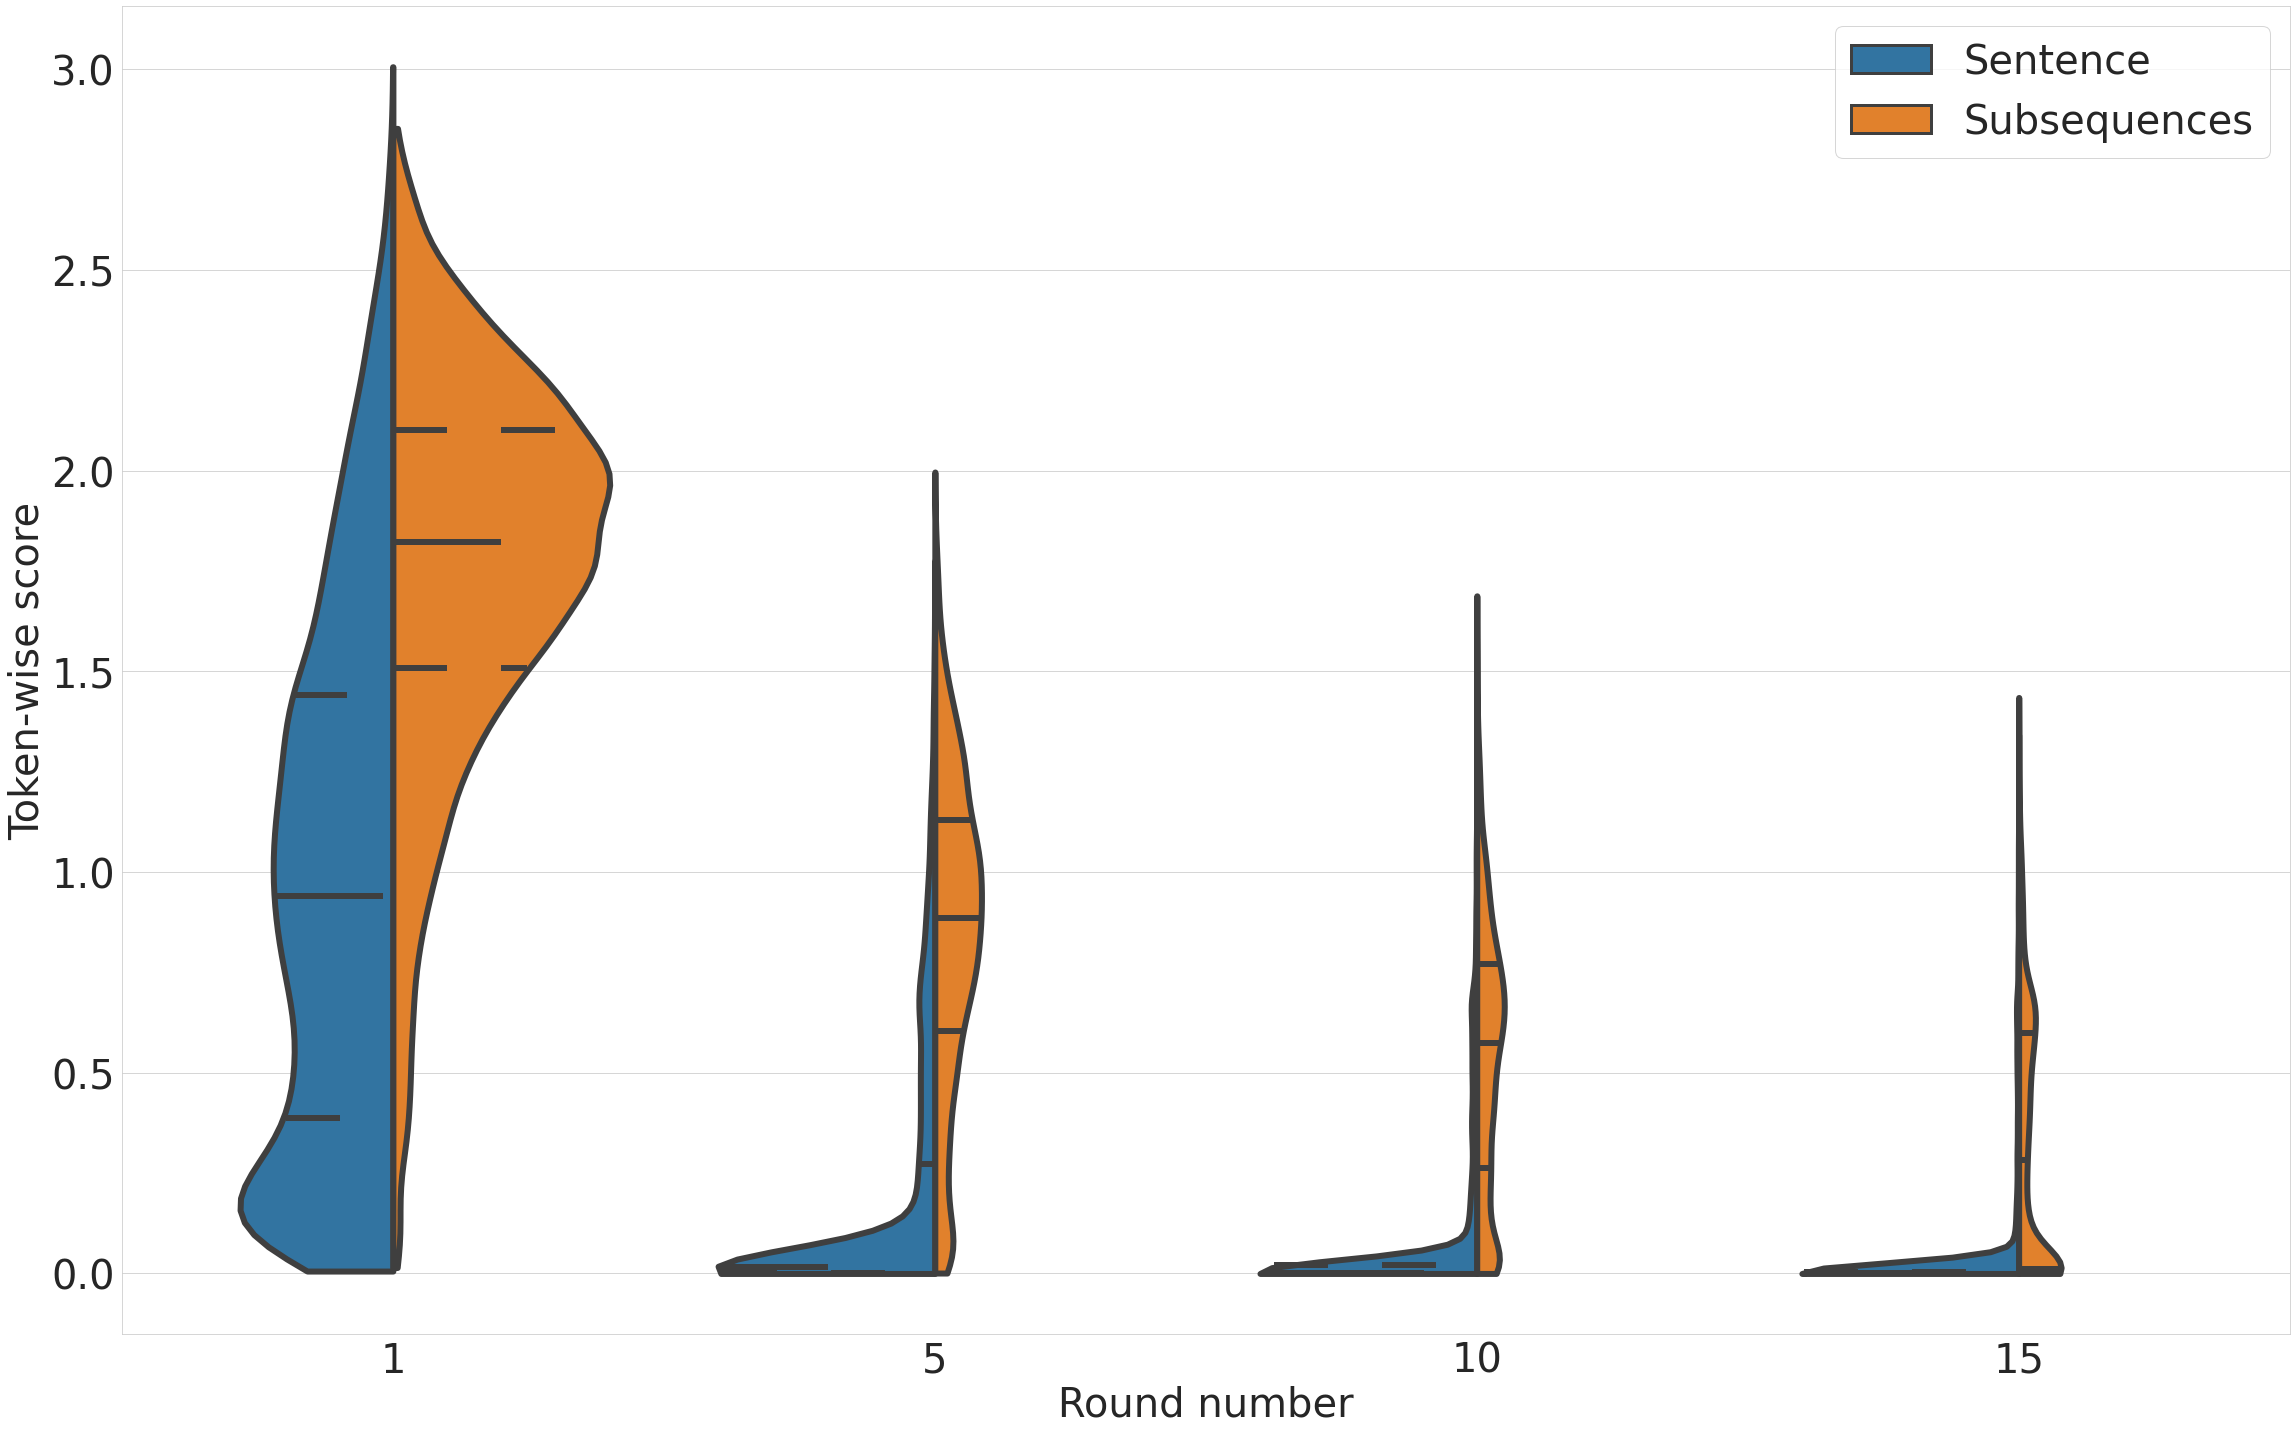

In [837]:
name_change = lambda x: x[0].upper() + x[1:] if x != 'windows' else 'Subsequences'
    
score_dist_sentence_df.ac_type = score_dist_sentence_df.ac_type.map(name_change)

# fig, axs = plt.subplots(4, figsize = (18, 32))
fig, axs = plt.subplots(1, figsize = (32, 20)); axs = [axs]

#axs[0].set_title("Token-wise $\\tt{lc}$ score - $\\alpha = $"+str(alpha2), fontsize = 25)
# axs[1,].set_title(f"Windows vs. full sentence across rounds - $\\alpha = {alpha1}$", fontsize = 25)
# axs[2,].set_title("Windows, different alphas across rounds", fontsize = 25)
# axs[3,].set_title("Full sentence, different alphas across rounds", fontsize = 25)

sns.violinplot(x = "round_num", y = "score", hue = "ac_type", split = True, inner = "quartile", 
               data=score_dist_sentence_df, ax = axs[0], cut=0)

#sns.violinplot(x = "round_num", y = "score", hue = "ac_type", split = True, inner = "quartile", 
#               data=df[df["alpha"] == alpha1], ax = axs[1], cut=0)

#sns.violinplot(x = "round_num", y = "score", hue = "alpha", split = True, inner = "quartile", 
#               data=df[df["ac_type"] == "windows"], ax = axs[2,], cut=0)

#sns.violinplot(x = "round_num", y = "score", hue = "alpha", split = True, inner = "quartile", 
#               data=df[df["ac_type"] == "sentence"], ax = axs[3], cut=0)

axs[0].legend(fontsize=40)
#axs[1].legend(fontsize=20)
#axs[2].legend(fontsize=20)
#axs[3].legend(fontsize=20)

ax = axs[0]
ax.set_xlabel("Round number", fontsize=40)
ax.set_ylabel("Token-wise score", fontsize=40)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(40)

plt.tight_layout()

In [ ]:
Hi Joe nw at all, sure you're very busy rn too so no rush for replies! Can I ask what kind of jobs you're working on within fintech rn?



In [399]:
# Now for sentence vs. window.
# This requires windows rounds with all scores ==> only a few roots e.g.:
# -W-3-7--A-lc--T-1--alpha-0---beta-0--R-10000--B-1--I-0.01--2020-12-23-01:14:30

In [743]:
from itertools import groupby

def get_unlabelled_scores_json(root, round_num):
    if "-W--1" in root:
        raise ValueError("Root must be a window selector")
    with open(os.path.join(root, f"round-{round_num}", "all_word_scores_no_nan.json"), "r") as jfile:
        all_scores = json.load(jfile)
    with open(os.path.join(root, f"round-{round_num-1}", "agent_index.pk"), "r") as jfile:
        agent_index = json.load(jfile)
        
    all_scores_out = {}
    
    for sidx, unlabelled_set in agent_index["unlabelled_idx"].items():
        if sidx in all_scores:
            all_scores_out[int(sidx)] = [all_scores[sidx][j] if j in unlabelled_set else np.nan for j in range(len(all_scores[sidx]))]
        else:
            pass
        
    return all_scores_out

def greedy_window_acquisition_with_alpha(window_scores, alpha, round_size=10000):
    # Remember input needs to be alpha = 0.0, and unpurified entries
    window_scores_alpha = [[w[0], w[1], w[-1]*((w[1][1] - w[1][0])**-alpha)] for w in window_scores]
    window_scores_alpha_pure = []
    for k, v in groupby(window_scores_alpha, lambda x: x[0]):
        v = sorted(list(v), key = lambda x: x[-1], reverse = True)
        window_scores_alpha_pure.extend(purify_entries(v))
    all_windows = sorted(window_scores_alpha_pure, key = lambda x: x[-1], reverse = True)
    greedy_windows, total_size = [], 0
    for w in tqdm(all_windows):
        greedy_windows.append(w)
        total_size += w[1][1]-w[1][0]
        if total_size > round_size:
            break
    return greedy_windows

In [809]:
root1 = '-W-1--A-lc--T-1--alpha-0---beta-0--R-10000--B-1--I-0.01--2021-01-17-07:10:25'
root2 = '-W-3-7--A-lc--T-1--alpha-0---beta-0--R-10000--B-1--I-0.01--2020-12-23-01:14:30'
alpha1 = 0
alpha2 = 0.7
round_nums = [1, 5, 10, 15]

score_dist_token_df = pd.DataFrame(columns = ["ac_type", "round_num", "alpha", "score"])

for round_num in tqdm(round_nums):
    all_token_scores = get_unlabelled_scores_json(root=root1, round_num=round_num)
    all_window_scores = get_unlabelled_scores_json(root=root2, round_num=round_num)
    
    _, window_scores = generate_windows_scores_from_json(all_window_scores, L_min=3, L_max_plus_one=7, alpha=alpha2)
    _, token_scores = generate_windows_scores_from_json(all_token_scores, L_min=1, L_max_plus_one=2, alpha=alpha1)
    print("got scores")

    window_acquisition = greedy_window_acquisition_without_word_checker(window_scores)
    token_acquisition = greedy_window_acquisition_without_word_checker(token_scores)
    
    print("got acquisition")

    token_score_dist = get_score_distribution_from_windows(token_acquisition, all_token_scores)
    window_score_dist = get_score_distribution_from_windows(window_acquisition, all_window_scores)
    print("got distribution")
    
    score_dist_token_df = score_dist_token_df.append(pd.Series(index = ["ac_type", "round_num", "alpha", "score"], data = np.array(["token", round_num, alpha1, token_score_dist]).T), ignore_index=True)
    score_dist_token_df = score_dist_token_df.append(pd.Series(index = ["ac_type", "round_num", "alpha", "score"], data = np.array(["window", round_num, alpha2, window_score_dist]).T), ignore_index=True)

score_dist_token_df = score_dist_token_df.explode('score').reset_index(drop=True)
score_dist_token_df["score"] = score_dist_token_df["score"].map(lambda x: float(x))

  0%|          | 0/4 [00:00<?, ?it/s]

got scores



  0%|          | 2262/1255271 [00:00<00:10, 123259.31it/s]

  1%|          | 10000/1731475 [00:00<00:07, 224348.32it/s]
/home/pradmard/anaconda3/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/pradmard/anaconda3/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
 25%|██▌       | 1/4 [03:08<09:25, 188.63s/it]

got acquisition
got distribution
got scores



  0%|          | 2688/1278789 [00:00<00:05, 224305.93it/s]

 50%|█████     | 2/4 [05:55<06:04, 182.21s/it]

got acquisition
got distribution
got scores



  0%|          | 2860/1211383 [00:00<00:04, 255548.66it/s]

 75%|███████▌  | 3/4 [09:03<03:03, 183.70s/it]

got acquisition
got distribution
got scores



  0%|          | 2833/1167192 [00:00<00:07, 153304.30it/s]

  1%|          | 10000/1591475 [00:00<00:06, 247594.72it/s]


got acquisition
got distribution


100%|██████████| 4/4 [11:46<00:00, 176.69s/it]


In [812]:
score_dist_token_df["score"] = score_dist_token_df["score"].map(lambda x: float(x))
score_dist_token_df["round_num"] = score_dist_token_df["round_num"].map(lambda x: int(x))
score_dist_token_df["ac_type"] = score_dist_token_df["ac_type"].map(lambda x: "Sub-sequences" if x == 'window' else "Tokens")

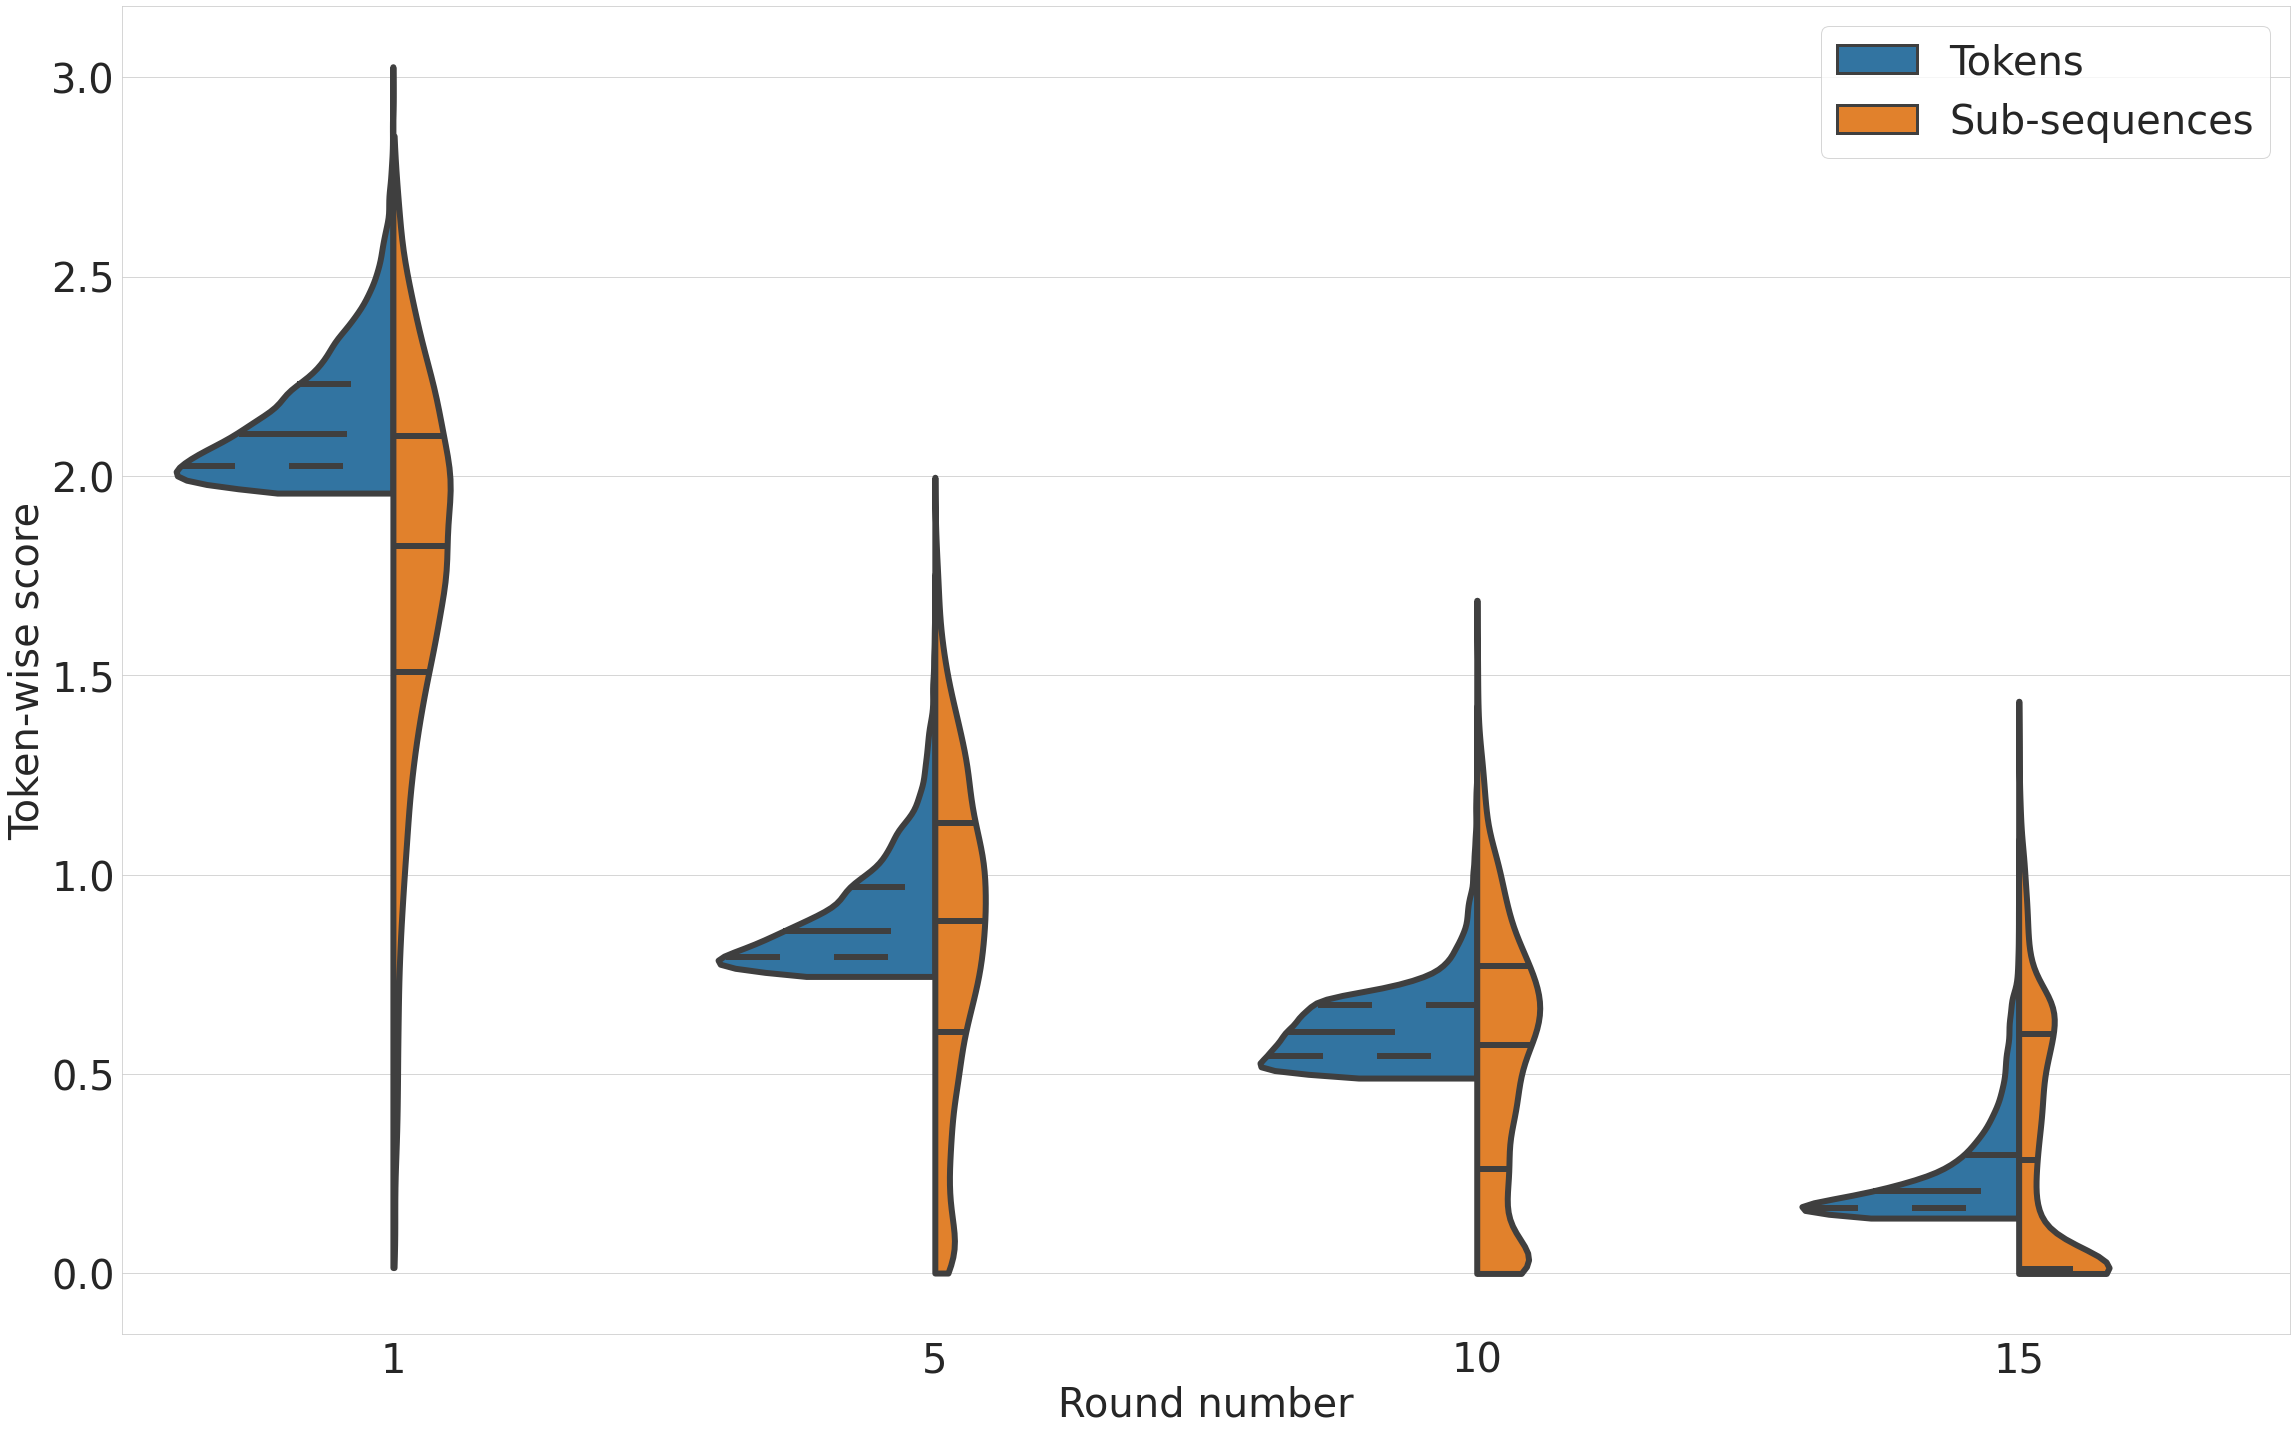

In [838]:
from itertools import product

# fig, axs = plt.subplots(3, figsize = (16, 30))
fig, axs = plt.subplots(1, figsize = (32, 20)); axs = [axs]
# axs[1].set_title(f"Windows across rounds, composition of window sizes, $\\alpha = {alpha1}$", fontsize=25)
# axs[2].set_title(f"Windows across rounds, composition of window sizes, $\\alpha = {alpha2}$", fontsize=25)
sns.violinplot(y = "score", x = "round_num", hue = "ac_type", split = True, inner = "quartile", 
               data=score_dist_token_df, ax = axs[0], cut=0)

if False:
    grouped_df = score_dist_token_df.groupby(['alpha','round_num', 'window_size']).size().reset_index().rename(columns={0:'count'})
    all_alphas = np.unique(grouped_df.alpha)
    all_rounds = np.unique(grouped_df.round_num)
    ws = sorted(np.unique(score_dist_token_df.window_size))

    uniques = [all_alphas, all_rounds, ws, [0]]
    all_poss_df = pd.DataFrame(product(*uniques), columns = grouped_df.columns)
    grouped_df = pd.concat([grouped_df, all_poss_df]).groupby(['alpha', 'round_num', 'window_size']).sum().reset_index()

    grouped_df1 = grouped_df[grouped_df.alpha == alpha1]
    grouped_df2 = grouped_df[grouped_df.alpha == alpha2]

    for i, gdi in [(1, grouped_df1), (2, grouped_df2)]:
        bot = np.array([0 for _ in round_nums])
        for j, w in enumerate(ws):
            dfw = gdi[gdi.window_size == w]
            #axs[i].bar(dfw.round_num, dfw["count"], label = w, bottom = bot)
            bot+=np.array(dfw["count"])
        
axs[0].legend(fontsize=40)
#axs[1].legend(fontsize=20)
#axs[2].legend(fontsize=20)
#axs[3].legend(fontsize=20)

ax = axs[0]
ax.set_xlabel("Round number", fontsize=40)
ax.set_ylabel("Token-wise score", fontsize=40)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(40)

plt.tight_layout()

In [1102]:
# Score comparison - beam search vs. greedy
# CHALK UP AS JUST APPENDIX WORK

from tqdm import tqdm
import json

print("All beam searched experiments")
print("\n".join(glob("*--B-5-*")))

beam_root_main = "-W-3-7--A-lc--T-1--alpha-1---beta-0--R-10000--B-5--I-0.01--2020-12-16-00:36:34"
comp_root_main = "-W-3-7--A-lc--T-1--alpha-1---beta-0--R-10000--B-1--I-0.01--2020-12-16-00:50:05"

beam_scores = []
greedy_scores = []
comp_scores = []
alpha = 1

for i in tqdm(range(15)):
    beam_root = f"{beam_root_main}/round-{i}"
    comp_root = f"{comp_root_main}/round-{i}"
    
    with open(os.path.join(beam_root, "round_selection.pk")) as jfile:
        beam_round_selection = json.load(jfile)
    all_beam_windows = sorted(beam_round_selection['all_round_windows'], key = lambda x: x[-1], reverse = True)
    selected_beam_windows = sorted(beam_round_selection['round_selection_windows'], key = lambda x: x[-1], reverse = True)
    
    print("mapping sentences")
    sentence_mapping = map_windows_to_sentences(all_windows)
    word_checker = {k: [1 for _ in range(max([w[1][1] for w in v]))] for k, v, in sentence_mapping.items()}
    
    print("finding window acquisitions")
    greedy_window_acquisitions = greedy_window_acquisition(all_windows, word_checker)
    greedy_score = sum([w[-1] for w in selected_beam_windows])
    beam_score = sum([w[-1] for w in selected_beam_windows])
    beam_scores.append(beam_score)
    greedy_scores.append(greedy_score)
    
    with open(os.path.join(comp_root, "round_selection.pk")) as jfile:
        comp_round_selection = json.load(jfile)
    selected_comp_windows = sorted(comp_round_selection['round_selection_windows'], key = lambda x: x[-1], reverse = True)
    comp_score = sum([w[-1] for w in selected_comp_windows])
    comp_scores.append(comp_score)
    
    print(beam_scores)
    print(greedy_scores)
    print(comp_scores)

plt.plot(beam_scores[1:], label="beam score")
plt.plot(greedy_scores[1:], label="greedy score")
plt.plot(comp_scores[1:], label="comparison score (from another greedy run)")
plt.xlim(0, 13); plt.ylim(900, 6000)
plt.legend(); plt.figure(figsize=(20,20)); plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]

All beam searched experiments
-W-3-7--A-lc--T-1--alpha-0---beta-0--R-10000--B-5--I-0.01--2020-12-16-00:36:45
-W-3-7--A-lc--T-1--alpha-0.7---beta-0--R-10000--B-5--I-0.01--2020-12-16-00:36:42
-W-3-7--A-lc--T-1--alpha-0.7---beta-0--R-10000--B-5--I-0.01--2020-12-16-00:48:39


FileNotFoundError: [Errno 2] No such file or directory: '-W-3-7--A-lc--T-1--alpha-1---beta-0--R-10000--B-5--I-0.01--2020-12-16-00:36:34/round-0/round_selection.pk'

In [ ]:
import json

with open("-W-3-7--A-lc--T-1--alpha-0.7---beta-0--R-10000--B-5--I-0.01--2020-12-16-00:36:42/round-1/agent_index.pk") as f:
    index1 = json.load(f)
    
with open("-W-3-7--A-lc--T-1--alpha-0.7---beta-0--R-10000--B-5--I-0.01--2020-12-16-00:36:42/round-0/agent_index.pk") as f:
    index0 = json.load(f)

labelled_lengths = [len(v) for k, v in index1["labelled_idx"].items()]
unlabelled_lengths = [len(v) for k, v in index1["unlabelled_idx"].items()]

maxes = np.array([max([labelled_lengths[i], unlabelled_lengths[i]]) for i in range(len(labelled_lengths))])
mins = np.array([min([labelled_lengths[i], unlabelled_lengths[i]]) for i in range(len(labelled_lengths))])
difference = maxes - mins

In [ ]:
def get_labelled_props_old(round_path, j):
    record_tsv = pd.read_csv(os.path.join(round_path, f"record.tsv"))
    _num_words = record_tsv.iloc[-1,0].split()[0]
    sent_prop_tsv = pd.read_csv(os.path.join(round_path, f"sentence_prop-{j}.tsv"))
    num_column = list(sent_prop_tsv.index)[1:]
    props = []
    for nc in num_column:
        props.extend([float(a) for a in nc.split("\t")])
    return props, _num_words

def get_labelled_props(round_path, j):
    sent_prop_tsv = pd.read_csv(os.path.join(round_path, f"sentence_prop-{j}.tsv"), sep='\t')
    record_tsv = pd.read_csv(os.path.join(round_path, f"record.tsv"))
    _num_words = record_tsv.iloc[-1,0].split()[0]
    props = list(sent_prop_tsv["num_labelled"]/sent_prop_tsv["sent_length"])
    # print("on config", _num_words)
    # print("in props", sum(sent_prop_tsv["num_labelled"]))
    assert all([a<=1 for a in props])
    return props, _num_words
    

In [ ]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# root = 'A-lc--W-5--beta-0.1--alpha-1.0--T-1.0--R-200000--2020-12-01-20:38:13'
roots = glob('-W*lc*')
print(len(roots), "viable roots")
fig, axs = plt.subplots(len(roots), figsize = (15, len(roots)*10))

for r, root in enumerate(roots):
    round_dirs = sorted(glob(os.path.join(root, "round-*")), key = lambda x: int(x.split('-')[-1]))
    axs[r].set_title(root)    

    for j, round_path in enumerate(round_dirs[:-1]):
        xx = np.linspace(0, 1, 1000)
        props, _num_words = get_labelled_props(round_path, j)
        # axs[r].hist(props, bins = 10, label = str(_num_words))
        kde = stats.gaussian_kde(props)
        axs[r].plot(xx, kde(xx), label = str(_num_words), linewidth = 5)
    
    if len(round_dirs) > 1:
        plt.legend()
    break

In [2163]:
# Dataset analysis
from train import load_dataset as load_dataset2

# helper, word_embeddings, train_data, test_data, tag_set = load_dataset("/home/pradmard/repos/data/OntoNotes-5.0/NER")
helper, word_embeddings, train_data, test_data, tag_set = load_dataset("/home/pradmard/repos/data/CONLL/conll2003")

[('CARDINAL', 11912),
 ('PERSON', 17890),
 ('ORG', 46698),
 ('DATE', 34658),
 ('ORDINAL', 1639),
 ('NORP', 7715),
 ('LOC', 3060),
 ('LAW', 1114),
 ('LANGUAGE', 199),
 ('PRODUCT', 1680),
 ('GPE', 20349),
 ('TIME', 3443),
 ('WORK_OF_ART', 3135),
 ('MONEY', 12791),
 ('PERCENT', 3303),
 ('EVENT', 1962),
 ('QUANTITY', 2540),
 ('FAC', 2264)]

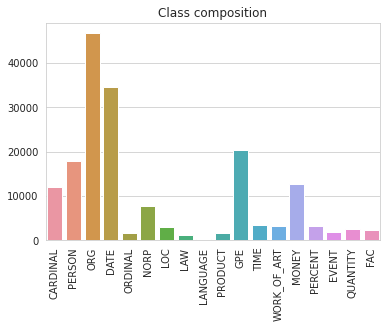

In [521]:
# Class composition

import itertools

counts = [0 for _ in tag_set.idx2key]
for _, _, tags in train_data:
    for tag in tags:
        counts[tag] += 1

def same_key_type(key1, key2):
    if key1 == 'O' or key2 == 'O':
        return False
    if key1[0] != key2[0]:
        return key1.split("-")[-1] == key2.split("-")[-1]

def get_class(key):
    return key.split("-")[-1]

def combine_classes_and_remove_empty(l):
    class_types = []
    class_counts = []

    for (idx1, tag1), (idx2, tag2) in itertools.product(enumerate(tag_set.idx2key), repeat=2):
        if get_class(tag1) in class_types or get_class(tag2) in class_types:
            continue
        if same_key_type(tag1, tag2):
            class_types.append(get_class(tag1))
            class_counts.append(l[idx1] + l[idx2])
        if ("PER" in tag1) and ("PER" in tag2):    # No B-PER ?
            class_types.append(get_class(tag1))
            class_counts.append(l[idx1])
            
    return class_types, class_counts

class_types, class_counts = combine_classes_and_remove_empty(counts)
ax = sns.barplot(x = class_types, y = class_counts)
ax.set_title("Class composition")
plt.xticks(rotation=90)
list(zip(class_types, class_counts))

In [2166]:
get_key_type = lambda x: x.split("-")[-1]

key_types = np.unique([get_key_type(k) for k in tag_set.idx2key])
key_type_mapper = {}

for j, tag in enumerate(tag_set.idx2key):
    
    key_type_mapper[j] = key_types[np.where(key_types == get_key_type(tag))[0][0]]

In [2167]:
from itertools import groupby

span_lengths = {k: {} for k in key_types}

for _, _, tags in train_data[46:]:
    tags_fixed = [key_type_mapper[j] for j in tags]
    spans = [(k, sum(1 for i in g)) for k,g in groupby(tags_fixed)]
    for key, length in spans:
        if length not in span_lengths[key]:
            span_lengths[key][length] = 1
        else:
            span_lengths[key][length] += 1

In [2168]:
palette = itertools.cycle(sns.color_palette())

df = pd.DataFrame(columns = ["Entity Type", "Entity Length (tokens)"])

for k, v in tqdm(span_lengths.items()):
    if k != "O":
        dist = dict_to_dist(v)
        df = df.append(pd.DataFrame(columns = ["Entity Type", "Entity Length (tokens)"], data = np.array([[k for _ in dist], dist]).T), ignore_index = True)
df["Entity Length (tokens)"] = df["Entity Length (tokens)"].map(lambda x: int(x))

100%|██████████| 5/5 [00:00<00:00, 76.59it/s]


<AxesSubplot:title={'center':'Distribution of entity lengths in tokens for each entitiy type'}, xlabel='Entity Length (tokens)', ylabel='Entity Type'>

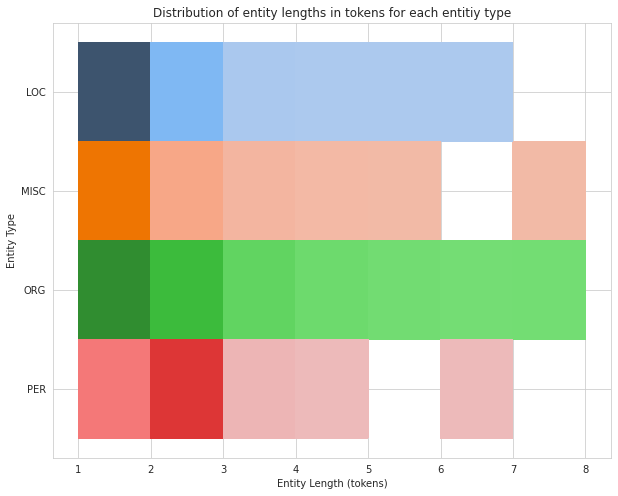

In [2169]:
fg, axs = plt.subplots(1, figsize = (10, 8))
axs.set_title("Distribution of entity lengths in tokens for each entitiy type")
sns.histplot(df, y = "Entity Type", x="Entity Length (tokens)", hue = "Entity Type", binwidth = 1, ax = axs, legend = False)

In [ ]:
print(len(df[df["Entity Length (tokens)"]<=6]))
print(len(df[df["Entity Length (tokens)"]>6]))
print(len(df))

In [467]:
# Score comparison - whole sentence vs. window for same window experiment
# Here, we want to get per-word, not per window, so we 'de-normalise' with alpha

def denormalise_window_score(window, alpha):
    L = window[1][1] - window[1][0]
    return window[-1] * (L**alpha)

def map_windows_to_sentences(all_windows):
    res = {}
    for window in all_windows:
        sentence_idx = window[0]
        if sentence_idx in res:
            res[sentence_idx].append(window)
        else:
            res[sentence_idx] = [window]
    return res


def get_score_for_window(sentence_windows, rng, alpha):
    correct_window = [w for w in sentence_windows if w[1] == rng]
    if not correct_window:
        print(sentence_windows)
        print(rng)
    return denormalise_window_score(correct_window[0], alpha)

def solve_word_scores_in_sentence(sentence_windows, alpha):
    max_idx = max([w[1][1] for w in sentence_windows])
    scores = ["empty" for _ in range(max_idx)]
    if len(scores) == 5:
        win03 = get_score_for_window(sentence_windows, rng=[0,3], alpha=alpha)
        win04 = get_score_for_window(sentence_windows, rng=[0,4], alpha=alpha)
        win14 = get_score_for_window(sentence_windows, rng=[1,4], alpha=alpha)
        scores[0], scores[3] = win04 - win14, win04 - win03
        win05 = get_score_for_window(sentence_windows, rng=[0,5], alpha=alpha)
        scores[4] = win05 - win04
        win15 = get_score_for_window(sentence_windows, rng=[1,5], alpha=alpha)
        win25 = get_score_for_window(sentence_windows, rng=[2,5], alpha=alpha)
        scores[1] = win15 - win25
        scores[2] = win05 - scores[0] - scores[1] - scores[3] - scores[4]
    elif len(scores) == 4:
        winleft = get_score_for_window(sentence_windows, rng=[0,3], alpha=alpha)
        winright = get_score_for_window(sentence_windows, rng=[1,4], alpha=alpha)
        winwhole = get_score_for_window(sentence_windows, rng=[1,4], alpha=alpha)
        scores[0] = winwhole - winright
        scores[-1] = winwhole - winleft
        scores[1] = (winwhole - scores[0] - scores[3])/2
        scores[2] = (winwhole - scores[0] - scores[3])/2
    elif len(scores) < 4:
        full_sentence = get_score_for_window(sentence_windows, rng=[0,3], alpha=alpha)
        scores = [full_sentence/len(scores) for s in scores]
    elif len(scores) > 5:
        for j in range(max_idx-3):
            wind4 = get_score_for_window(sentence_windows, rng=[j,j+4], alpha=alpha)
            wind3 = get_score_for_window(sentence_windows, rng=[j+1,j+4], alpha=alpha)
            scores[j] = wind4-wind3
        for j in range(max_idx-3,max_idx):
            wind4 = get_score_for_window(sentence_windows, rng=[j-3,j+1], alpha=alpha)
            wind3 = get_score_for_window(sentence_windows, rng=[j-3,j], alpha=alpha)
            scores[j] = wind4-wind3
    else:
        raise ValueError
    return scores
    
def deconstruct_word_scores(sentence_mapping, alpha):
    res = {}
    for i, sentence_windows in tqdm(sentence_mapping.items()):
        deconstructed_scores = solve_word_scores_in_sentence(sentence_windows, alpha = alpha)
        res[i] = deconstructed_scores
    return res


def get_all_round_windows(round_root):
    with open(os.path.join(round_root, "round_selection.pk")) as jfile:
        round_selection = json.load(jfile)       
    all_windows = round_selection['all_round_windows']
    return all_windows


def greedy_window_acquisition(all_windows, word_checker):
    greedy_windows, total_size = [], 0
    all_windows = sorted(all_windows, key = lambda x: x[-1], reverse = True)
    for w in tqdm(all_windows):
        if any([np.isnan(a) for a in word_checker[w[0]][w[1][0]:w[1][1]]]):
            pass
        else:
            greedy_windows.append(w)
            for j in range(*w[1]):
                word_checker[w[0]][j] = np.nan
            total_size += w[1][1]-w[1][0]
        if total_size > 10000: break
    return greedy_windows

def get_word_scores(windows, word_scores):
    chosen_word_scores = []
    for i, r, score in tqdm(windows):
        new_scores = word_scores[i][r[0]:r[1]]
        chosen_word_scores.extend(new_scores)
    return chosen_word_scores

def sentence_to_windows(word_scores, alpha):
    windows = []
    for i, list_of_windows in word_scores.items():
        score = sum(list_of_windows) * (len(list_of_windows)**-alpha)
        new_window = [i, [0, len(list_of_windows)], score]
        windows.append(new_window)
    return windows

In [471]:
# Remember to do this for a beam searched root, where windows aren't purified

#def compare_windows_and_sentences(round_root, alpha):
round_root = "-W-3-7--A-lc--T-1--alpha-0.7---beta-0--R-10000--B-5--I-0.01--2020-12-16-00:48:39/round-1"
alpha = 1.0

for _ in range(1):
    #print("loading root")
    #all_windows = get_all_round_windows(round_root)
    #print("mapping sentences")
    #sentence_mapping = map_windows_to_sentences(all_windows)
    #print("solving scores")
    #all_word_scores = deconstruct_word_scores(sentence_mapping, alpha)
    #word_checker = {k: [1 for _ in range(len(v))] for k, v, in all_word_scores.items()}
    
    print("finding window acquisitions")
    window_acquisitions = greedy_window_acquisition(all_windows, word_checker)
    print("finding word-wise scores from window acquisiton")
    window_acquisition_scores = get_word_scores(window_acquisitions, all_word_scores)
    
    print("converting full sentences to windows")
    full_sentence_as_windows = sentence_to_windows(all_word_scores, alpha)
    print("finding full sentence scores")
    full_sentence_acquisitions = greedy_window_acquisition(full_sentence_as_windows, word_checker)
    full_sentence_acquisition_scores = get_word_scores(full_sentence_acquisitions, all_word_scores)

finding window acquisitions


100%|██████████| 3233/3233 [00:00<00:00, 546737.55it/s]


finding word-wise scores from window acquisiton
converting full sentences to windows


100%|██████████| 928/928 [00:00<00:00, 283861.88it/s]

finding full sentence scores


/home/pradmard/anaconda3/envs/experiments/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/pradmard/anaconda3/envs/experiments/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of LC scores per word in a round of acquisition')

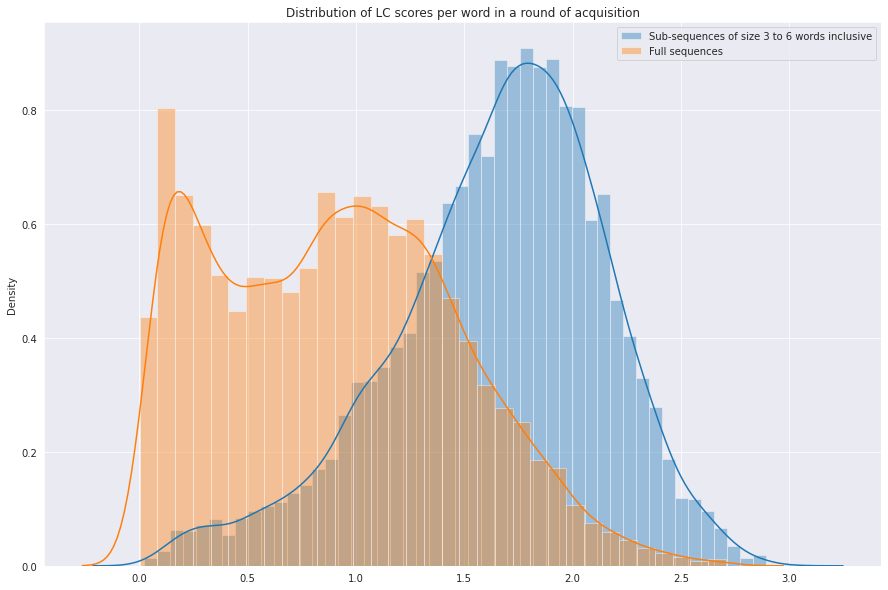

In [472]:
fig, axs = plt.subplots(1, figsize = (15, 10))

window_acquisition_scores_series = pd.Series(window_acquisition_scores)
full_sentence_acquisition_scores_series = pd.Series(full_sentence_acquisition_scores)
window_acquisition_scores_series = window_acquisition_scores_series[window_acquisition_scores_series>0]
full_sentence_acquisition_scores_series = full_sentence_acquisition_scores_series[full_sentence_acquisition_scores_series>0]

sns.distplot(window_acquisition_scores_series, label = "Sub-sequences of size 3 to 6 words inclusive", ax = axs)
sns.distplot(full_sentence_acquisition_scores_series, label = "Full sequences", ax = axs)

plt.legend()
plt.title("Distribution of LC scores per word in a round of acquisition", )